# AP-1 Figures

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/home/jenhan/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


## Functions

In [2]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    print('total:',features.shape[0], 'filtered:',filtered_features.shape[0], 'true gc:',np.round(true_gc_content,5), 'false gc:', np.round(false_gc_content,5), 'difference:',np.round(abs(true_gc_content - false_gc_content),5))

#     training_features, test_features, training_labels, test_labels = train_test_split(
#         filtered_features, filtered_labels, 
#         test_size =test_size, 
#         random_state=np.random.RandomState(0),
#         )
    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    
#     n_samples = filtered_features.shape[0]
#     n_features = filtered_features.shape[1]

#     # shuffle and split training and test sets
#     filtered_features, filtered_labels = shuffle(filtered_features, filtered_labels, random_state=np.random.RandomState(0))
#     split = int(0.80*n_samples)
#     training_features, test_features = filtered_features[:split], filtered_features[split:]
#     training_labels, test_labels = filtered_labels[:split], filtered_labels[split:]
    
    return training_features, test_features, training_labels, test_labels
    

## Read in Score Files

In [20]:
motif_score_frame=pd.read_pickle('motif_score_frame.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
scaler = preprocessing.MinMaxScaler()
normed_summary_frame = pd.DataFrame(scaler.fit_transform(summary_frame.ix[:,5:]))
normed_summary_frame.columns = summary_frame.columns.values[5:]
normed_summary_frame.index = summary_frame.index.values

scaled_motif_frame = pd.DataFrame()
for m in motif_score_frame.columns[3:]:
    scaled_motif_frame[m] = motif_score_frame[m]/(2*motif_sequence_frame[m].str.len().max())
    
    
motif_interaction_frame = pd.DataFrame(
    sklearn.preprocessing.PolynomialFeatures(
        degree=2, interaction_only=True).fit_transform(motif_score_frame.ix[:,3:])
).ix[:,1:]
motifs = motif_score_frame.columns.values[3:]
interaction_term_columns = list(motifs)
for i in range(len(motifs)-1):
    for j in range(i+1,len(motifs)):
        interaction_term_columns.append(motifs[i]+'::'+motifs[j])
motif_interaction_frame.columns = interaction_term_columns
motif_interaction_frame.index = motif_score_frame.index.values

# significant_motifs_dict = pickle.load( open( "significant_motifs_dict.pickle", "rb" ) )
# motif_difference_dict = pickle.load( open( "motif_difference_dict.pickle", "rb" ) )


### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]





### read in sequences as dictionary {peakID: sequence}
with open('./group/merged.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [ ]:
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

## Figure 1 - AP-1 genetically co-localizes with PU-1 and CEBPa

### 1a - Venn diagram of PU-1, CEBPa, and AP-1 (all members merged) in vehicle and KLA

In [5]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']

In [631]:
summary_frame = pd.read_pickle('summary_frame.pickle')



/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


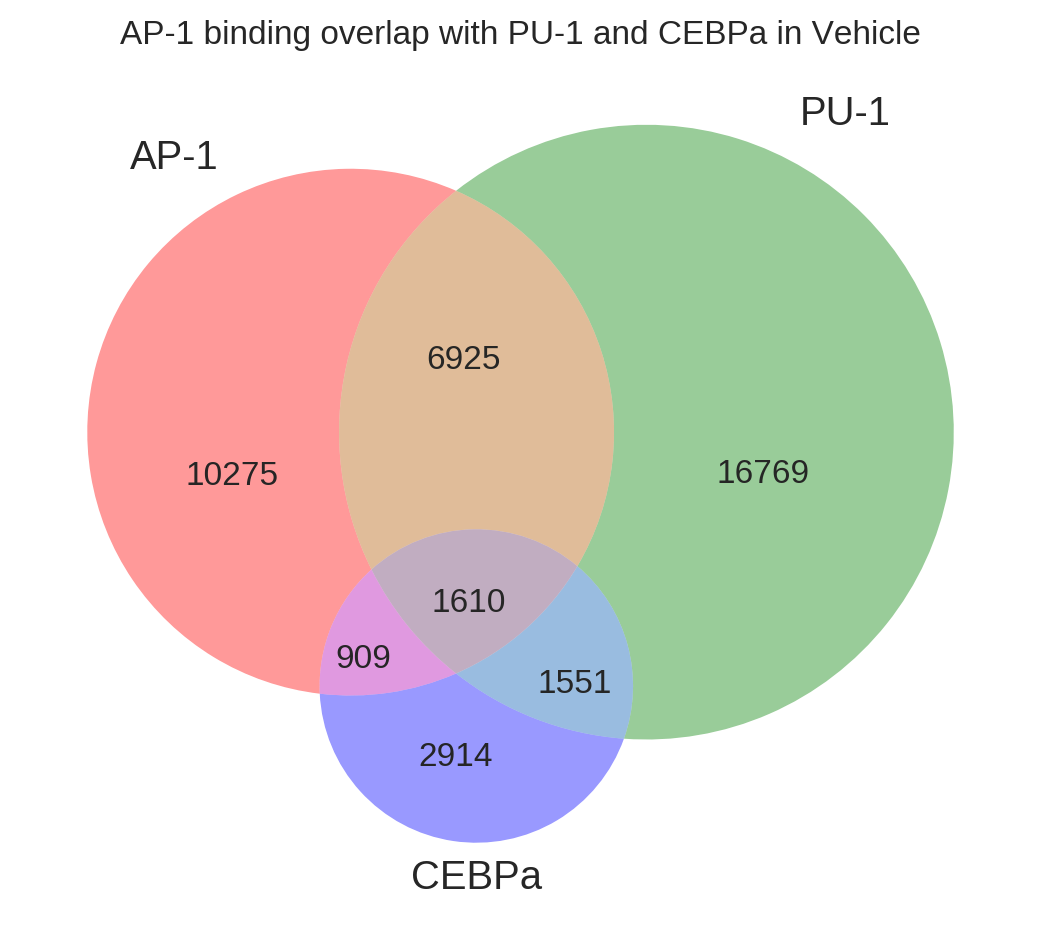

In [632]:
ap1_indices = summary_frame[summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0].index.values
pu1_indices = summary_frame[summary_frame['c57bl6_pu1_veh'] >0].index.values
cebpa_indices = summary_frame[summary_frame['c57bl6_cebpa_veh']>0].index.values

matplotlib_venn.venn3([set(ap1_indices), set(pu1_indices), set(cebpa_indices)],set_labels=['AP-1', 'PU-1', 'CEBPa'])
plt.title('AP-1 binding overlap with PU-1 and CEBPa in Vehicle')

### 1b -  Motif analysis of PU-1, CEBPa, and AP-1 peaks. Bar plots showing what fraction of the peaks for each factor contain the PU-1, CEBPa, and AP-1 motif

In [22]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']


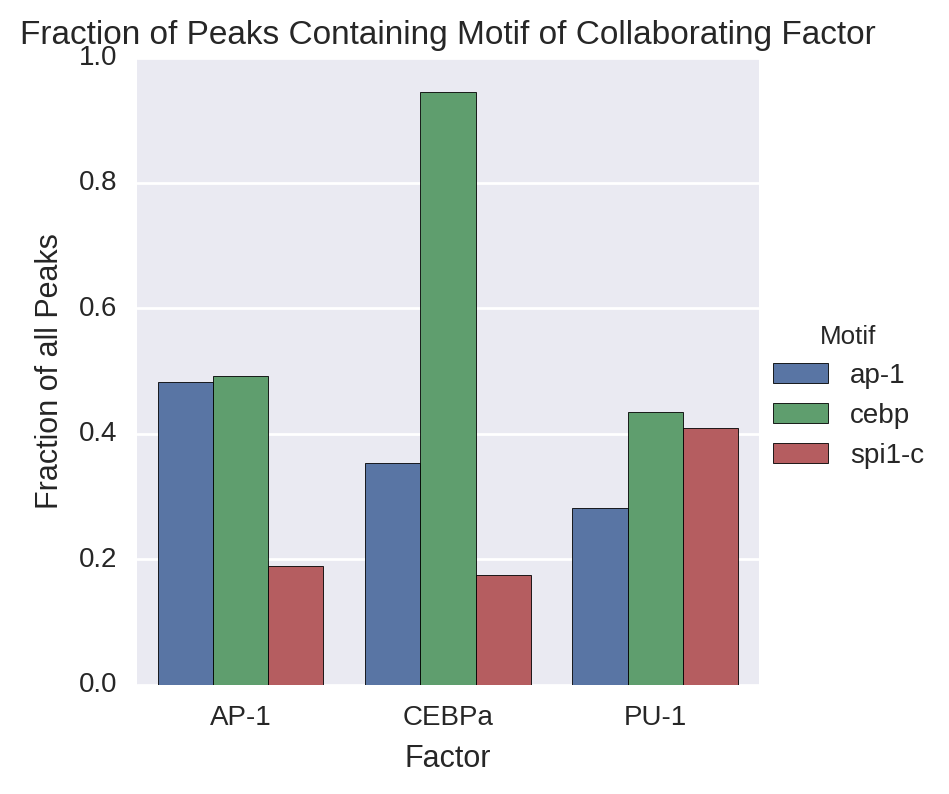

In [614]:
threshold = 0.3
ap1_indices = summary_frame[summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0].index.values
pu1_indices = summary_frame[summary_frame['c57bl6_pu1_veh'] >0].index.values
cebpa_indices = summary_frame[summary_frame['c57bl6_cebpa_veh']>0].index.values

fractions = []
motifs = []
factors = []
for motif in ['ap-1', 'cebp', 'spi1-c']:
    motifs = motifs +[motif] * 3
    
    factors.append('AP-1')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(ap1_indices)][motif] > threshold)/len(ap1_indices))
    factors.append('CEBPa')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(cebpa_indices)][motif] > threshold)/len(cebpa_indices))
    factors.append('PU-1')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(pu1_indices)][motif] > threshold)/len(pu1_indices))
plottingFrame =pd.DataFrame({'Factor':factors,
                           'Motif':motifs,
                            'Fraction of all Peaks':fractions})
sns.factorplot(data=plottingFrame, 
               x='Factor', 
               hue='Motif', 
               y='Fraction of all Peaks',
              kind='bar'
              )
plt.ylim(0,1)
plt.title('Fraction of Peaks Containing Motif of Collaborating Factor')

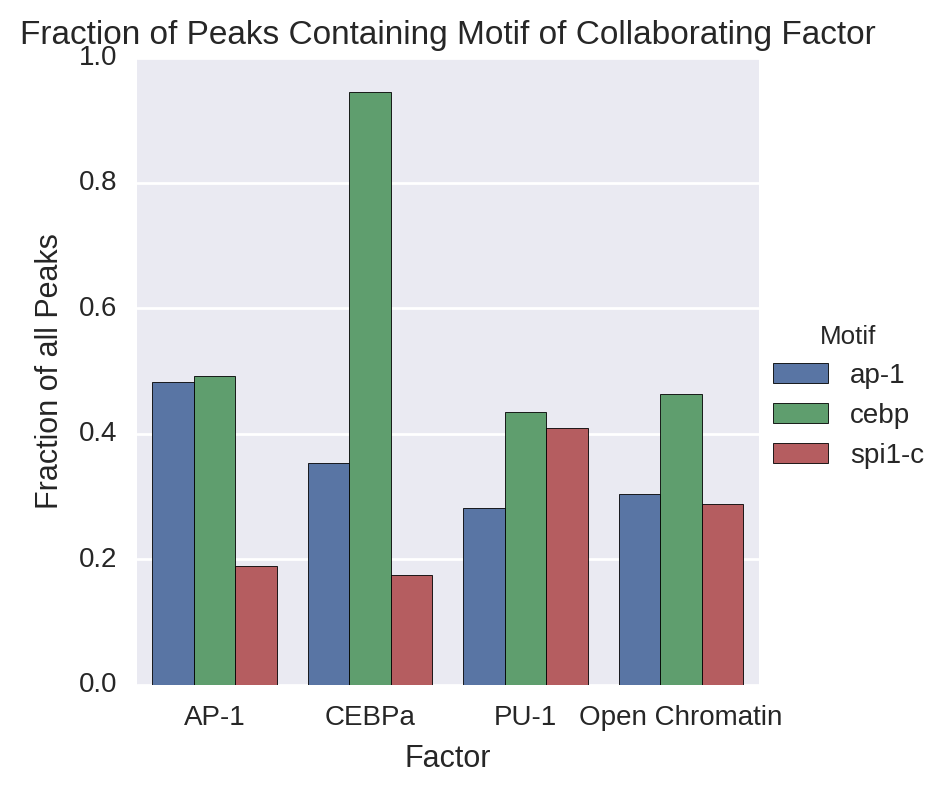

In [627]:
threshold = 0.3
ap1_indices = summary_frame[summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0].index.values
pu1_indices = summary_frame[summary_frame['c57bl6_pu1_veh'] >0].index.values
cebpa_indices = summary_frame[summary_frame['c57bl6_cebpa_veh']>0].index.values
open_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in _factors +['atac']]].sum(axis=1)>0].index.values
fractions = []
motifs = []
factors = []
for motif in ['ap-1', 'cebp', 'spi1-c']:
    motifs = motifs +[motif] * 4
    
    factors.append('AP-1')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(ap1_indices)][motif] > threshold)/len(ap1_indices))
    factors.append('CEBPa')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(cebpa_indices)][motif] > threshold)/len(cebpa_indices))
    factors.append('PU-1')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(pu1_indices)][motif] > threshold)/len(pu1_indices))
    factors.append('Open Chromatin')
    fractions.append(np.sum(normed_motif_frame[normed_motif_frame.index.isin(open_indices)][motif] > threshold)/len(open_indices))

    
plottingFrame =pd.DataFrame({'Factor':factors,
                           'Motif':motifs,
                            'Fraction of all Peaks':fractions})
sns.factorplot(data=plottingFrame, 
               x='Factor', 
               hue='Motif', 
               y='Fraction of all Peaks',
              kind='bar'
              )
plt.ylim(0,1)
plt.title('Fraction of Peaks Containing Motif of Collaborating Factor')

### 1c - Knockdown of of cJun impacts PU-1 and CEBPa binding. Venn diagrams showing overlap between knockdown and wildtype peaks in vehicle and KLA.

In [ ]:
%%bash
makeSummaryFile.sh /home/jenhan/analysis/ap1_analysis/peak_files_knockdowns_filtered/*Veh*tsv
mv group_summary.tsv knockdown_summary.tsv

In [33]:
knockdown_summary_frame = pd.read_csv('knockdown_summary.tsv', sep='\t')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


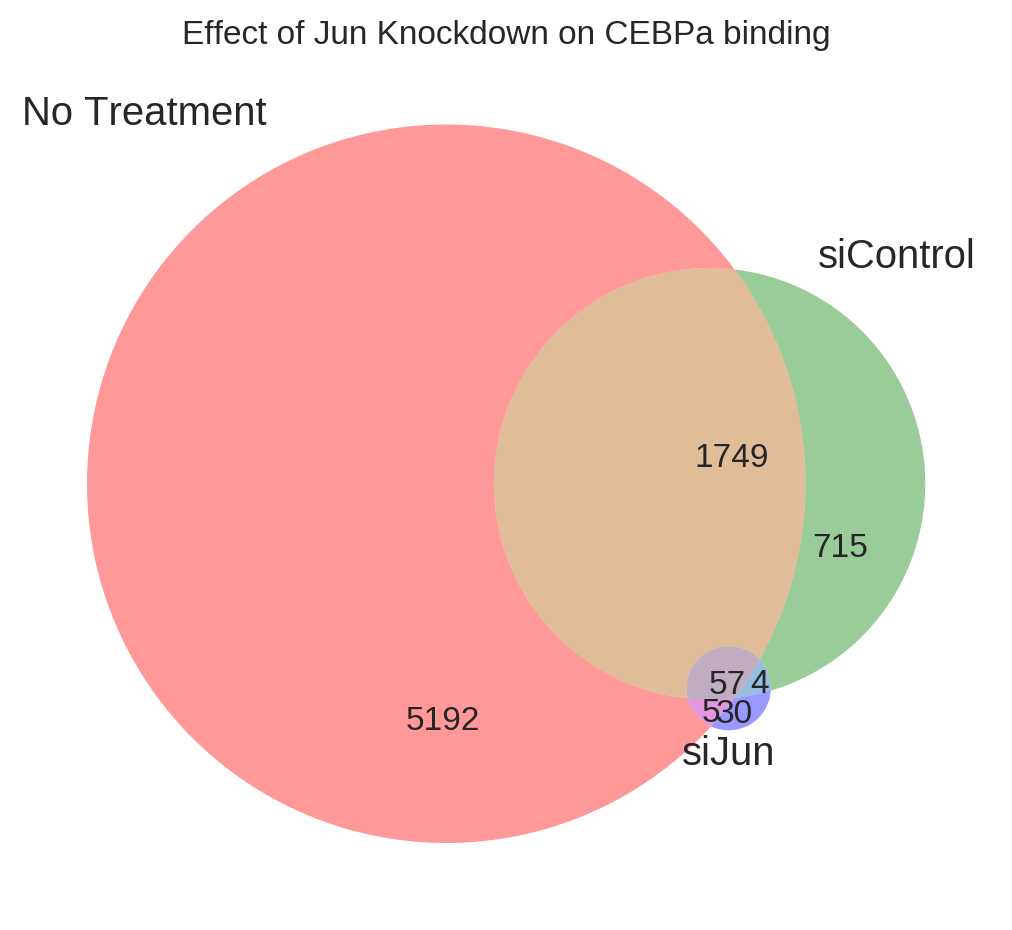

In [36]:
notx_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('CEBPa_Veh_notx')].index.values
siCtrl_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('CEBPa_Veh_siCtrl')].index.values
siJun_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('CEBPa_Veh_siJun')].index.values

matplotlib_venn.venn3([set(notx_indices), set(siCtrl_indices), set(siJun_indices)],set_labels=['No Treatment', 'siControl', 'siJun'])
plt.title('Effect of Jun Knockdown on CEBPa binding')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


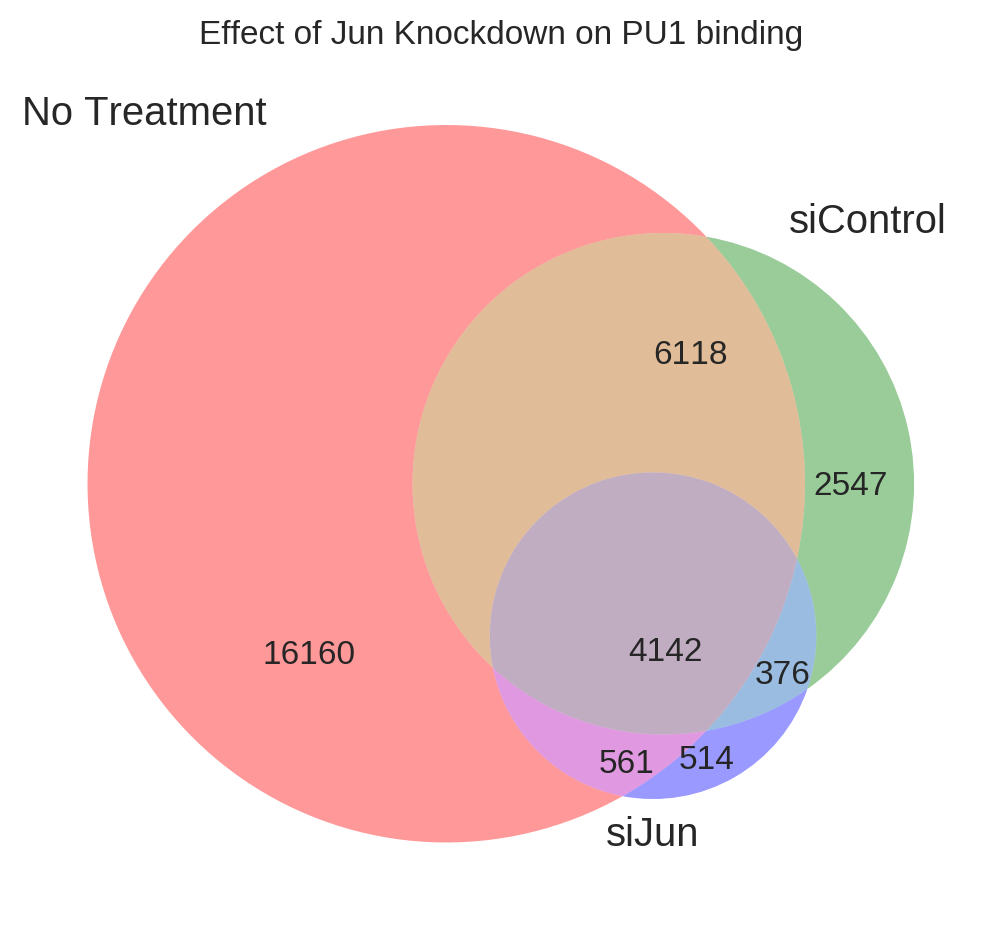

In [37]:
notx_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('PU1_Veh_notx')].index.values
siCtrl_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('PU1_Veh_siCtrl')].index.values
siJun_indices = knockdown_summary_frame[knockdown_summary_frame['Factors'].str.contains('PU1_Veh_siJun')].index.values

matplotlib_venn.venn3([set(notx_indices), set(siCtrl_indices), set(siJun_indices)],set_labels=['No Treatment', 'siControl', 'siJun'])
plt.title('Effect of Jun Knockdown on PU1 binding')

### 1d - expression of Jun, pu-1 and cebpa in vehicle under knockdown conditions

In [63]:
%%bash
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  /home/jenhan/analysis/ap1_analysis/tag_directories_rna/* >rpkm.tsv



	Tag Directories:
		/home/jenhan/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09
		/home/jenhan/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_VML_15-02-26
		/home/jenhan/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siATF3_GFEW_16-02-04
		/home/jenhan/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_sicJun_GFEW_15-10-19
		/home/jenhan/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_sicJun_GFEW_16-02-04
		/home/jenhan/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl_GFEW_15-10-30
		/home/jenhan/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siCtrl_GFEW_16-02-04
		/home/jenhan/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siFos_GFEW_15-10-19
		/home/jenhan/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-6h_siFos_GFEW_16-02-04
		/home/jenhan/analysis/ap1_analysis/tag_directories_rna/C5

In [66]:
with open('rpkm.tsv') as f:
    data=f.readlines()
header = data[0].strip()

conditions = ' '.join(['_'.join(x.split('/')[-1].replace(' FPKM','').split('_')[3:5]) for x in header.split('\t')[8:]])

In [ ]:
# !python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv ./rna_idr $conditions -p
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv ./rna_idr $conditions

In [131]:
idr_rpkm_frame = pd.read_csv('rna_idr/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = '_'.join(columns[i].split('/')[-1].split('_')[3:5])
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence'].values]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values

idr_rpkm_mean_frame = pd.DataFrame()

for treatment in idr_rpkm_frame.columns.values[8:-1]:
    if len(idr_rpkm_frame[treatment].shape) > 1:
        idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment], axis=1)



(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

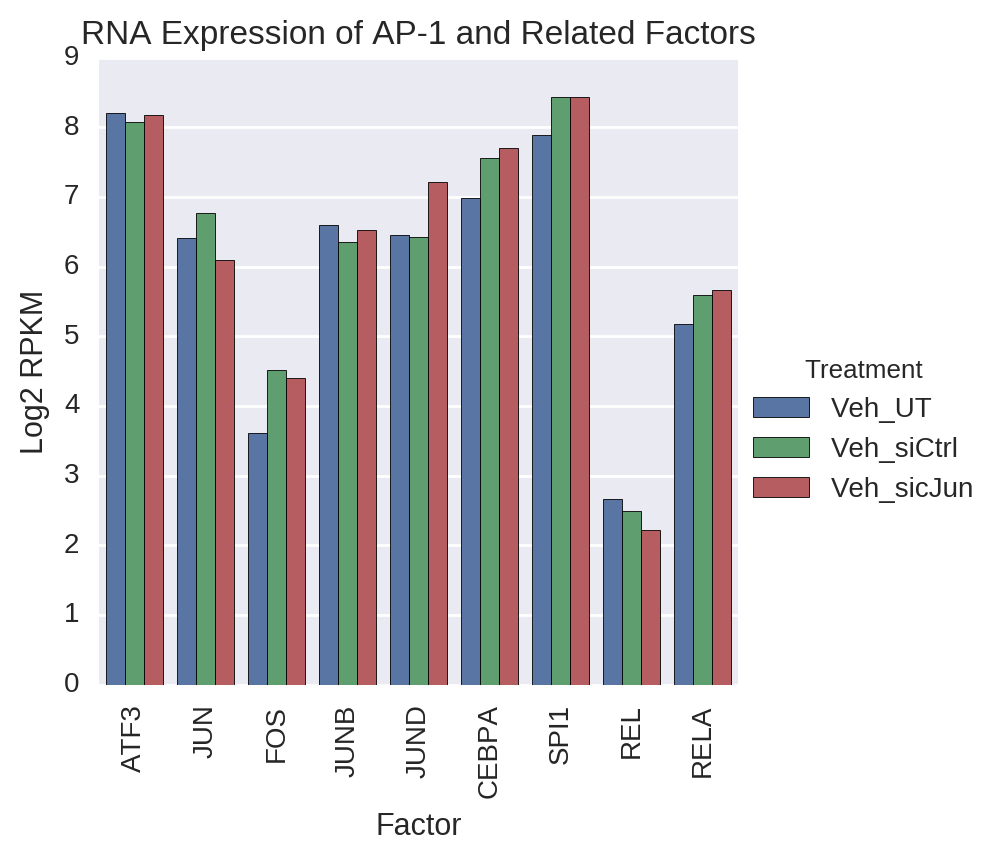

In [139]:
plottingFrame = pd.DataFrame(idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(
            ['ATF3', 'JUN', 'FOS', 'JUNB', 'JUND', 'CEBPA', 'SPI1', 'REL','RELA'])].stack())
plottingFrame['Factor'] = [x[0] for x in plottingFrame.index.values]
plottingFrame['Treatment'] = [x[1] for x in plottingFrame.index.values]
plottingFrame.columns = ['RPKM', 'Factor', 'Treatment']
plottingFrame['Log2 RPKM'] = np.log2(plottingFrame['RPKM'].values + 1)
sns.factorplot(data = plottingFrame, x='Factor', y='Log2 RPKM', hue='Treatment', kind='bar', 
               hue_order=['Veh_UT','Veh_siCtrl', 'Veh_sicJun'], 
               order = ['ATF3', 'JUN', 'FOS', 'JUNB', 'JUND', 'CEBPA', 'SPI1', 'REL','RELA']
              )
plt.title('RNA Expression of AP-1 and Related Factors')
plt.xticks(rotation=90)

### 1e - IP of cJun and PU-1 and CEBPa

Greg will do science stuff

## Figure 2 - Introduce the AP-1 Cistrome

### 2a -  Number of peaks before and after KLA treatment for PU.1, CEBPa, p65, AP-1



In [24]:
kla_factors = ['atf3', 'cjun', 'fos', 'junb', 'jund', 'cebpa', 'pu1', 'p65']


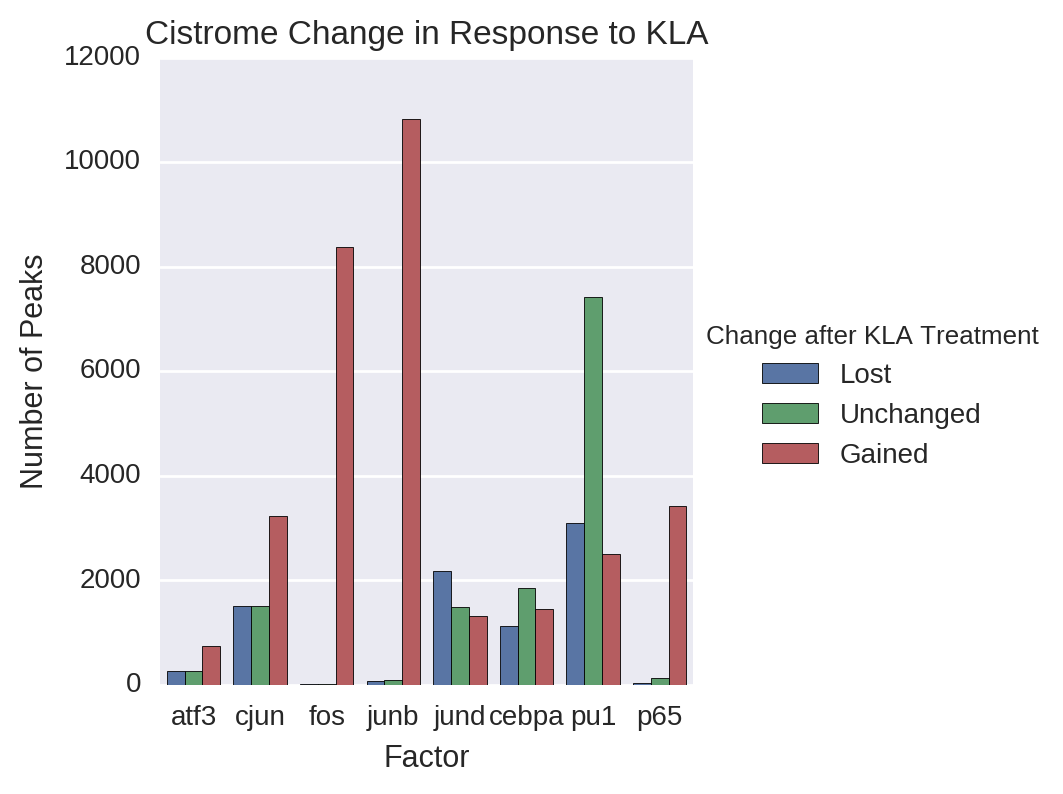

In [25]:
treatments = []
factors = []
peakCounts = []
for factor in kla_factors:
    treatments = treatments + ['Lost', 'Unchanged', 'Gained']
    factors = factors + [factor] * 3
    peakCounts.append(summary_frame[(summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')) & 
                                    ([not x for x in summary_frame['Factors'].str.contains('c57bl6_' + factor + '_kla')])
                                   ].shape[0])
    peakCounts.append(summary_frame[(summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')) & 
                                    (summary_frame['Factors'].str.contains('c57bl6_' + factor + '_kla'))].shape[0])
    peakCounts.append(summary_frame[(summary_frame['Factors'].str.contains('c57bl6_' + factor + '_kla')) & 
                                    ([not x for x in summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')])
                                   ].shape[0])   
plottingFrame = pd.DataFrame({'Factor':factors,
                             'Change after KLA Treatment': treatments,
                             'Number of Peaks': peakCounts})
sns.factorplot(data=plottingFrame, 
               x='Factor',
              y='Number of Peaks',
              hue='Change after KLA Treatment',
              kind='bar')
plt.title('Cistrome Change in Response to KLA')

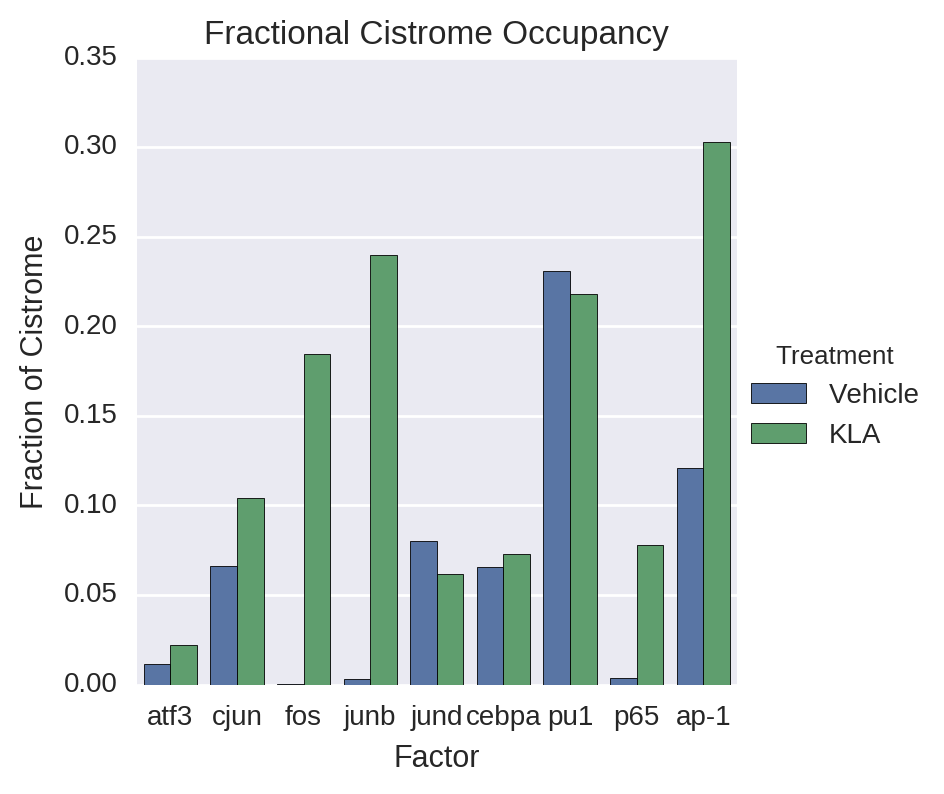

In [583]:
treatments = []
factors = []
fractions = []
for factor in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'cebpa', 'pu1', 'p65', 'ap-1']:
    treatments = treatments + ['Vehicle', 'KLA']
    factors = factors + [factor] * 2
    fractions.append(summary_frame[(summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh'))].shape[0]/summary_frame.shape[0])
    fractions.append(summary_frame[(summary_frame['Factors'].str.contains('c57bl6_' + factor + '_kla'))].shape[0]/summary_frame.shape[0])   
plottingFrame = pd.DataFrame({'Factor':factors,
                             'Treatment': treatments,
                             'Fraction of Cistrome': fractions})
sns.factorplot(data=plottingFrame, 
               x='Factor',
              y='Fraction of Cistrome',
              hue='Treatment',
              kind='bar')
plt.title('Fractional Cistrome Occupancy')

### 2b - Expression of AP-1 family members

In [31]:
%%bash
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  /home/jenhan/analysis/ap1_analysis/tag_directories_rna/*UT*/> rpkm.tsv

%%bash
python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv ./rna_idr KLA KLA Veh Veh

Process is interrupted.


In [111]:
idr_rpkm_frame = pd.read_csv('rna_idr/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = '_'.join(columns[i].split('/')[-1].split('_')[3:5])
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence'].values]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values

idr_rpkm_mean_frame = pd.DataFrame()

for treatment in idr_rpkm_frame.columns.values[8:-1]:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment].astype(float), axis=1)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

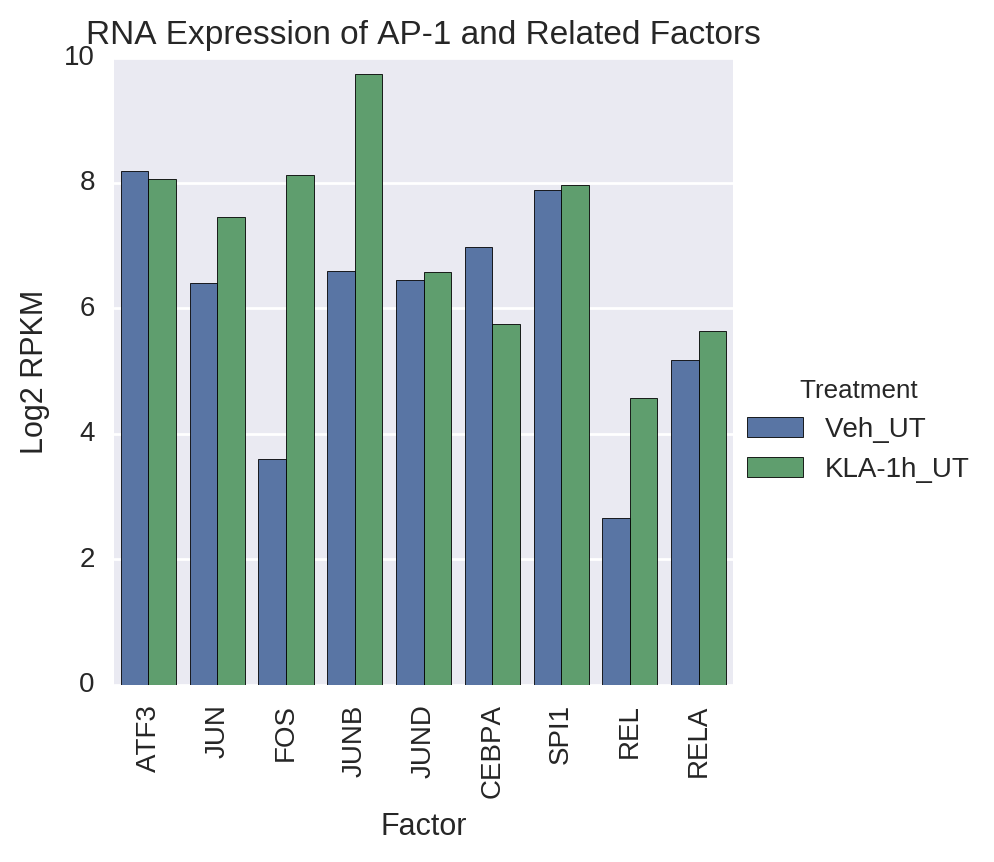

In [113]:
plottingFrame = pd.DataFrame(idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(
            ['ATF3', 'JUN', 'FOS', 'JUNB', 'JUND', 'CEBPA', 'SPI1', 'REL','RELA'])].stack())
plottingFrame['Factor'] = [x[0] for x in plottingFrame.index.values]
plottingFrame['Treatment'] = [x[1] for x in plottingFrame.index.values]
plottingFrame.columns = ['RPKM', 'Factor', 'Treatment']
plottingFrame['Log2 RPKM'] = np.log2(plottingFrame['RPKM'].values + 1)
sns.factorplot(data = plottingFrame, x='Factor', y='Log2 RPKM', hue='Treatment', kind='bar', 
               hue_order=['Veh_UT','KLA-1h_UT'], 
               order = ['ATF3', 'JUN', 'FOS', 'JUNB', 'JUND', 'CEBPA', 'SPI1', 'REL','RELA']
              )
plt.title('RNA Expression of AP-1 and Related Factors')
plt.xticks(rotation=90)


### 2c -  Overlap between all peaks before and after KLA treatment - heatmap (simpler) or clustermap (shows more than pairwise interactions). Or Karnaugh Map - what has to be emphasized is that while there are 2 clusters of PU-1 peaks - with and without AP-1. There are distinct subsets of AP-1 members

In [11]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']

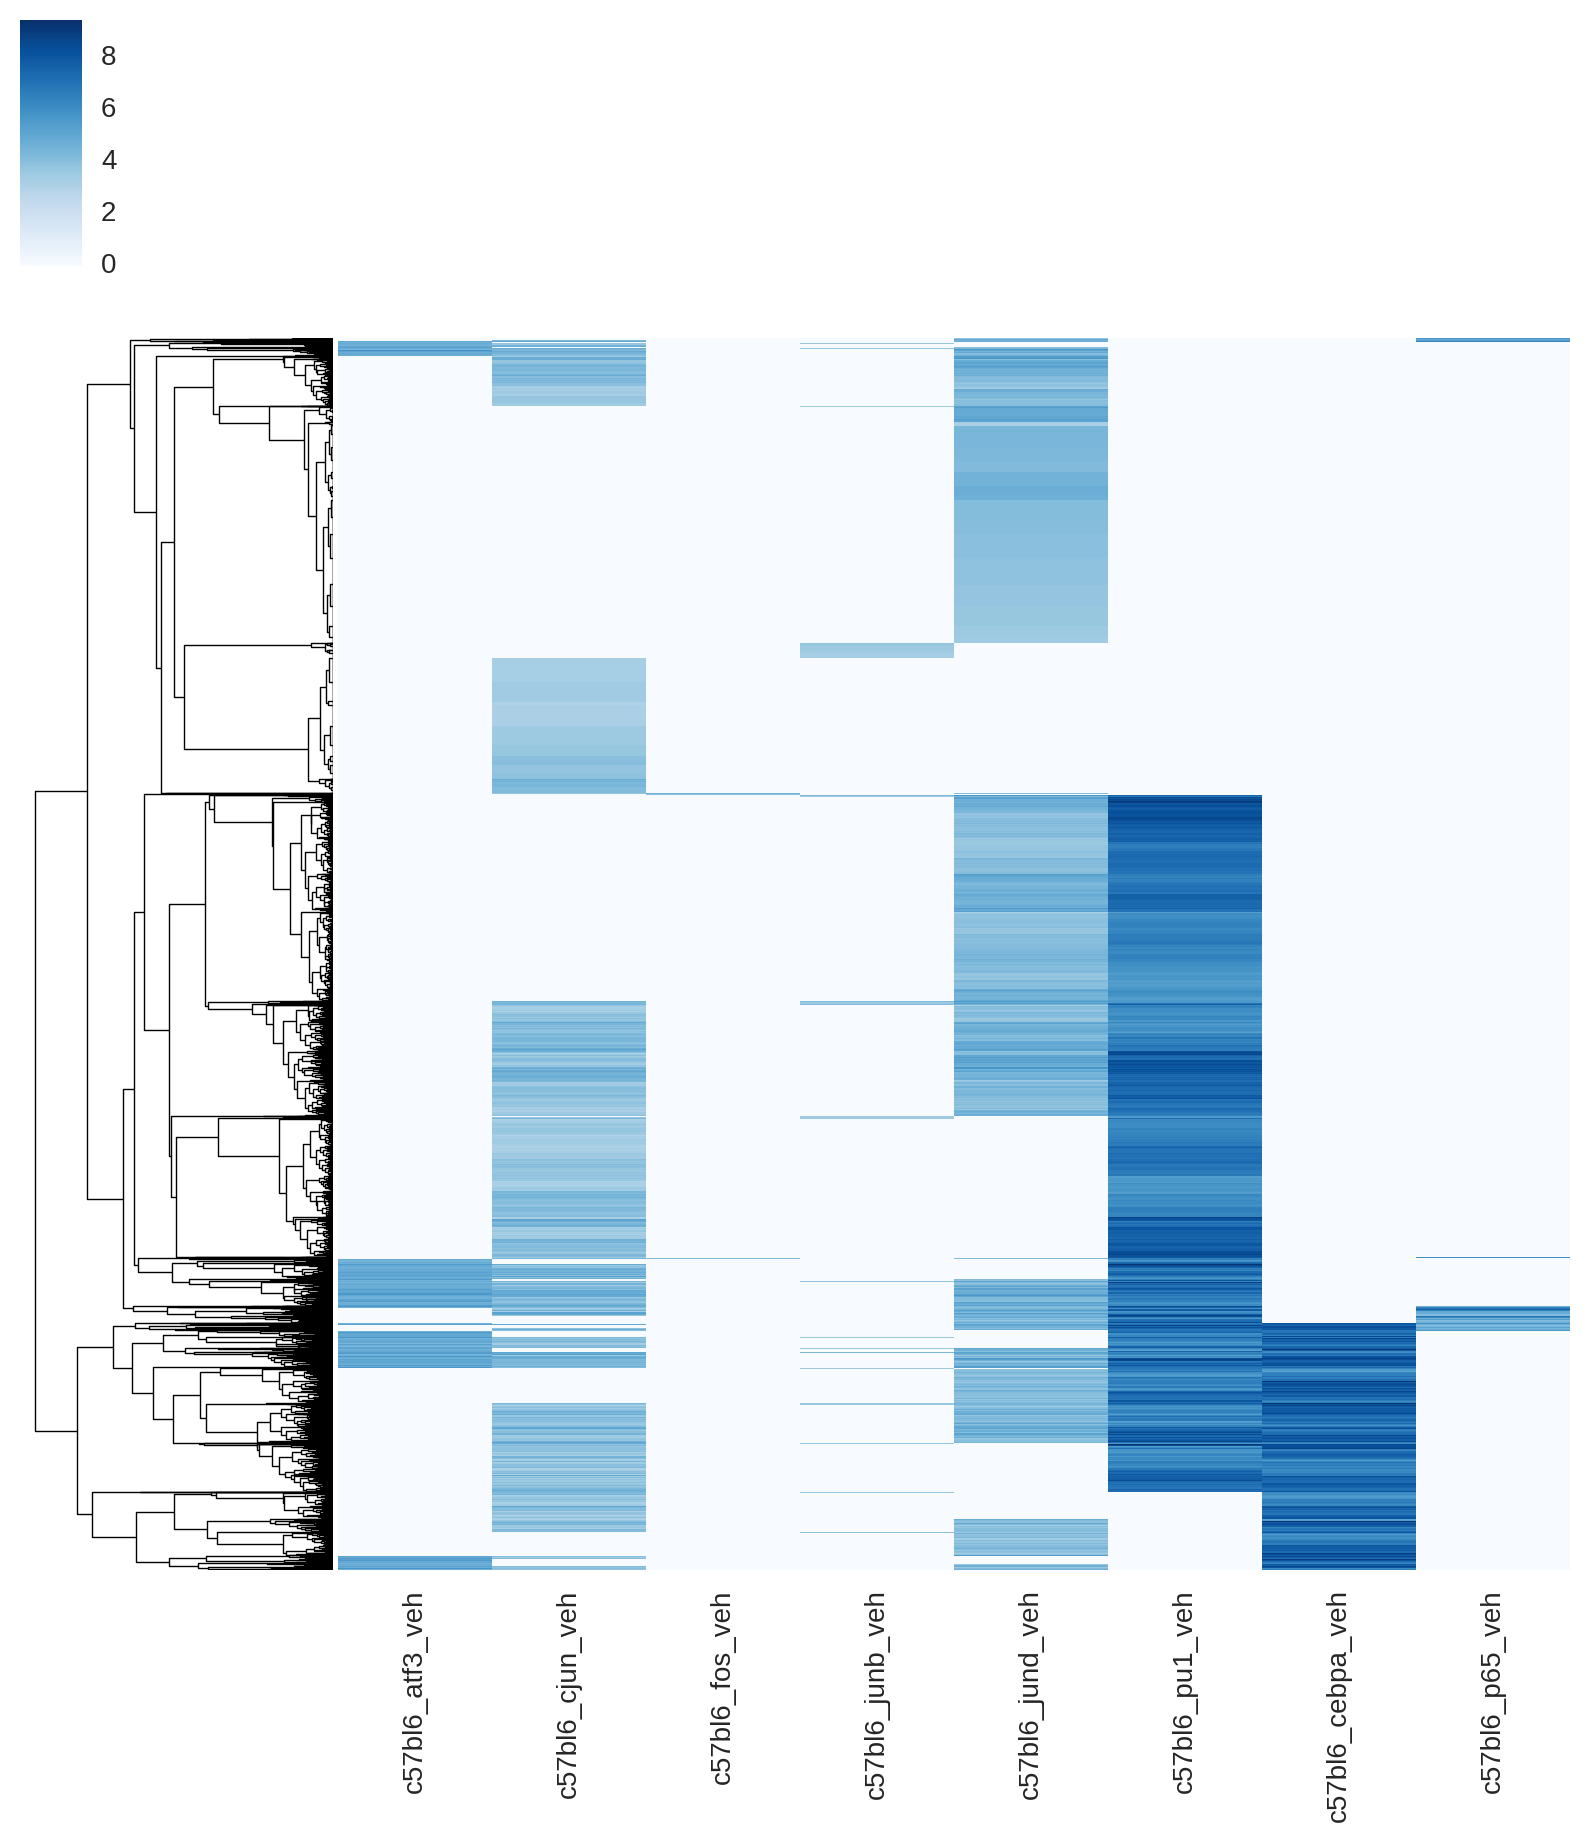

In [26]:
### hierarchically cluster peaks in vehicle conditions and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + 
                     sns.color_palette("Set1") + 
                     sns.color_palette("Set2") + 
                     sns.color_palette("husl") +
                     sns.color_palette("Paired")
                    ))

indices = summary_frame[(summary_frame['Factors'].str.contains('_veh'))].index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if '_veh' in x and not 'atac' in x]]
# data = data[data.max(axis=1) > 0.0]
data = data[data[['c57bl6_'+x+'_veh' for x in ap1_members]].max(axis=1) > 0.0]
data = data[['c57bl6_'+x+'_veh' for x in ['atf3','cjun','fos','junb','jund','pu1','cebpa','p65']]]


logged_data = np.log2(data+1)

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          cmap='Blues',
          col_cluster=False)



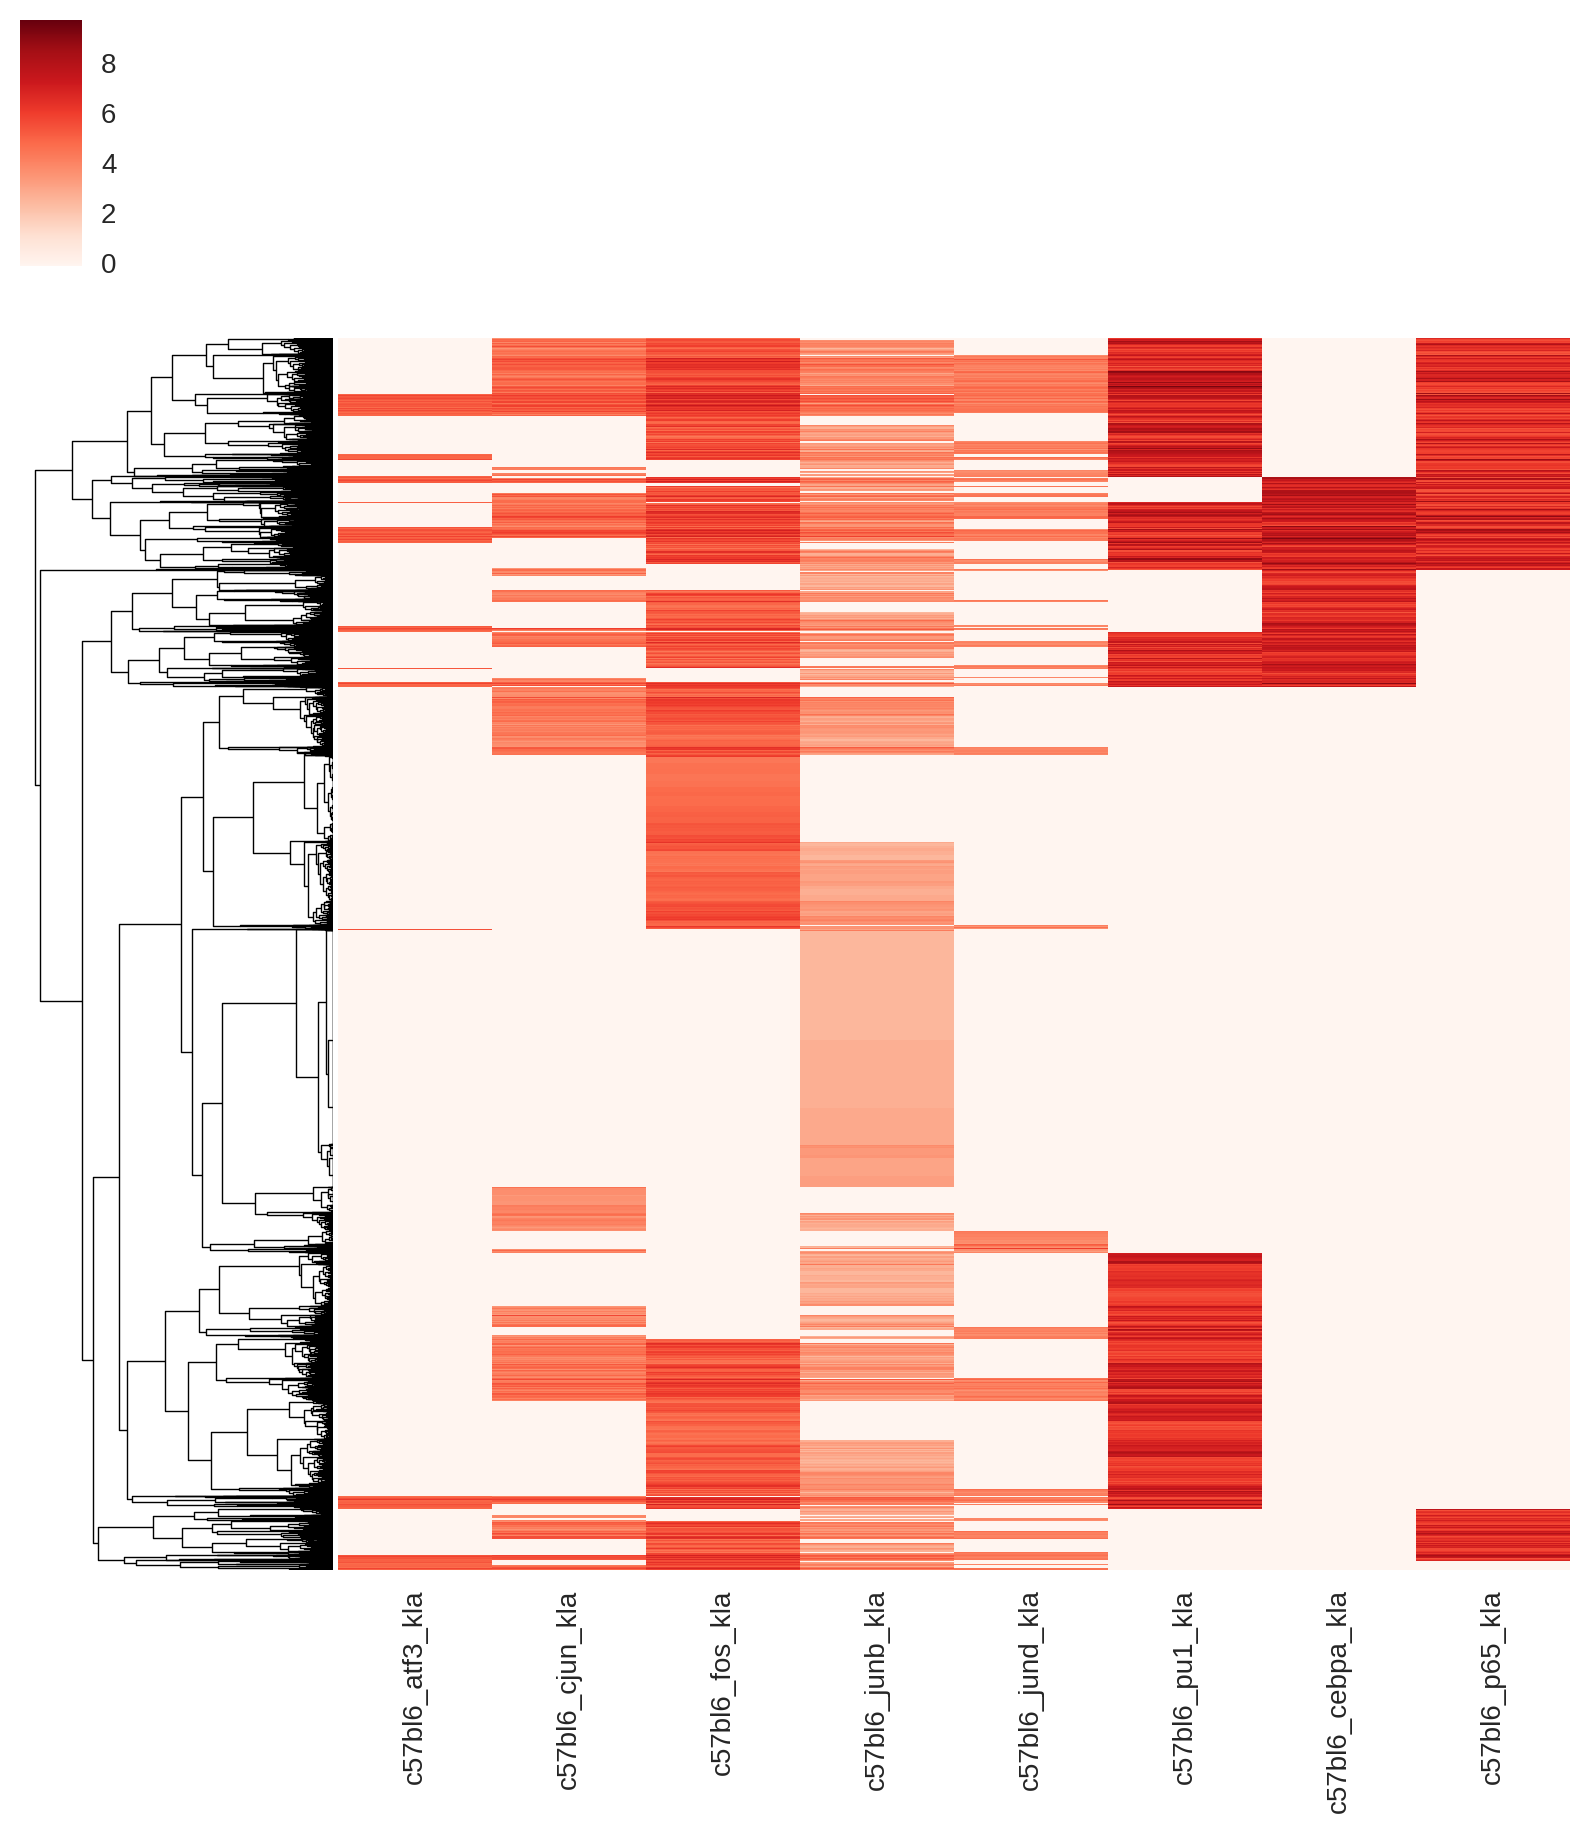

In [27]:
### hierarchically cluster peaks in KLA condition and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

indices = summary_frame[(summary_frame['Factors'].str.contains('_kla'))].index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if '_kla' in x and not 'atac' in x]]
# data = data[data.max(axis=1) > 0.0]
data = data[data[['c57bl6_'+x+'_kla' for x in ap1_members]].max(axis=1) > 0.0]
data = data[['c57bl6_'+x+'_kla' for x in ['atf3','cjun','fos','junb','jund','pu1','cebpa','p65']]]
logged_data = np.log2(data+1)

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          cmap='Reds',
          col_cluster=False)


In [28]:
data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
# data = data[data.max(axis=1) > 0.0]
data = data[data[['c57bl6_'+x+'_veh' for x in ap1_members]+['c57bl6_'+x+'_kla' for x in ap1_members]].max(axis=1) > 0.0]
veh_data = data[[x for x in data.columns if '_veh' in x and not 'atac' in x]]
kla_data = data[[x for x in data.columns if '_kla' in x and not 'atac' in x]]
fold_frame = np.log2(pd.DataFrame((kla_data.values+0.1)).divide((veh_data.values+0.1))+0.0000001)
fold_frame.columns = [x.replace('_kla','').replace('c57bl6_','') for x in data.columns if '_kla' in x and not 'atac' in x]

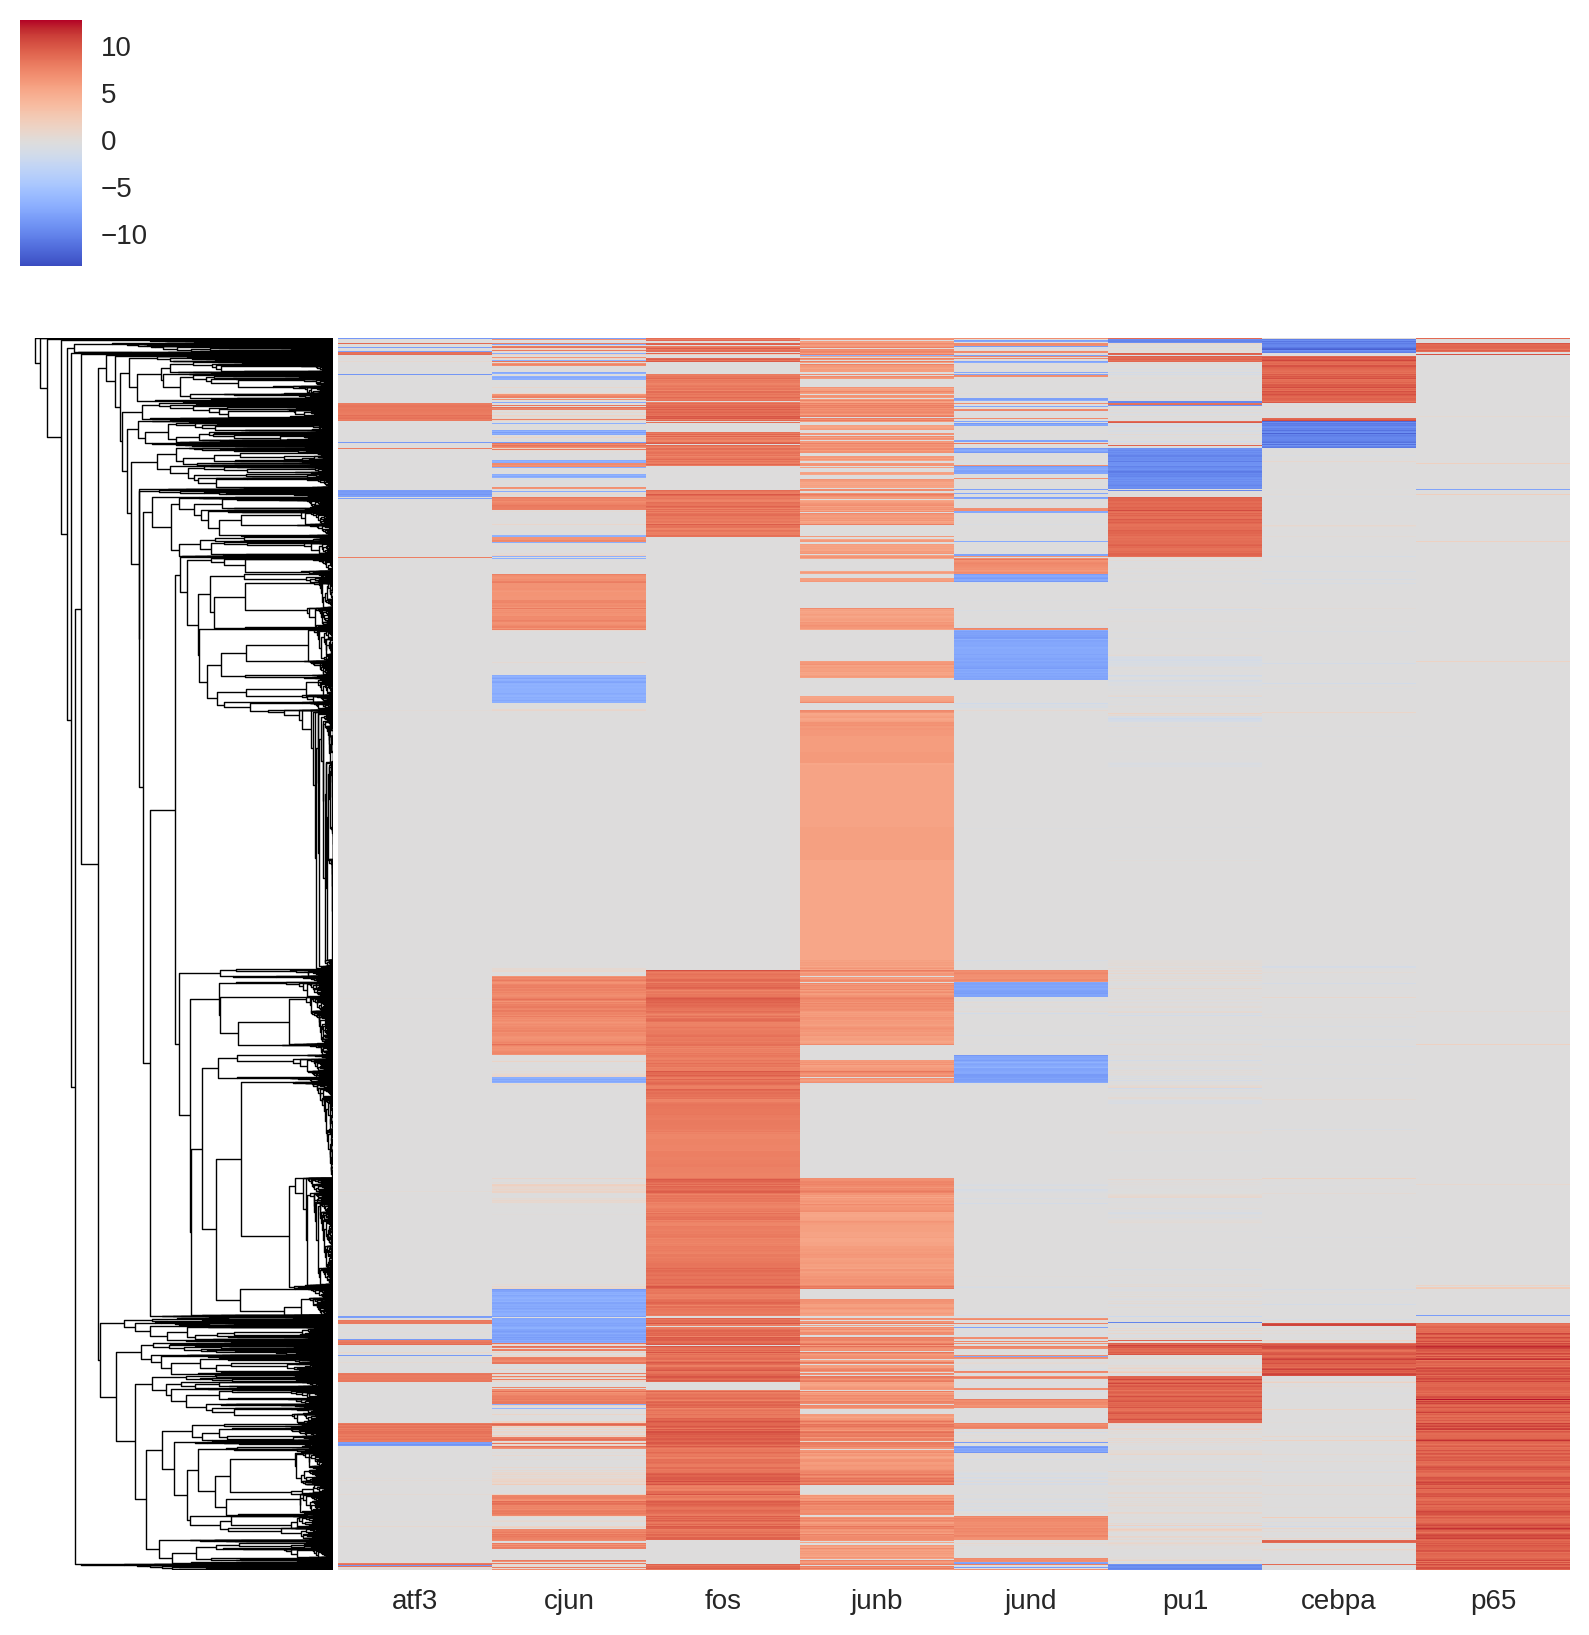

In [29]:
cg = sns.clustermap(fold_frame[['atf3','cjun','fos','junb','jund','pu1','cebpa','p65']],
          yticklabels=False,
          xticklabels=True,
          col_cluster=False,
          cmap='coolwarm')

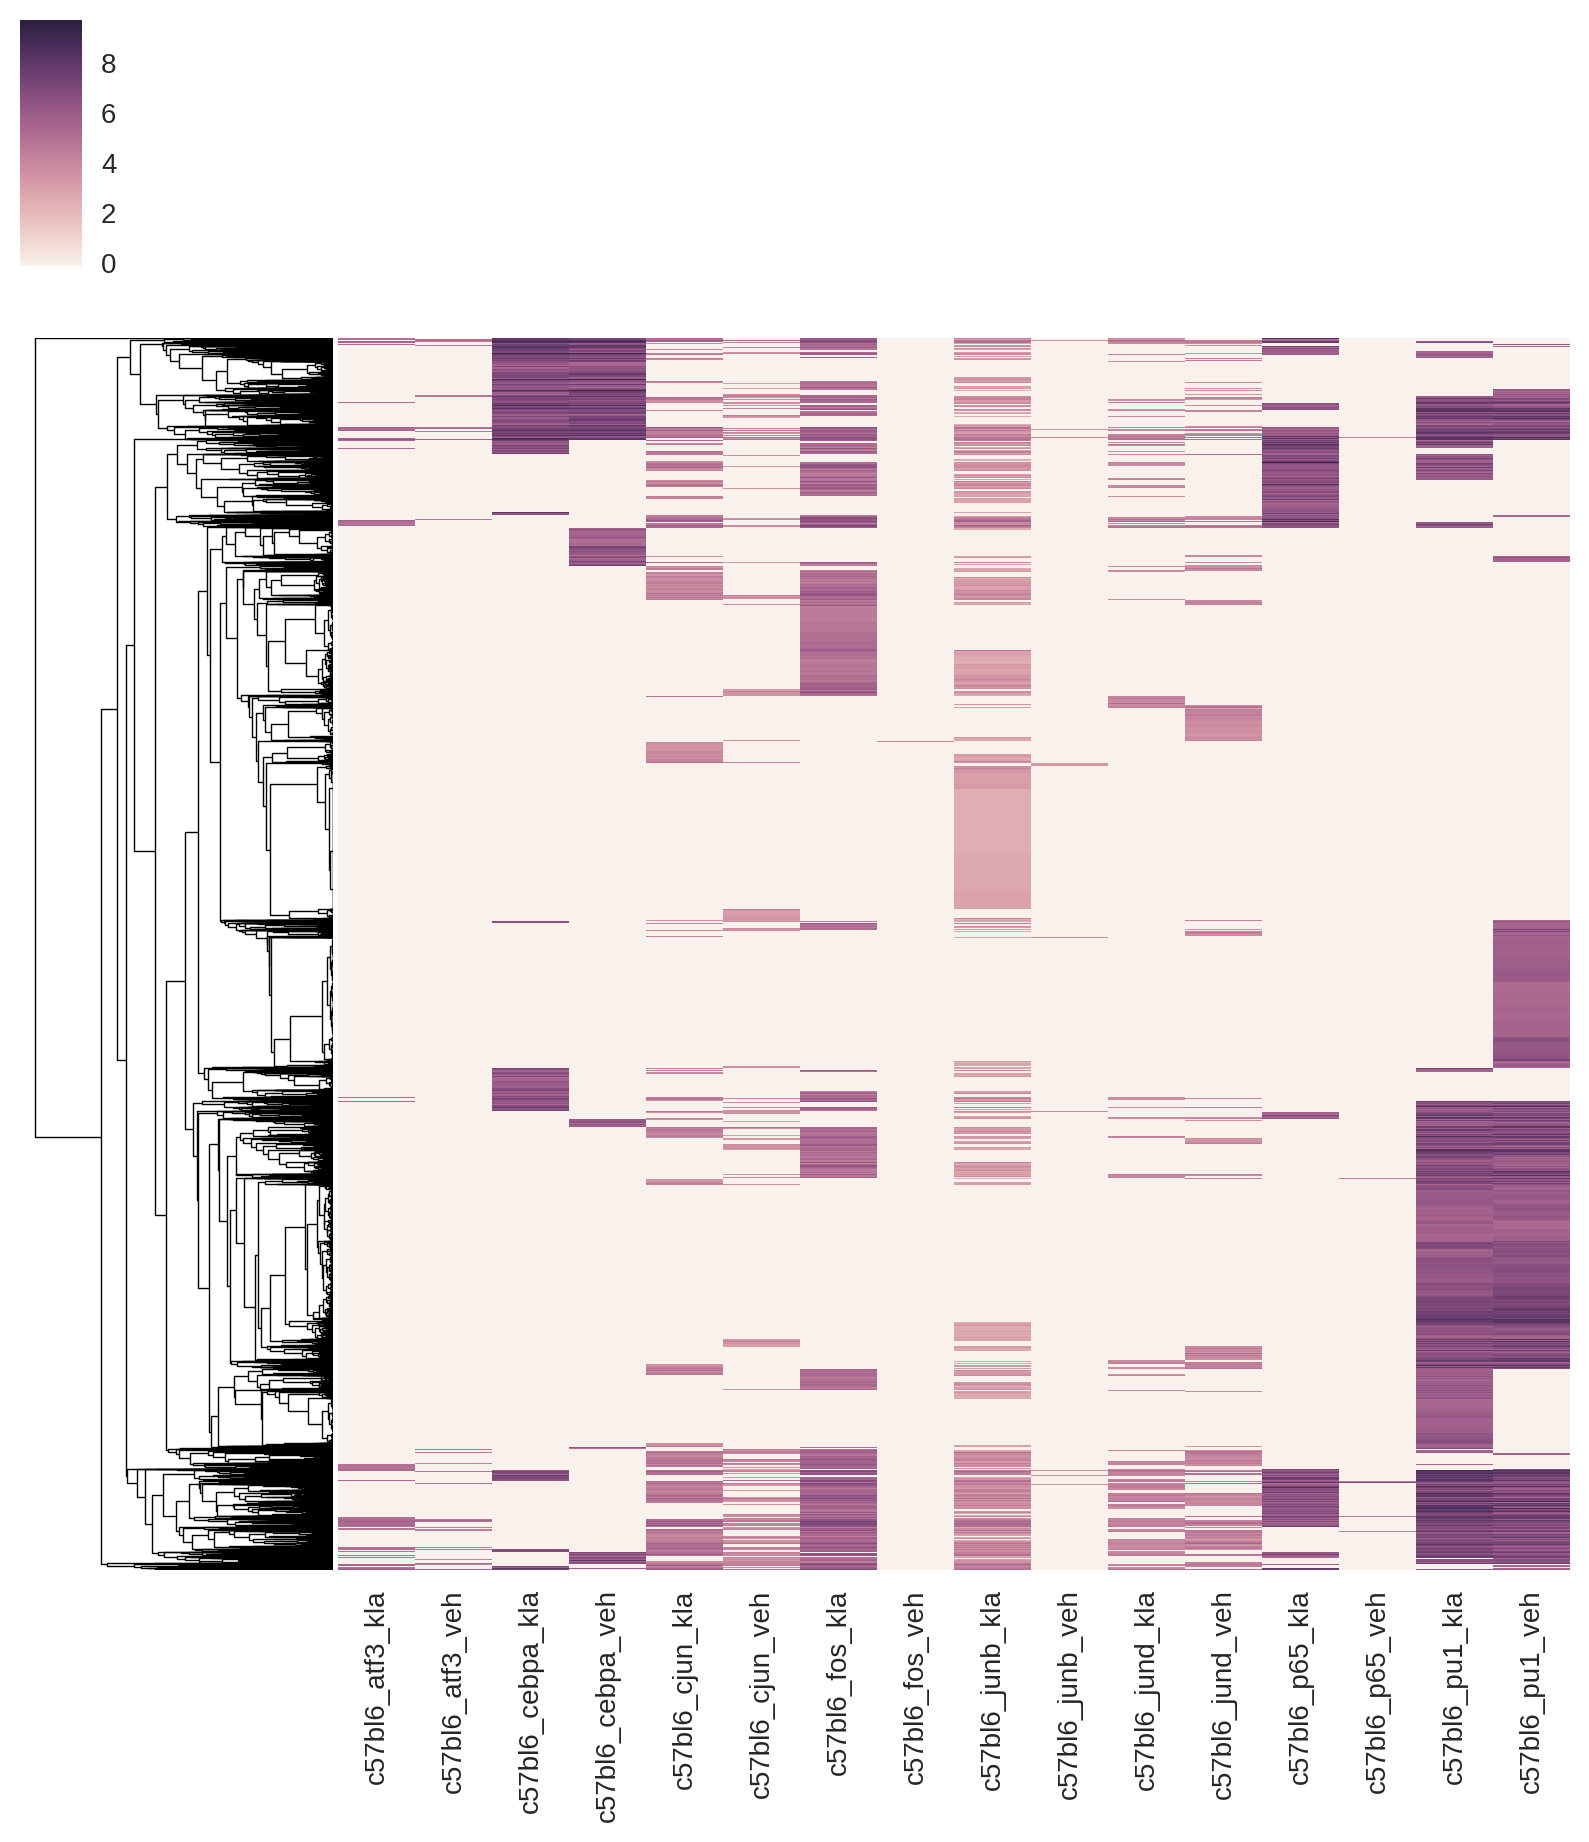

In [30]:
### hierarchically cluster peaks in KLA condition and do de novo motif analysis on each cluster ###
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

indices = summary_frame.index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
# data = data[data[['c57bl6_'+x+'_kla' for x in ap1_members]].max(axis=1) > 0.0]
# data = data[['c57bl6_'+x+'_kla' for x in ['atf3','cjun','fos','junb','jund','pu1','cebpa','p65']]]
logged_data = np.log2(data+1)

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          col_cluster=False)



In [225]:
### generate R code for chow-ruskey diagram ###
veh_script = open('veh_chowRuskey_script.R','w')
veh_script.write('library(Vennerable);\n')
# get peak IDS for peaks
for f in _factors:
    indices = summary_frame[summary_frame['c57bl6_'+f+'_veh'] > 0].index.values
    veh_script.write(f + '_ids <- list(' + ','.join(["'"+x+"'" for x in indices]) + ');\n')
    veh_script.write(f+'_ids.name <-"'+f+'";\n')
#     print(f + '_ids <- list(' + ','.join(['"'+x+'"' for x in indices]) + ');')
veh_script.write('veh_ids <- list(' + ','.join([x+'_ids' for x in _factors]) + ');\n')
veh_script.write('veh_venn_object <- Venn(veh_ids);\n')
veh_script.write('pdf("veh_chowRuskey.pdf")\n')
veh_script.write('plot(veh_venn_object,type="ChowRuskey")\n')
veh_script.write('dev.off()')
veh_script.close()

In [226]:
### generate R code for chow-ruskey diagram ###
veh_script = open('kla_chowRuskey_script.R','w')
veh_script.write('library(Vennerable);\n')
# get peak IDS for peaks
for f in _factors:
    indices = summary_frame[summary_frame['c57bl6_'+f+'_kla'] > 0].index.values
    veh_script.write(f + '_ids <- list(' + ','.join(["'"+x+"'" for x in indices]) + ');\n')
    veh_script.write(f+'_ids.name <-"'+f+'";\n')
#     print(f + '_ids <- list(' + ','.join(['"'+x+'"' for x in indices]) + ');')
veh_script.write('kla_ids <- list(' + ','.join([x+'_ids' for x in _factors]) + ');\n')
veh_script.write('kla_venn_object <- Venn(kla_ids);\n')
veh_script.write('pdf("kla_chowRuskey.pdf")\n')
veh_script.write('plot(kla_venn_object,type="ChowRuskey")\n')
veh_script.write('dev.off()')
veh_script.close()

## Figure 3 - Motifs that coordinate binding of individual factors

### 3a - workflow of motif analysis pipeline and prediction scheme

### 3b - Predictive performance for each factor (bar plot). Or a heatmap (1 axis shows the fraction of samples used for training, the other axis shows each factor, color shows predictive ability)

In [253]:
### test predictive ability with different test fraction sizes
factor_auc_dict = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in [x for x in _factors if not 'atac' in x]:
    factor_auc_dict[factor] = []
    print(factor)
    for test_size in [0.1, 0.5, 0.9]:#np.arange(0.1,1.0,0.1):
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)


        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = test_size, tolerance = 0.01)
        print('test fraction:',test_size, 'num training features', len(training_features), 'num test features', len(test_features))


        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
      
        fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc_lr = auc(fpr_lr, tpr_lr)
        factor_auc_dict[factor].append(roc_auc_lr)

auc_frame = pd.DataFrame(factor_auc_dict)
auc_frame.index = [0.1, 0.5, 0.9]#np.arange(0.1,1.0,0.1)

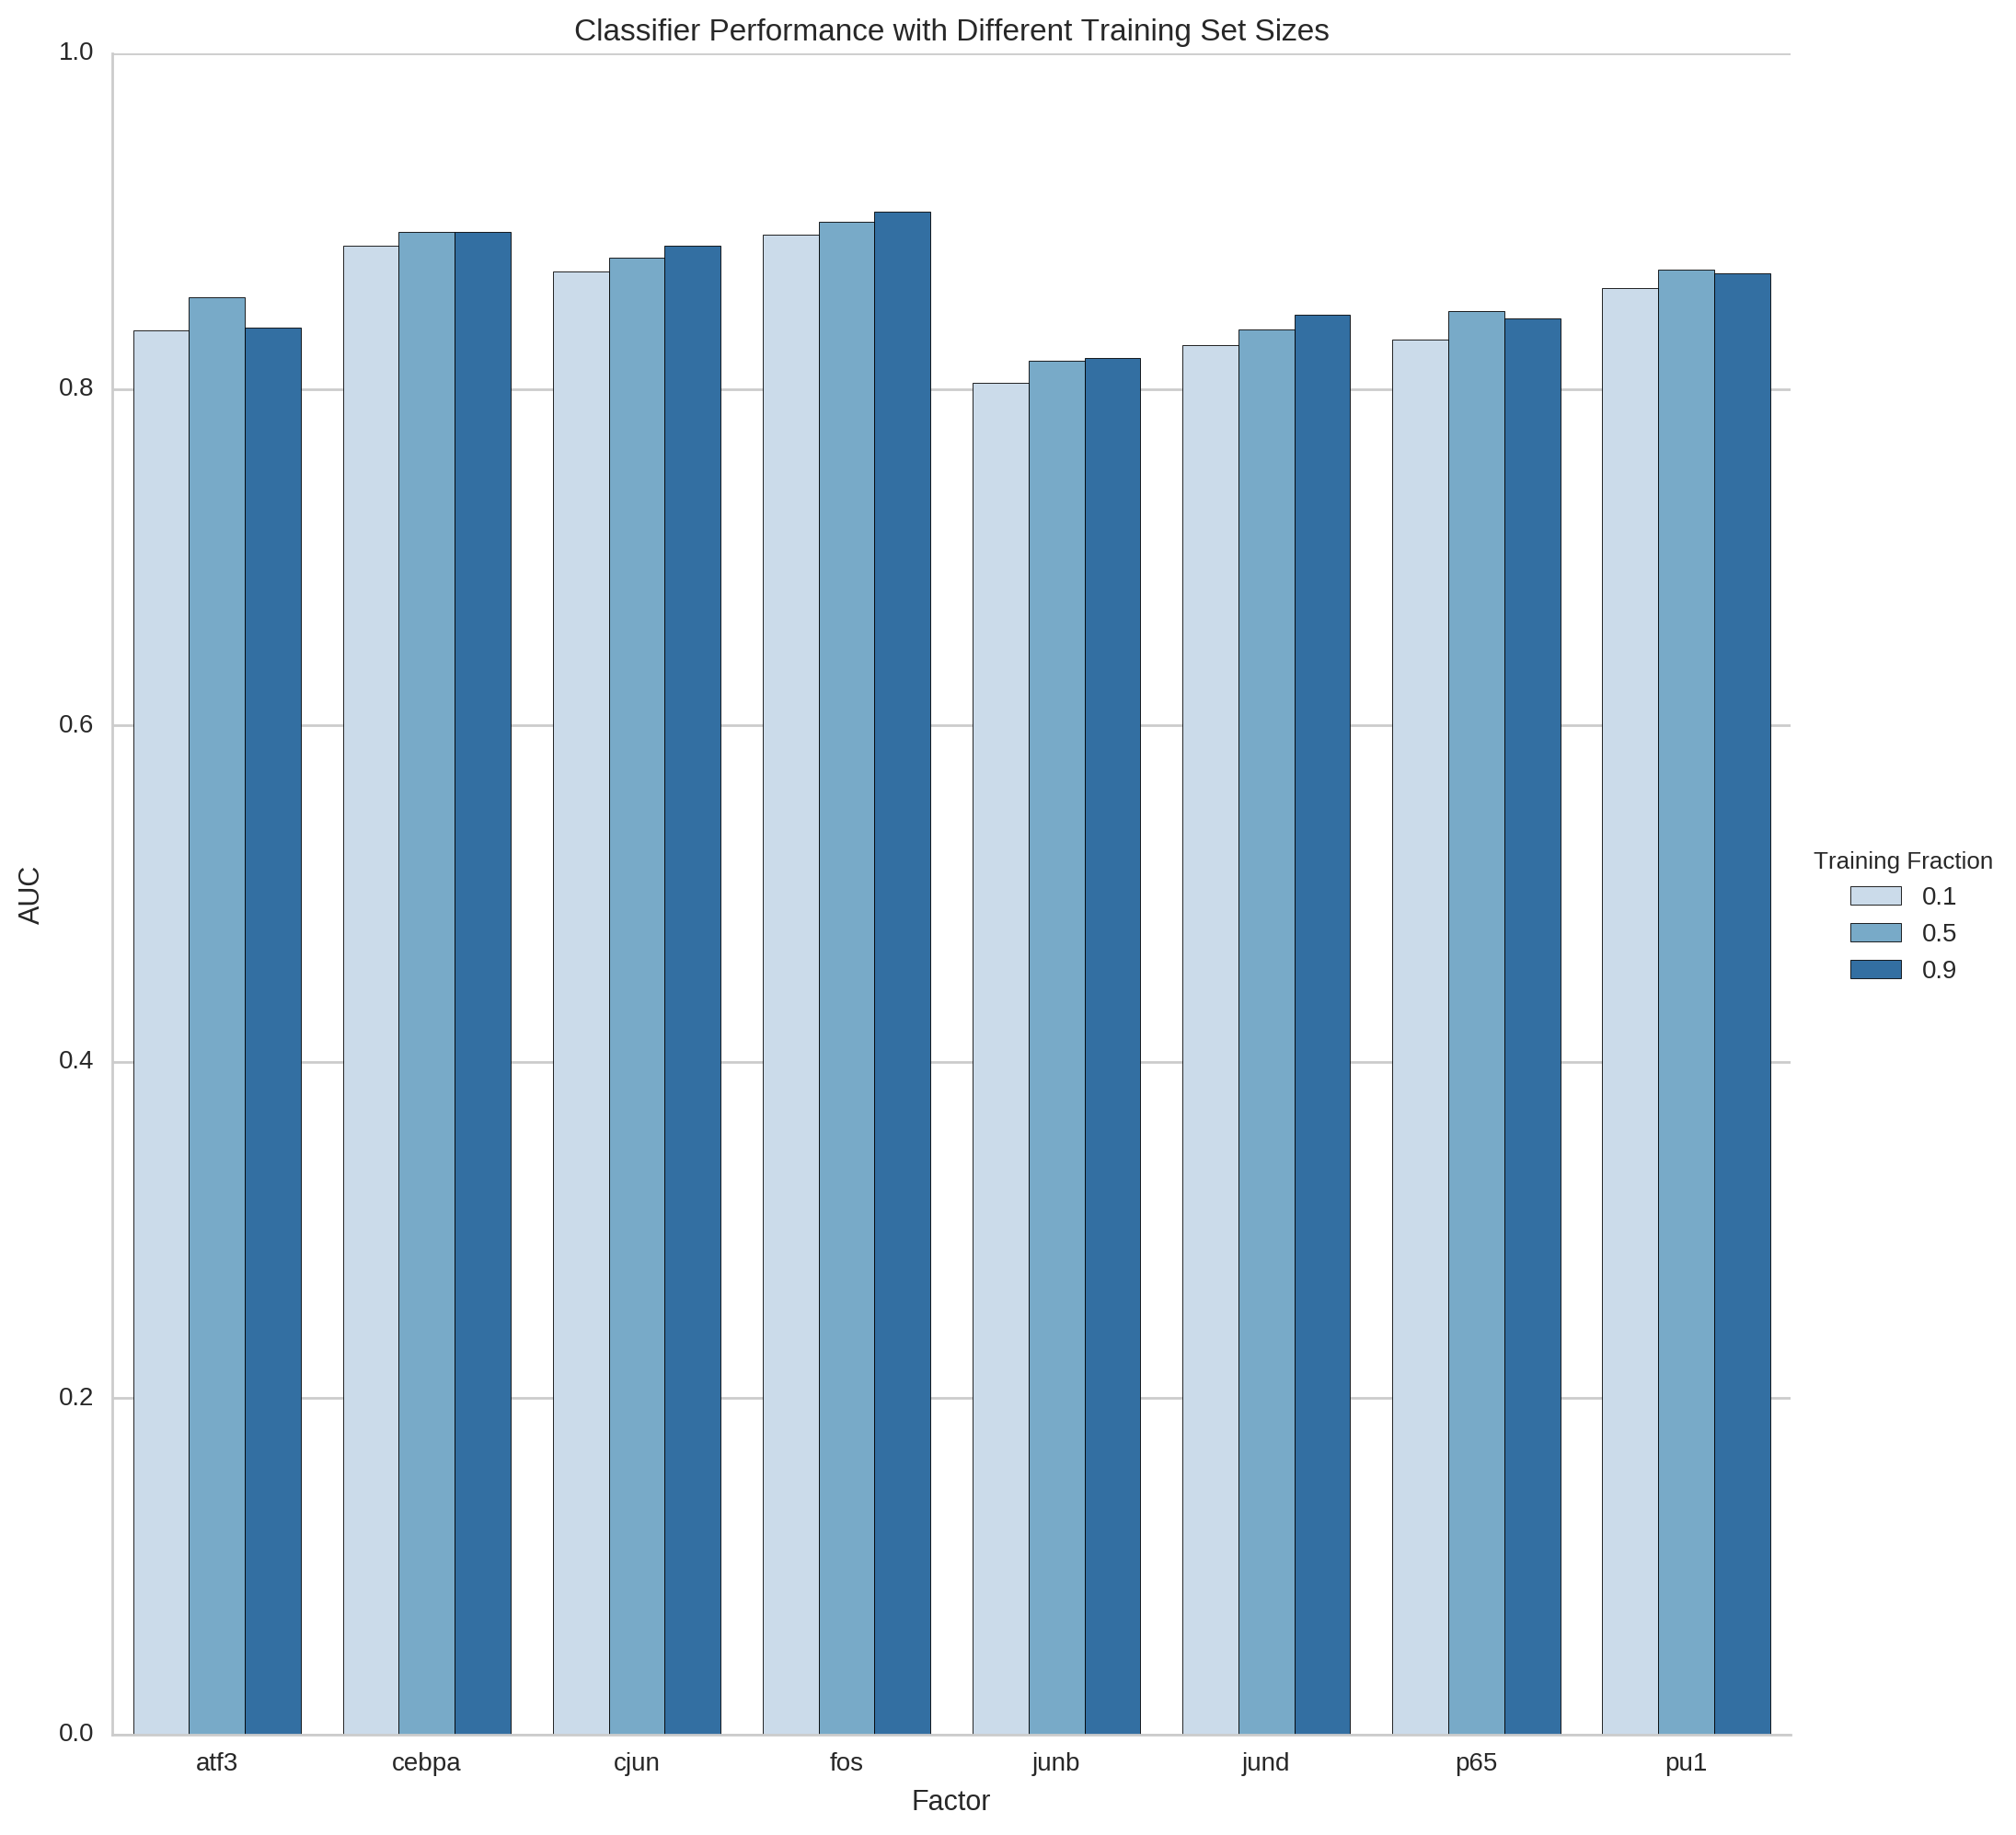

In [254]:
stacked_frame = pd.DataFrame(auc_frame.stack())
stacked_frame['Factor'] = [x[1] for x in stacked_frame.index.values]
stacked_frame['Training Fraction'] = [np.round(1- x[0],3) for x in stacked_frame.index.values]
stacked_frame.columns = ['AUC', 'Factor', 'Training Fraction']
stacked_frame.index = range(stacked_frame.shape[0])
with sns.axes_style('whitegrid'):
    sns.factorplot(data=stacked_frame[stacked_frame['Training Fraction'].isin([0.1,0.5, 0.9])], 
                   x='Factor', y='AUC', hue='Training Fraction', size=10, kind='bar', palette='Blues')
    plt.ylim(0,1)
    plt.title('Classifier Performance with Different Training Set Sizes')

### 3c - Weights for all peaks (vehicle or KLA done seperately) as a heatmap, showing which motifs are important for each factor

In [188]:
### for all peaks in vehicle 
factor_coeff_dict = {}
factor_auc_dict_all = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('veh'))].index.values
# factors = ['atf3', 'cjun', 'jund','cebpa', 'pu1']
# factors = ['atf3', 'cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
factors = ['ap-1', 'cebpa', 'pu1', 'p65']
for factor in factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_veh')
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_veh = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh = coefficients_frame_veh[factors]
coefficients_frame_veh.index = normed_motif_frame.columns.values


total: 18554 filtered: 15116 true gc: 0.49993 false gc: 0.48993 difference: 0.00999
ap-1 0.717874756164
total: 18554 filtered: 15348 true gc: 0.46476 false gc: 0.47476 difference: 0.01
cebpa 0.892191006045
total: 18554 filtered: 17170 true gc: 0.47551 false gc: 0.48546 difference: 0.00995
pu1 0.849484527488
total: 18554 filtered: 11053 true gc: 0.51953 false gc: 0.50954 difference: 0.00999
p65 0.750094048275


In [189]:
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
significant_motifs_veh = set()
for factor in coefficients_frame_veh.columns.values:
    weights = coefficients_frame_veh[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_veh.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits

ap-1 -0.623339129159 0.768666210378
cebpa -1.63217258595 1.7257886673
pu1 -1.12263377306 1.28992183466
p65 -0.894725963031 1.00735902359


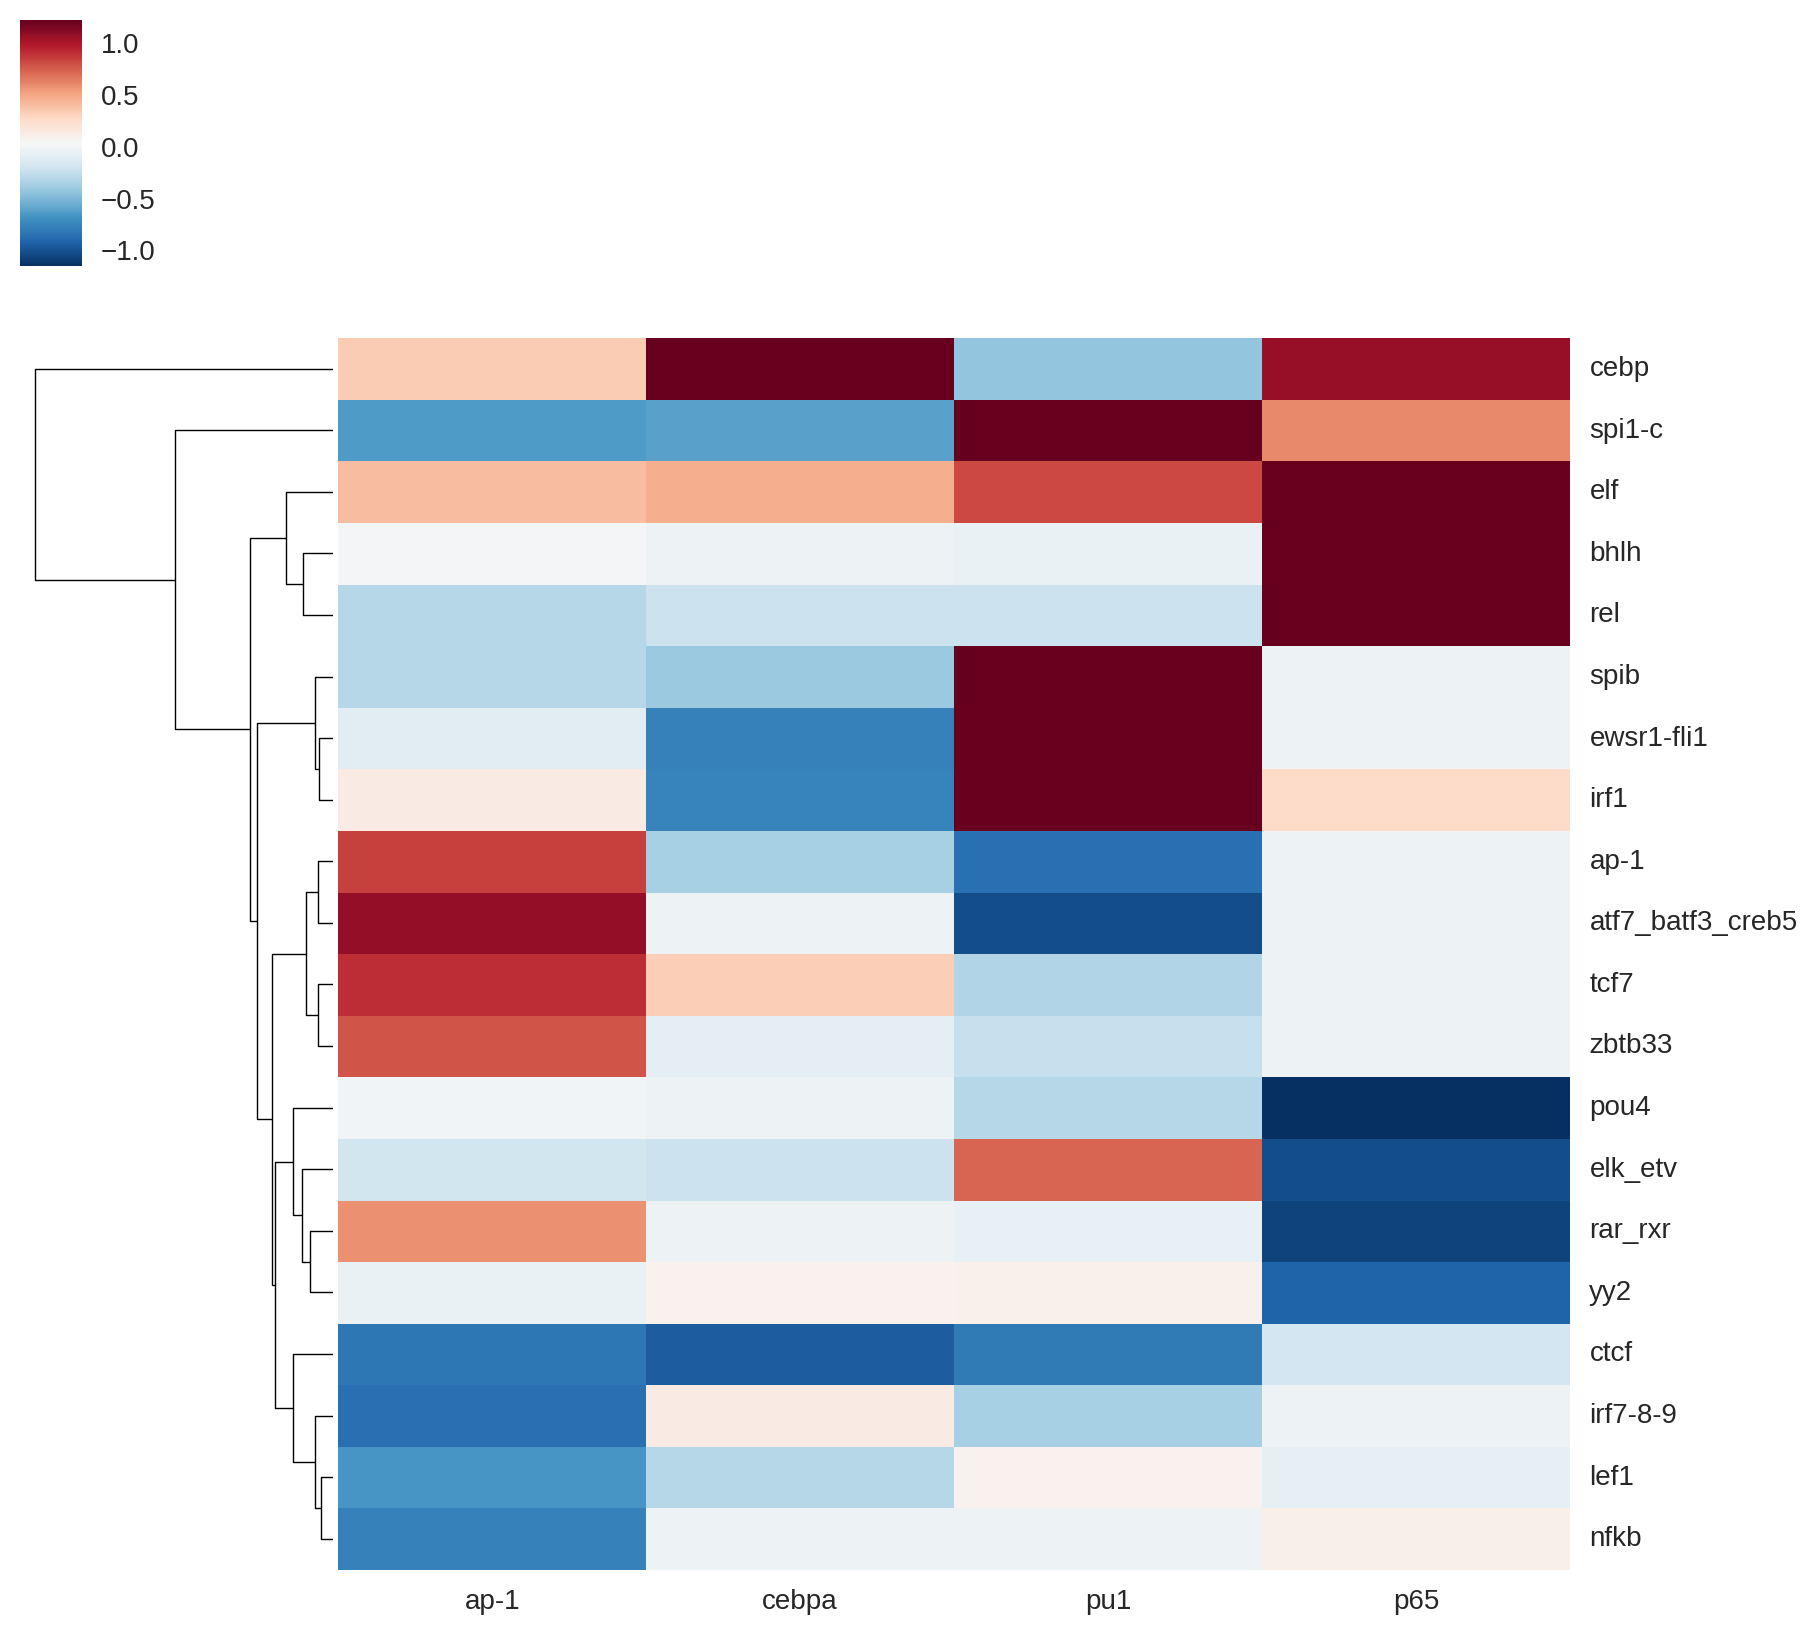

In [190]:
threshold = 2.5
coeff_std = np.std(coefficients_frame_veh.values.flatten())
coeff_mean = np.mean(coefficients_frame_veh.values.flatten())
cg = sns.clustermap(coefficients_frame_veh[coefficients_frame_veh.index.isin(significant_motifs_veh)],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=False,annot_kws={"size": 8},
                    col_cluster=False
                )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

In [183]:
### for all peaks in kla 
factor_coeff_dict = {}
factor_auc_dict_all = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('kla'))].index.values
# factors = ['atf3', 'cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
factors = ['ap-1', 'cebpa', 'pu1', 'p65']

for factor in factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_kla')
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_kla = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla = coefficients_frame_kla[factors]
coefficients_frame_kla.index = normed_motif_frame.columns.values



threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
significant_motifs_kla = set()
for factor in coefficients_frame_kla.columns.values:
    weights = coefficients_frame_kla[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_kla.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits
#     sns.distplot(weights)
#     for pos in [mean, mean-std, mean+std, mean+2*std, mean-2*std]:
#         plt.axvline(pos)
#     plt.title(factor)
    
#     plt.show()
#     print(factor)



total: 25337 filtered: 24793 true gc: 0.48847 false gc: 0.47847 difference: 0.01
ap-1 0.792978520935
total: 25337 filtered: 19982 true gc: 0.46209 false gc: 0.47209 difference: 0.01
cebpa 0.890430146832
total: 25337 filtered: 24194 true gc: 0.47719 false gc: 0.48717 difference: 0.00998
pu1 0.84940397397
total: 25337 filtered: 25337 true gc: 0.48818 false gc: 0.48219 difference: 0.00599
p65 0.834714277475
ap-1 -0.779820441989 0.901092994639
cebpa -1.46381436931 1.59711349915
pu1 -0.857217572857 1.12349567781
p65 -0.812941283798 1.01543327048


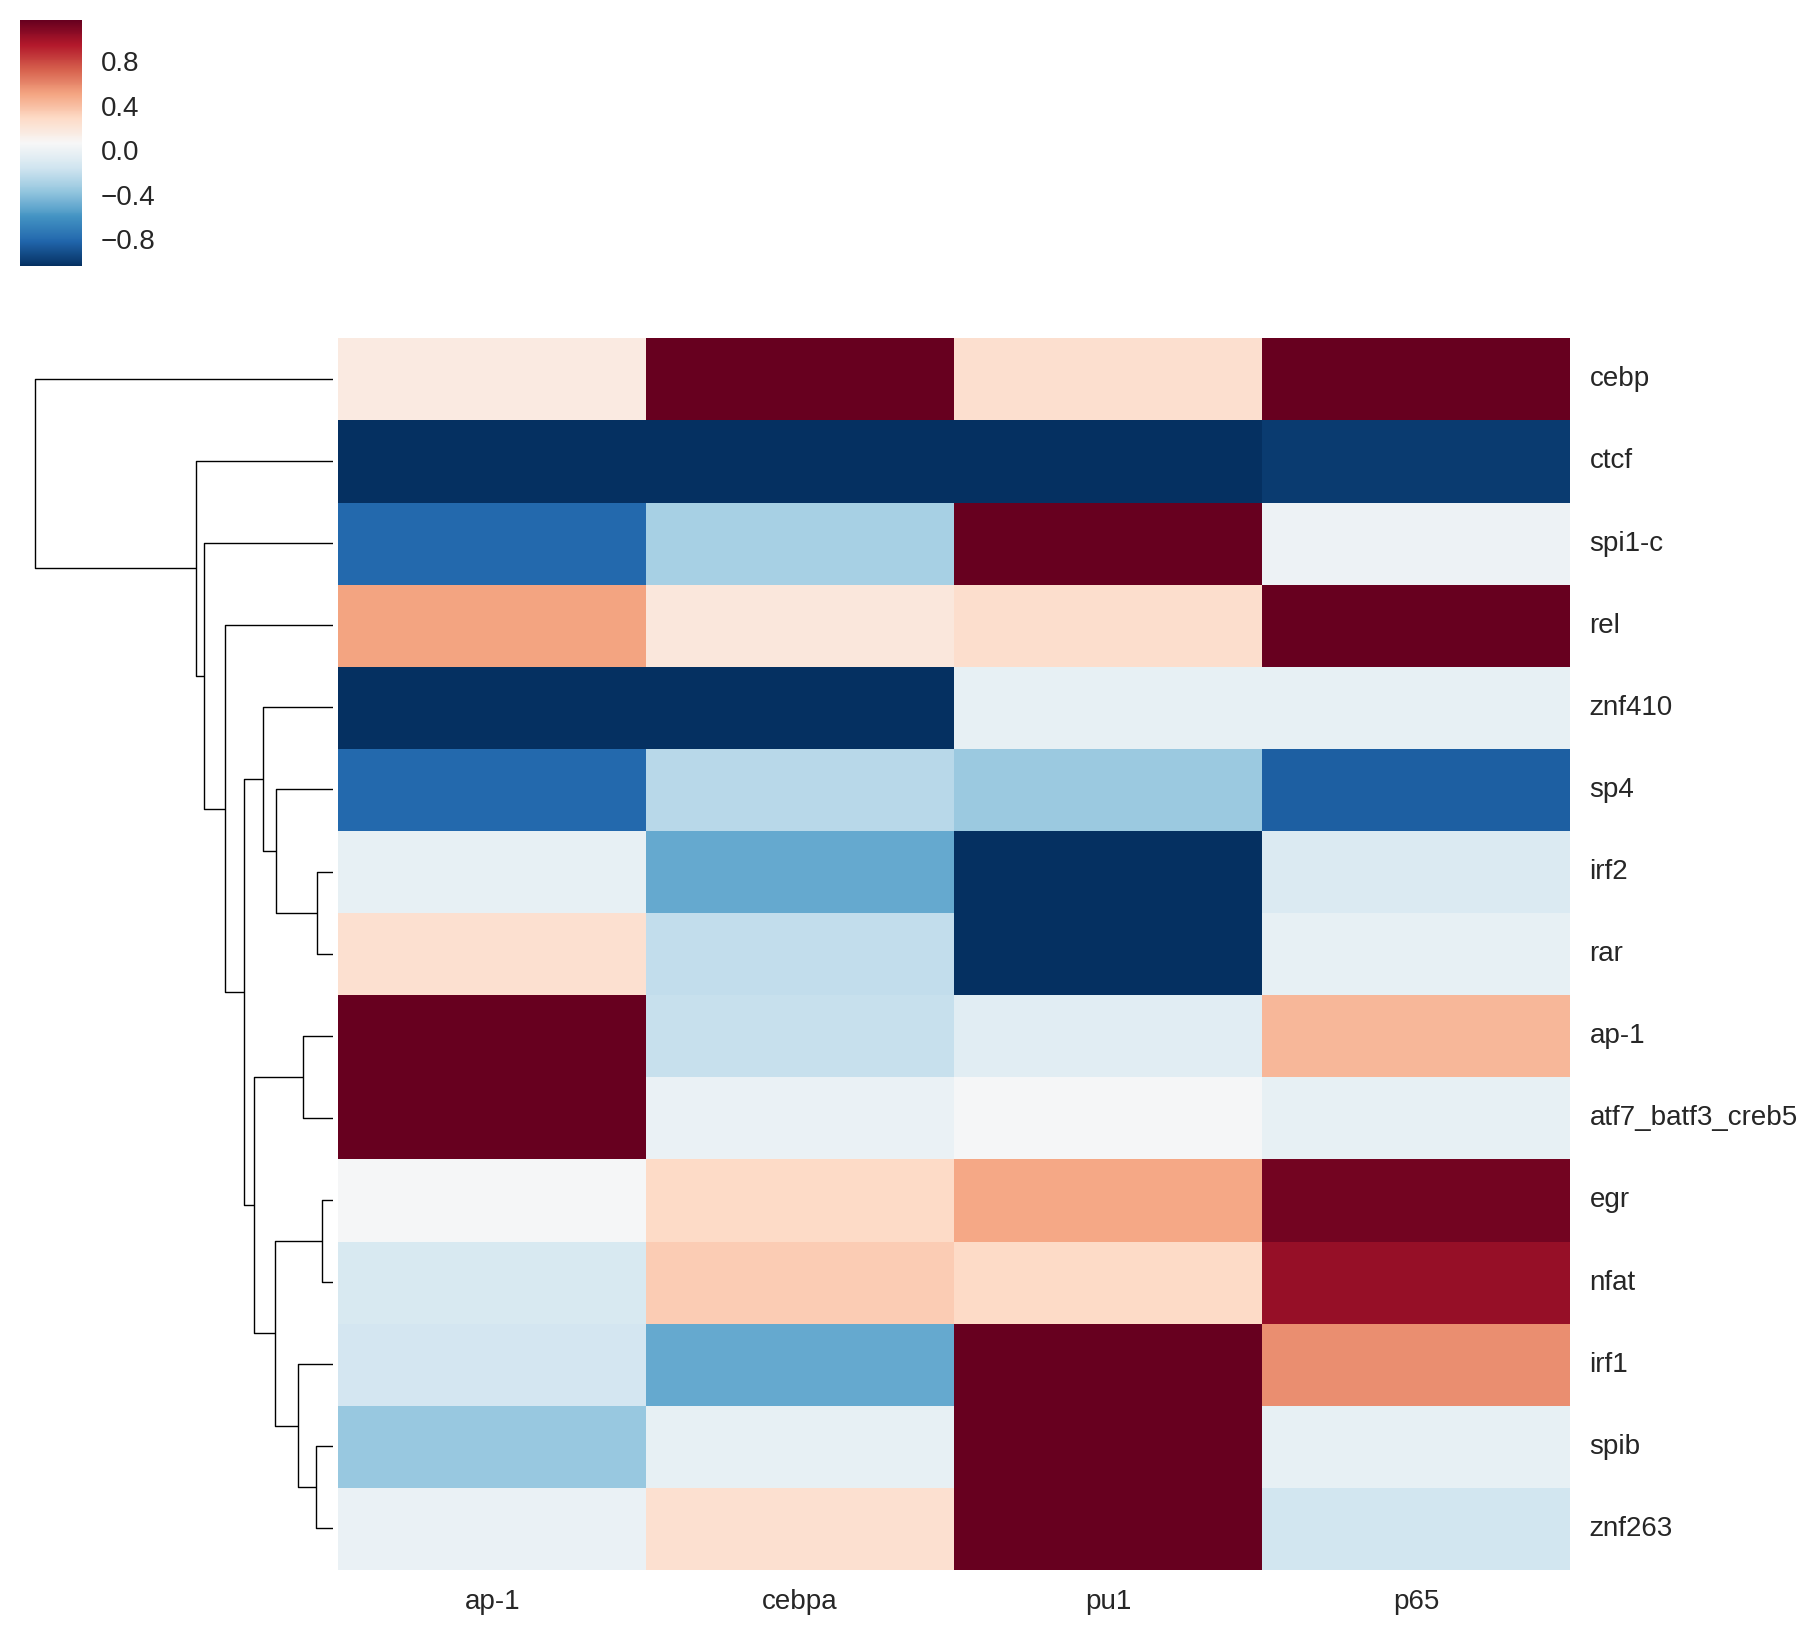

In [184]:
threshold = 2.5
coeff_std = np.std(coefficients_frame_kla.values.flatten())
coeff_mean = np.mean(coefficients_frame_kla.values.flatten())
cg = sns.clustermap(coefficients_frame_kla[coefficients_frame_kla.index.isin(significant_motifs_kla)],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=False,annot_kws={"size": 8},
                   col_cluster=False)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

### 3d - boxplots of motif scores for the important motifs? Motif Distance Plots?

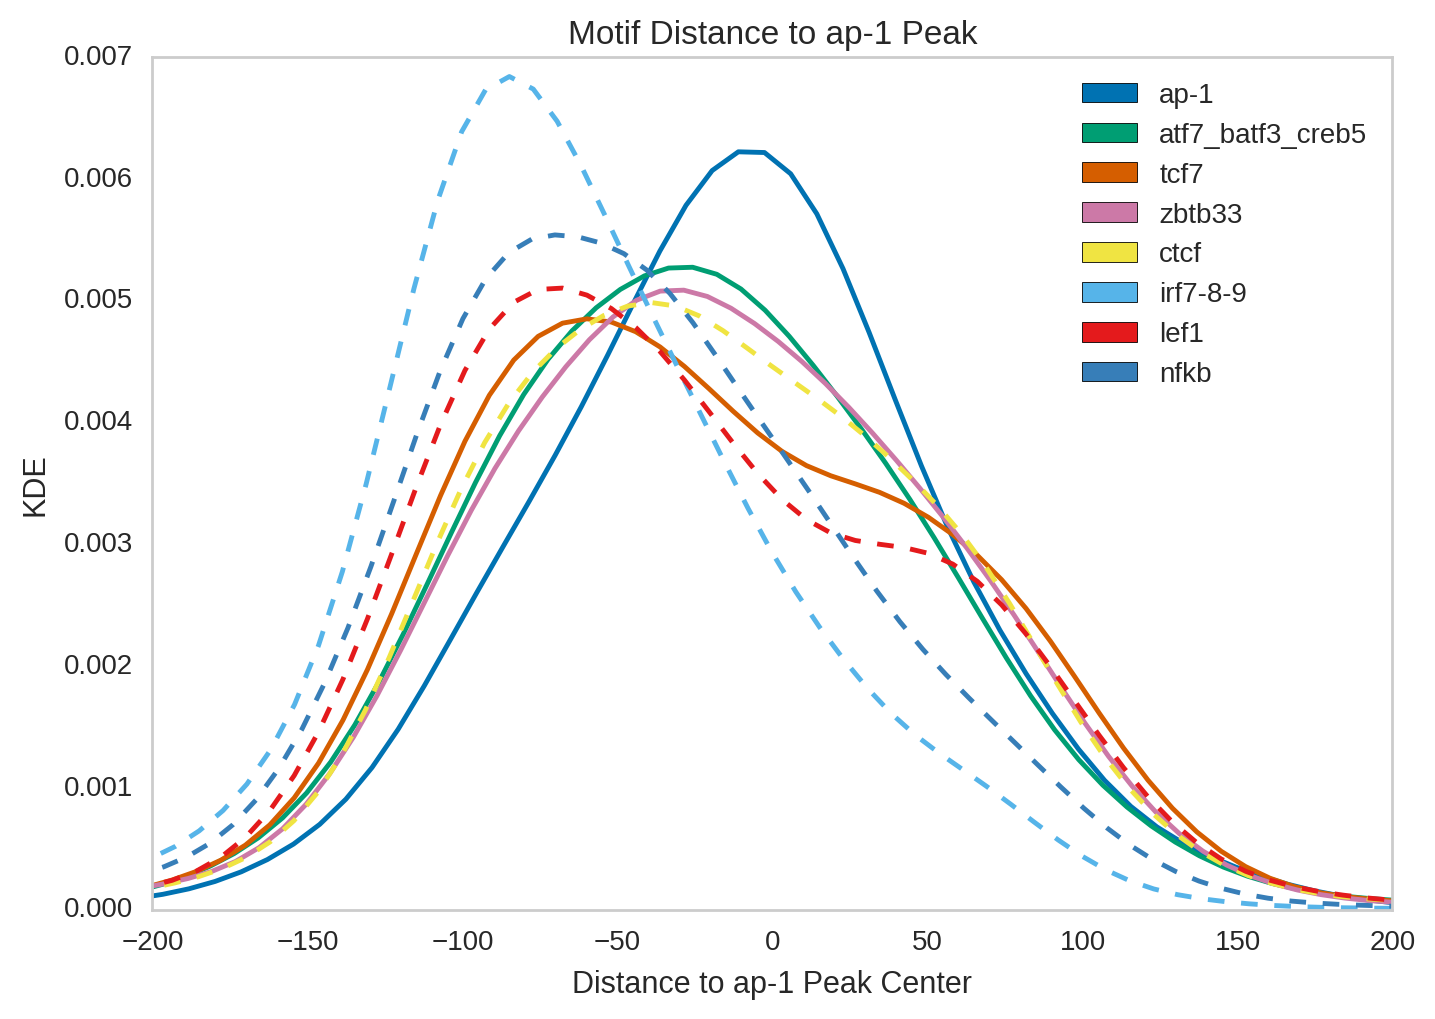

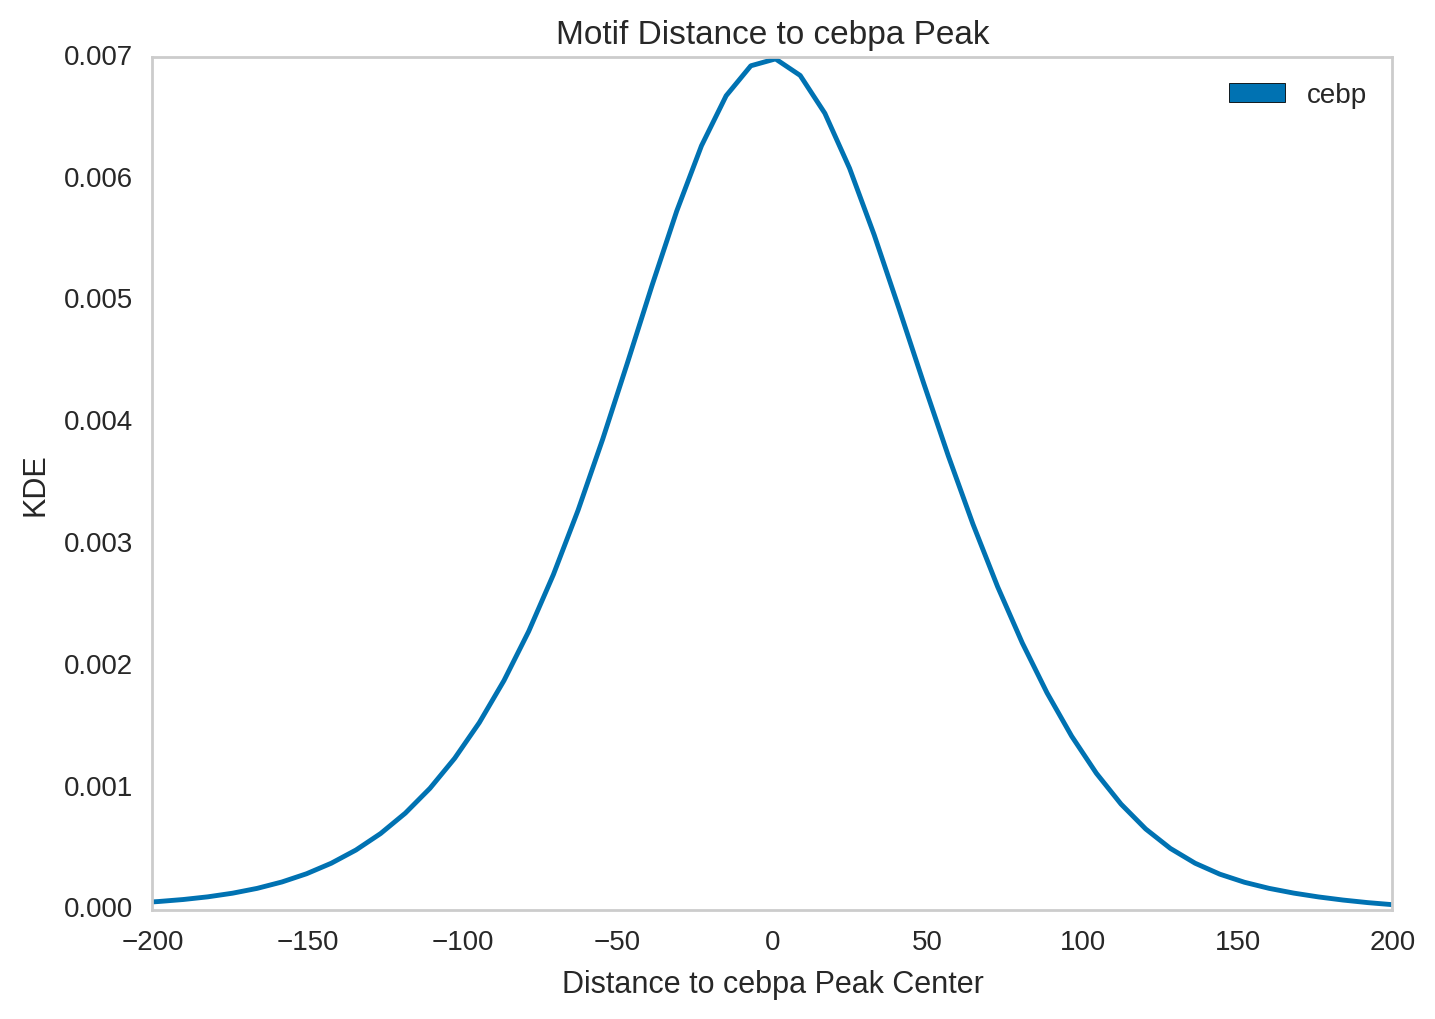

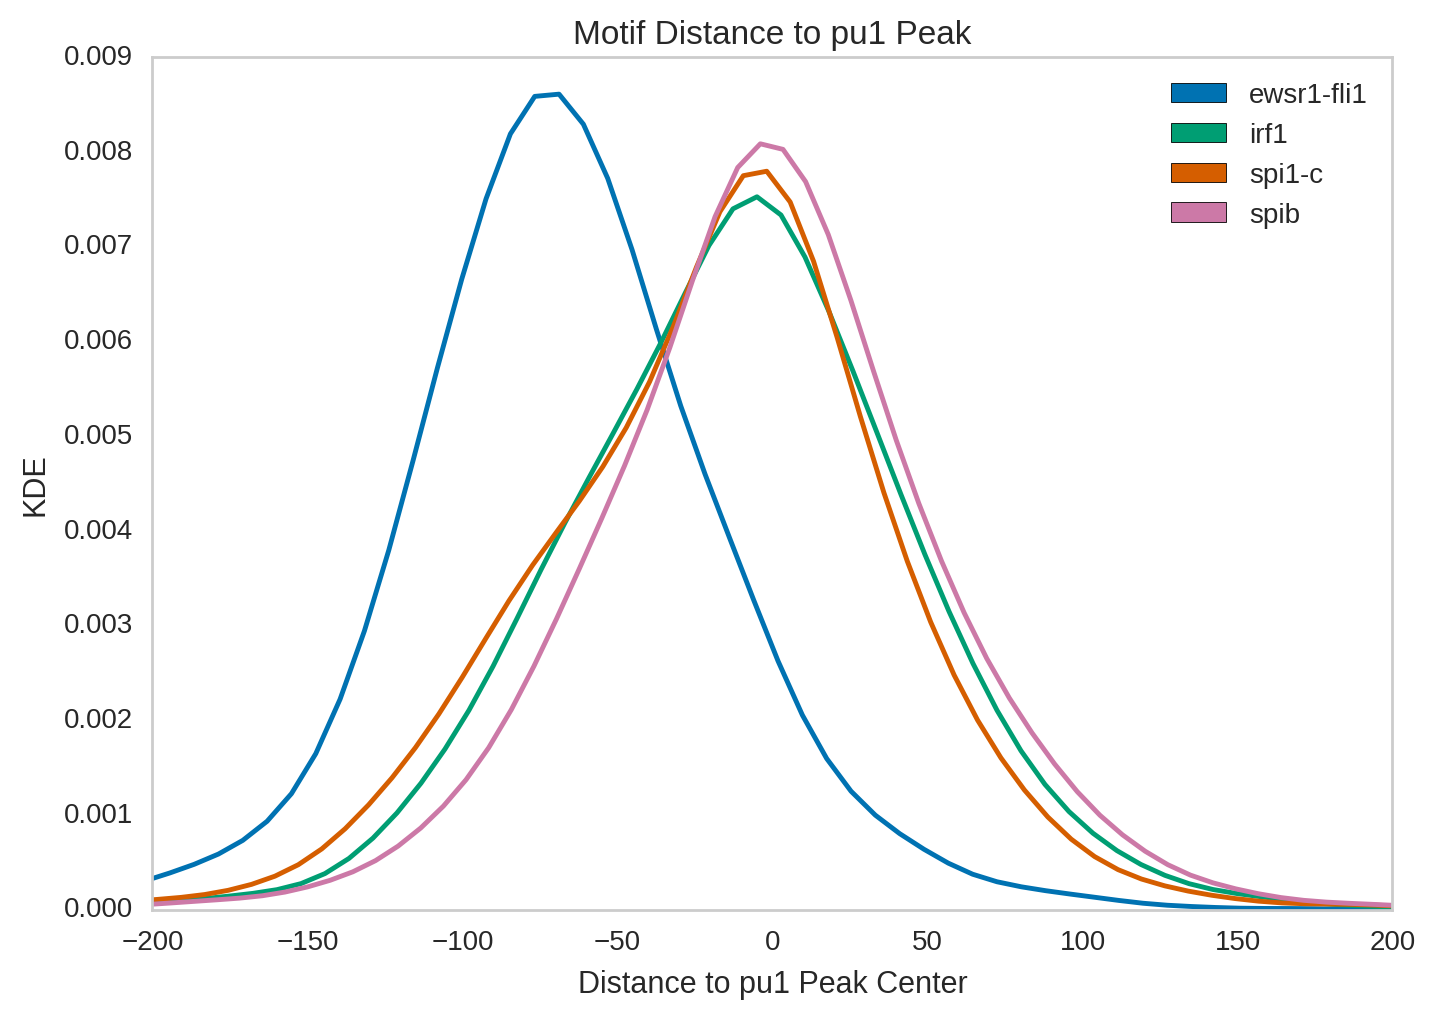

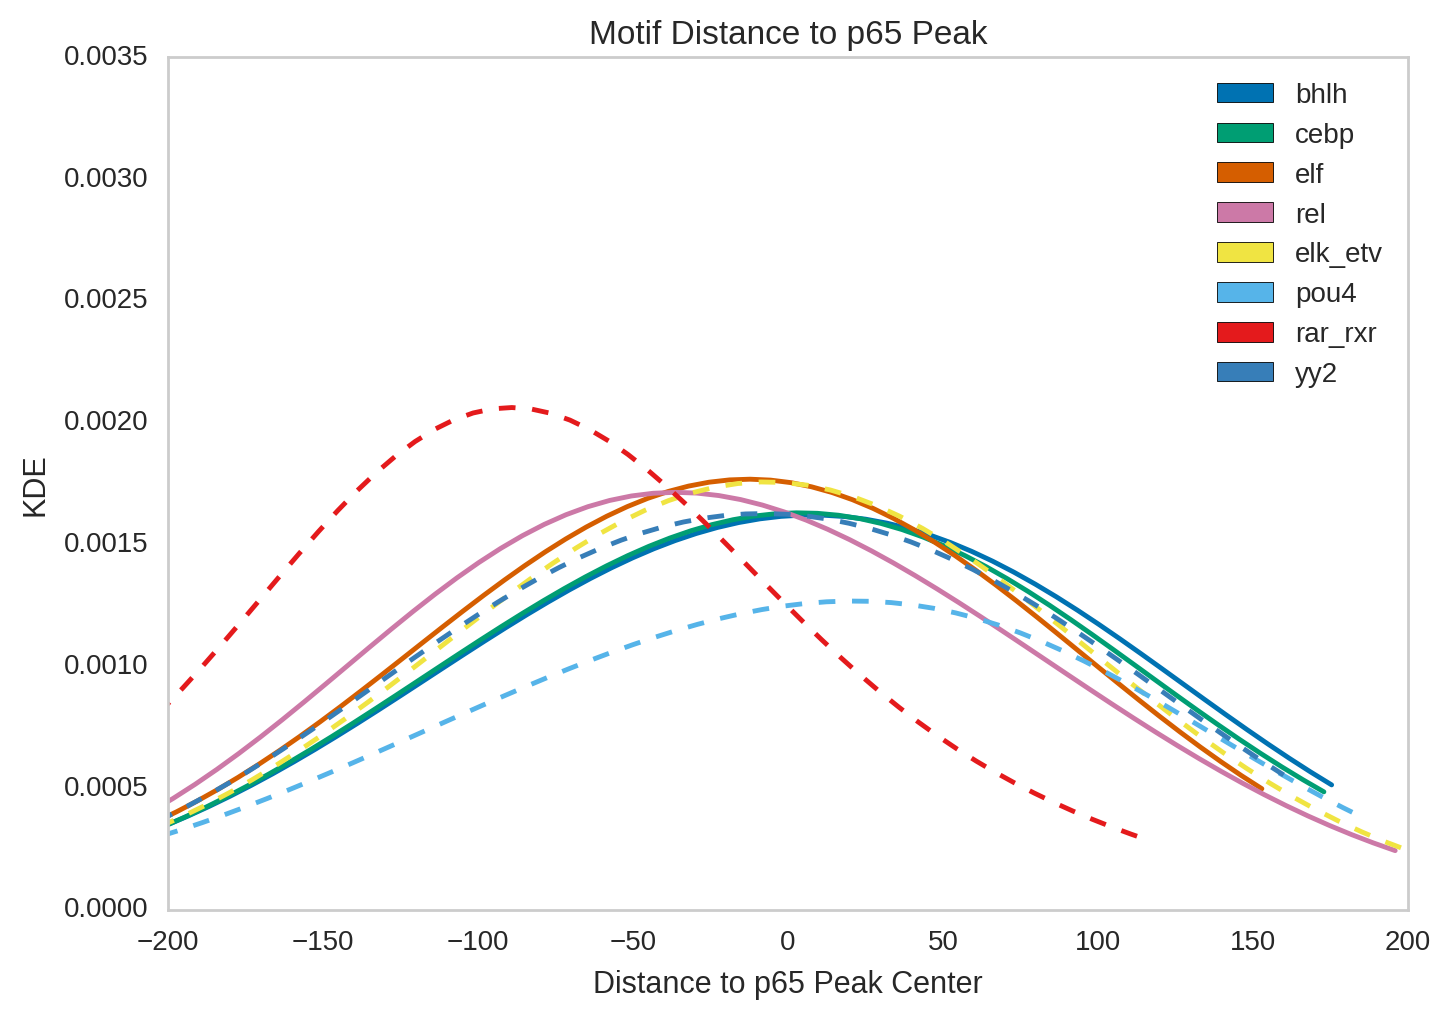

In [195]:
### motif distance plots for veh peaks ###
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
for factor in coefficients_frame_veh.columns.values:
    weights = coefficients_frame_veh[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits
    
colorDict = dict(zip(range(10), sns.color_palette("colorblind") + 
                     sns.color_palette("Set1") + 
                     sns.color_palette("Set2") + 
                     sns.color_palette("husl") +
                     sns.color_palette("Paired")
                    ))
for factor in coefficients_frame_veh.columns.values:
    positive_motifs = sorted(factor_motifs_positive_dict[factor])
    negative_motifs = sorted(factor_motifs_negative_dict[factor])
    for i in range(len(positive_motifs)):
        motif = positive_motifs[i]   
        current_frame = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+factor + '_veh')]
        peakCenters = current_frame['start'] + (current_frame['end'] - current_frame['start'])/2.0
        peak_center_dict = dict(zip(peakCenters.index, peakCenters.values))
        current_motif_frame = motif_start_frame[motif_start_frame.index.isin(current_frame.index)]
        motif_starts = current_motif_frame[current_motif_frame[motif] > 0][motif]
        motif_start_dict = dict(zip(motif_starts.index, motif_starts.values))
        distances = [motif_start_dict[x] - peak_center_dict[x] for x in motif_start_dict]
        for j in np.sum(current_motif_frame[current_motif_frame[motif] < 0]):
            distances.append(-500)
        distances = np.array(distances)
        with sns.axes_style('whitegrid',{'axes.grid': False}):
            sns.kdeplot(distances, color=colorDict[i])
    for i in range(len(negative_motifs)):
        motif = negative_motifs[i]   
        current_frame = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+factor+'_veh')]
        peakCenters = current_frame['start'] + (current_frame['end'] - current_frame['start'])/2.0
        peak_center_dict = dict(zip(peakCenters.index, peakCenters.values))
        current_motif_frame = motif_start_frame[motif_start_frame.index.isin(current_frame.index)]
        motif_starts = current_motif_frame[current_motif_frame[motif] > 0][motif]
        motif_start_dict = dict(zip(motif_starts.index, motif_starts.values))
        distances = [motif_start_dict[x] - peak_center_dict[x] for x in motif_start_dict]
        for j in np.sum(current_motif_frame[current_motif_frame[motif] < 0]):
            distances.append(-500)
        distances = np.array(distances)
        with sns.axes_style('whitegrid',{'axes.grid': False}):
            sns.kdeplot(distances, color=colorDict[i+len(positive_motifs)], linestyle='--')        
    recs = []
    for i in range(0,len(positive_motifs + negative_motifs)):
        recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=colorDict[i]))
    plt.legend(recs,positive_motifs + negative_motifs,loc='upper right')
    plt.xlim(-200,200)
    plt.ylabel('KDE')
    plt.xlabel('Distance to ' + factor +' Peak Center')
    plt.title('Motif Distance to '+factor +' Peak')
    plt.show()

ap-1 -0.779820441989 0.901092994639
cebpa -1.46381436931 1.59711349915
pu1 -0.857217572857 1.12349567781
p65 -0.812941283798 1.01543327048


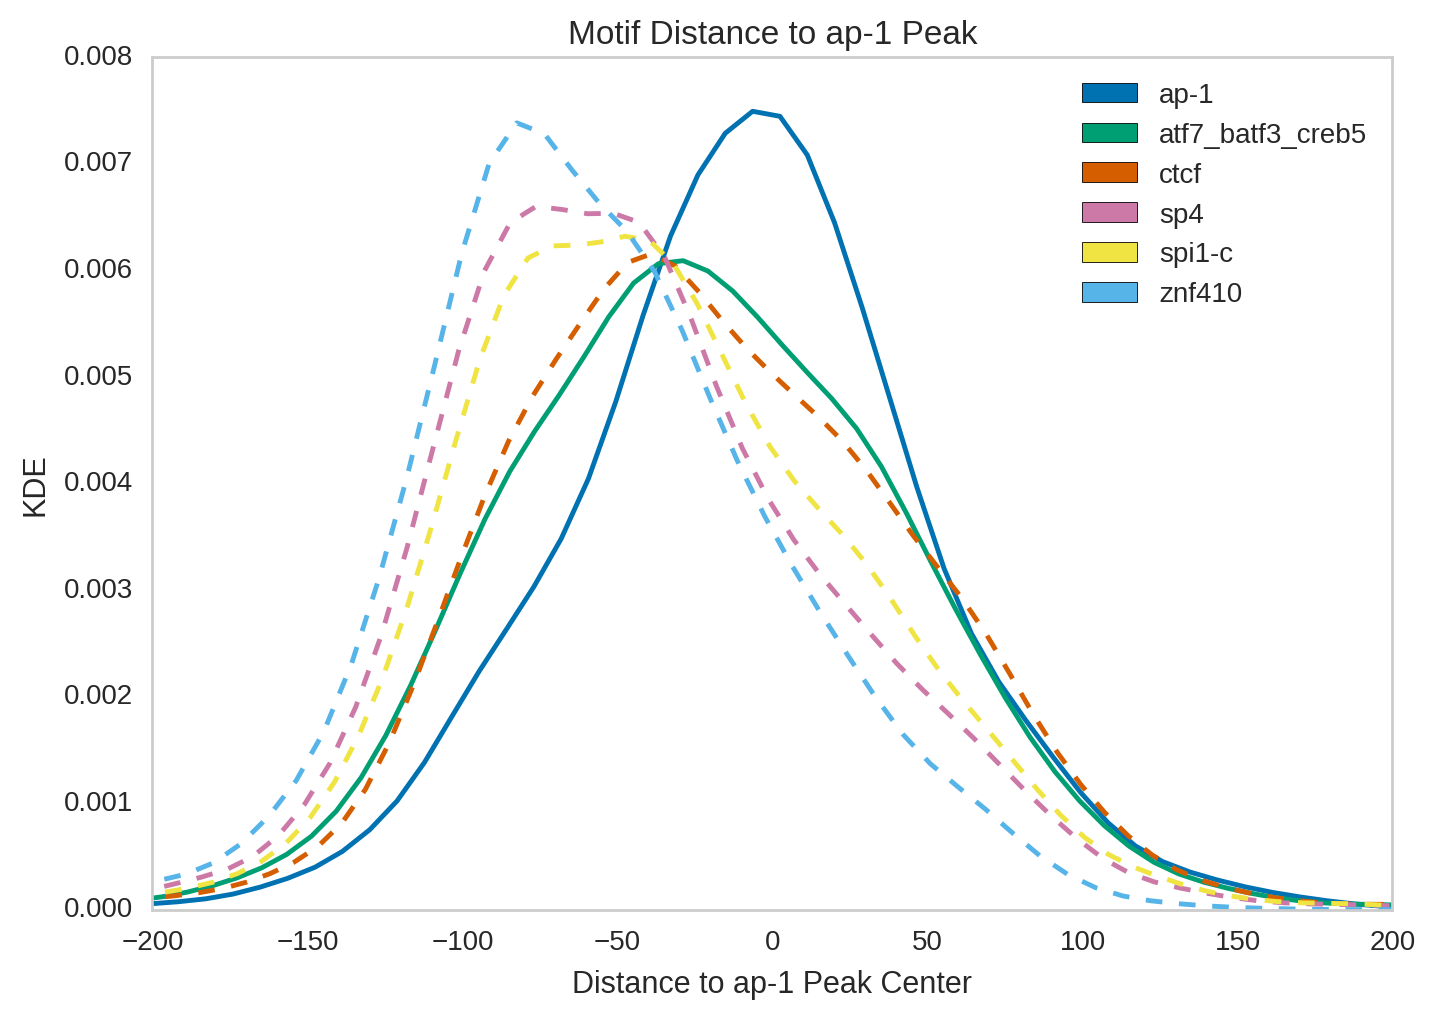

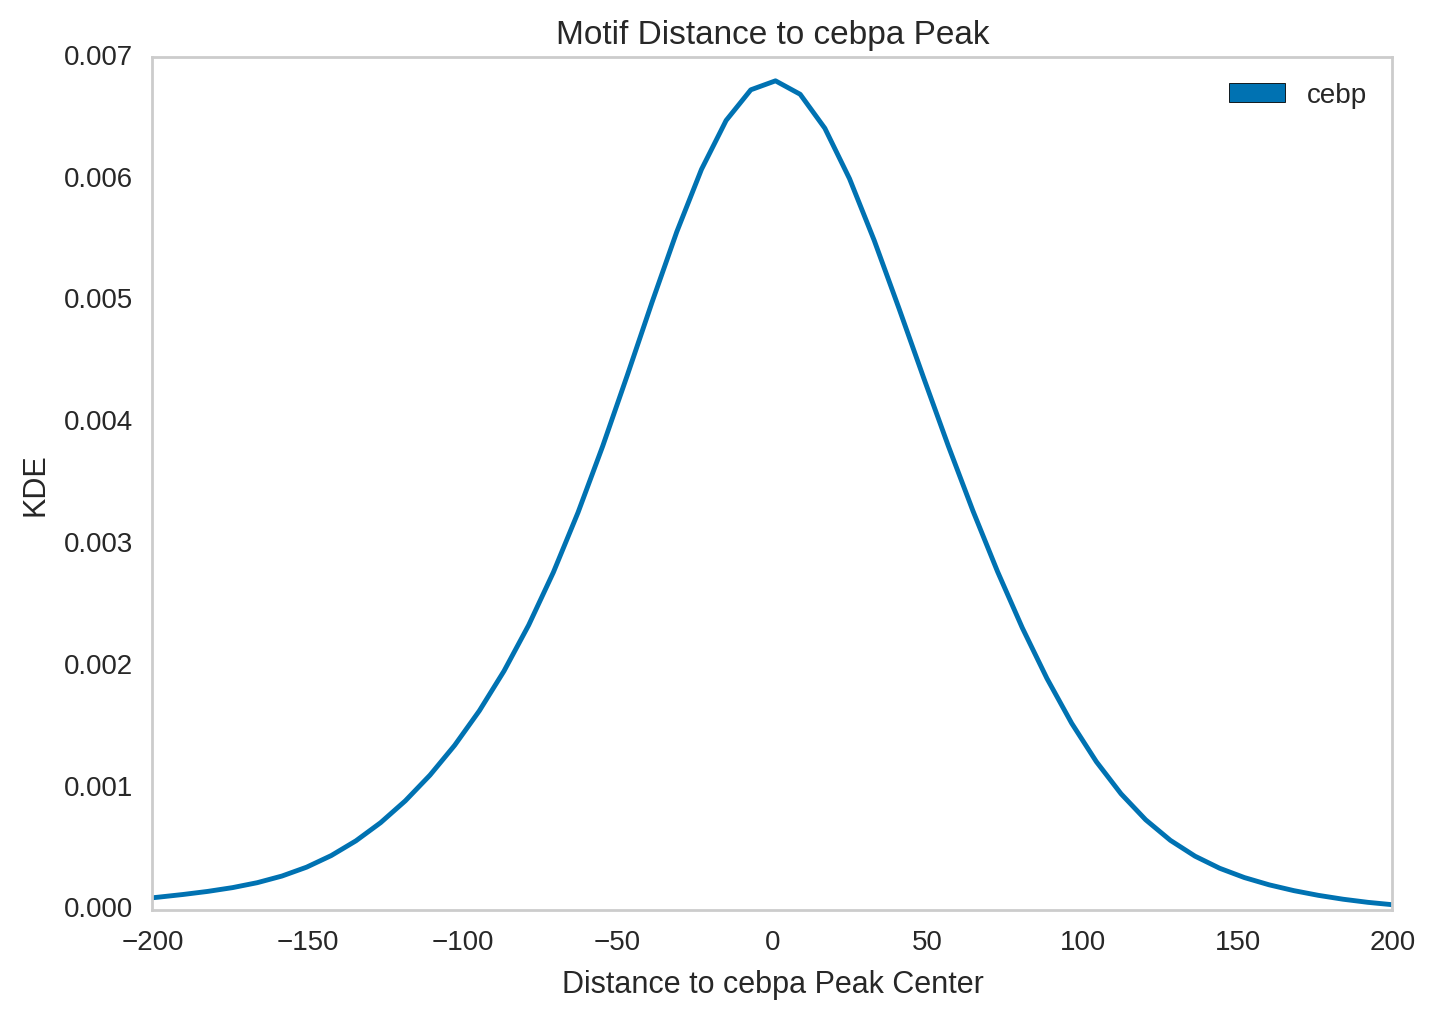

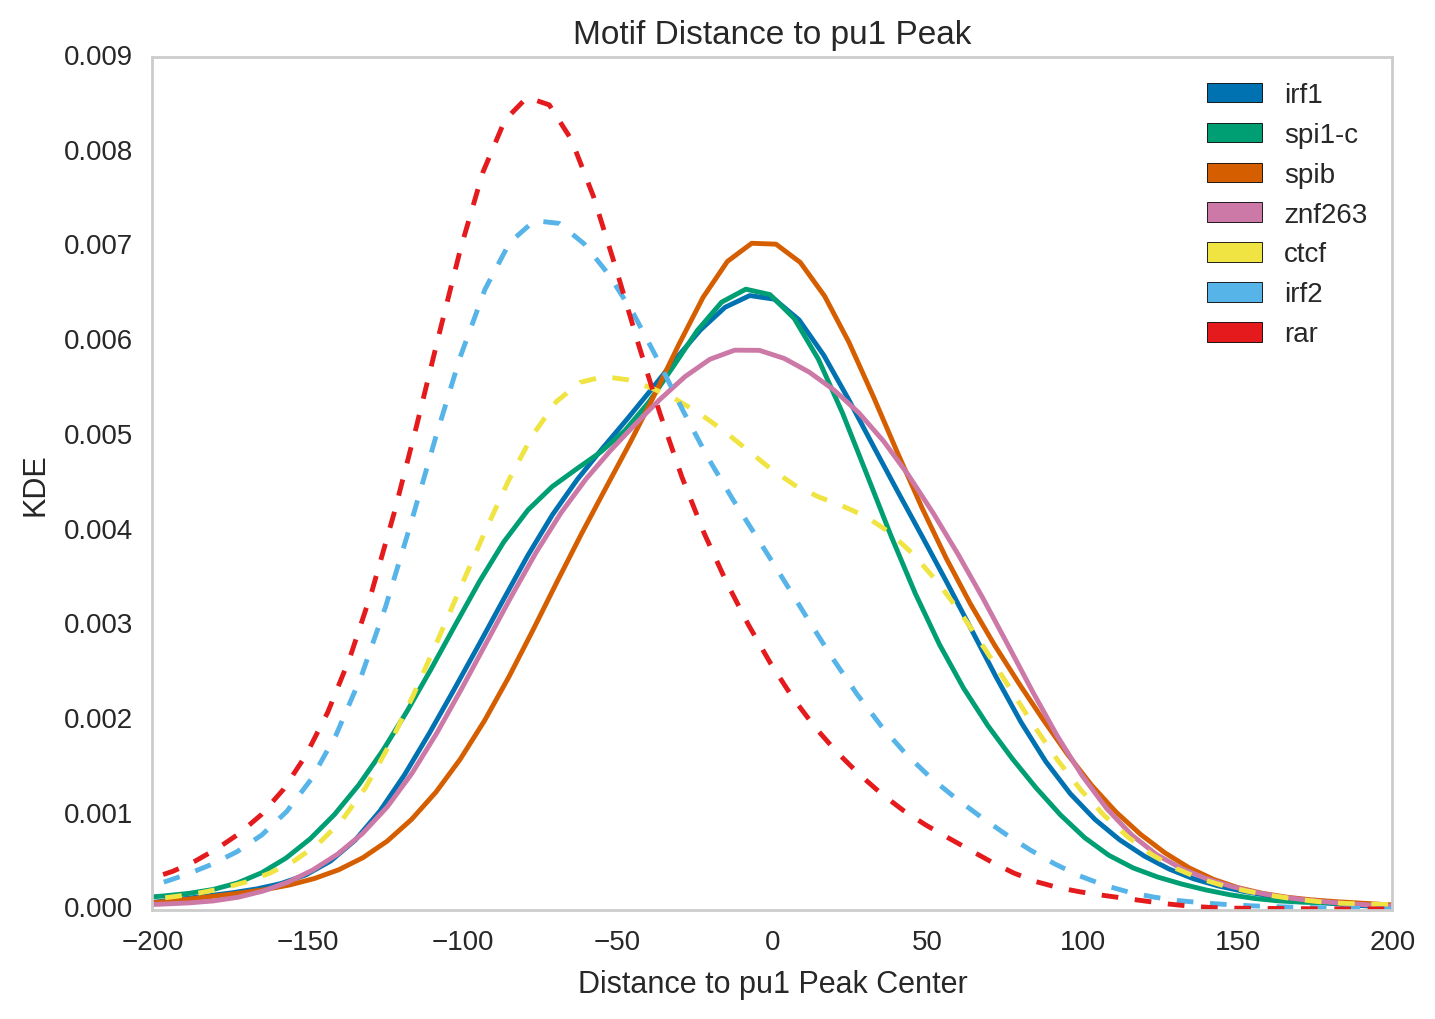

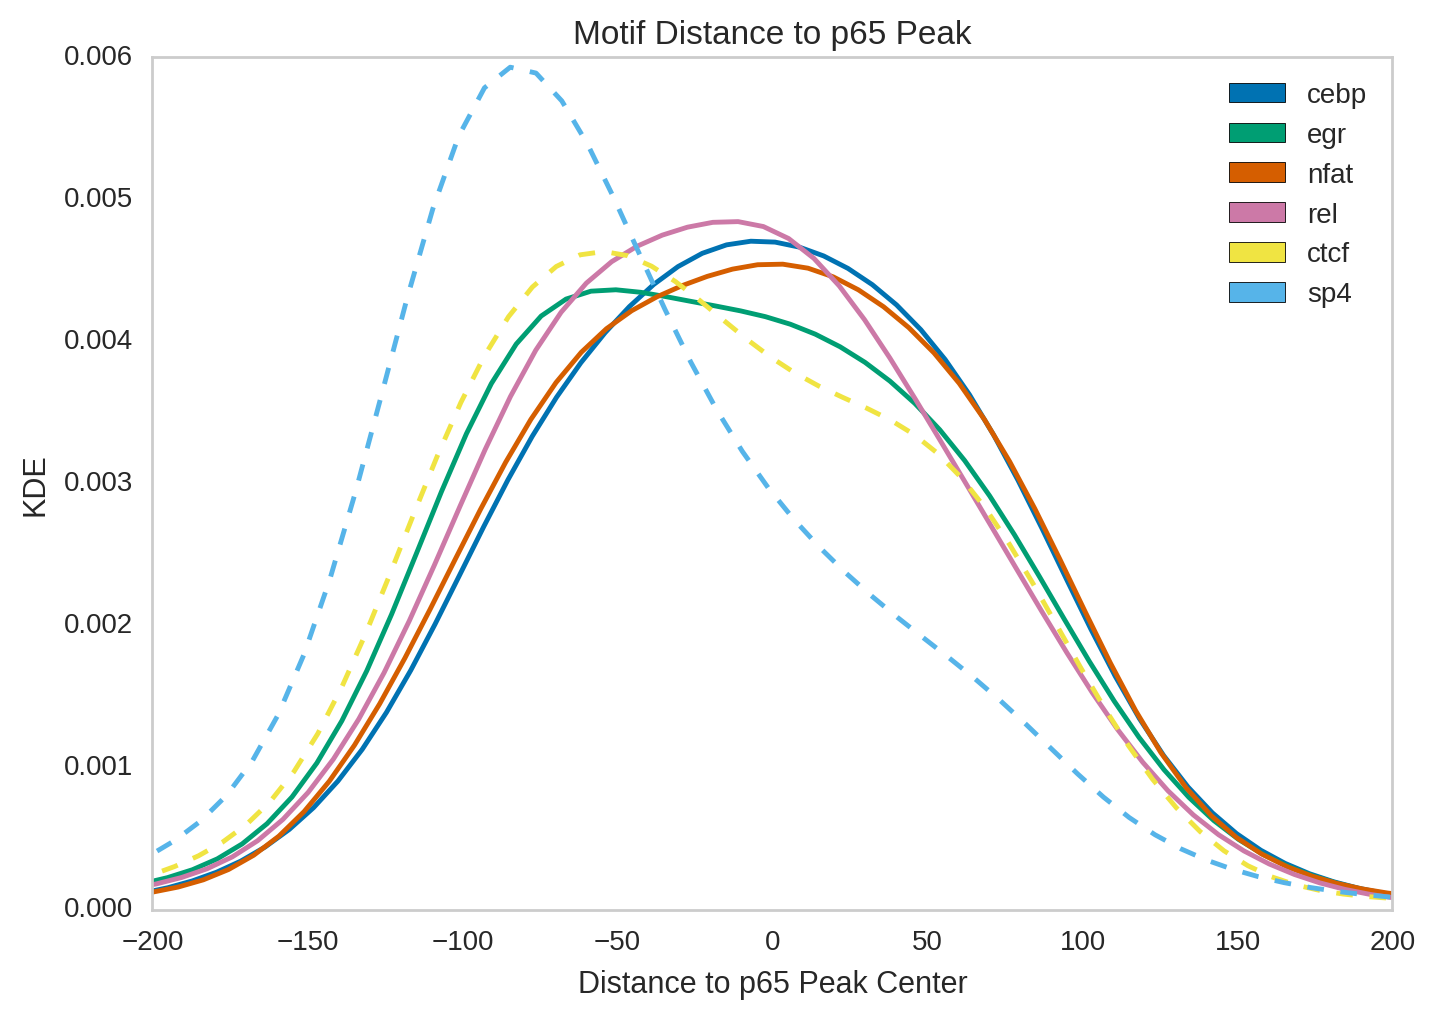

In [196]:
### motif distance plots for KLA peaks ###
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
significant_motifs_kla = set()
for factor in coefficients_frame_kla.columns.values:
    weights = coefficients_frame_kla[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_kla.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits

colorDict = dict(zip(range(10), sns.color_palette("colorblind") + 
                     sns.color_palette("Set1") + 
                     sns.color_palette("Set2") + 
                     sns.color_palette("husl") +
                     sns.color_palette("Paired")
                    ))
for factor in coefficients_frame_kla.columns.values:
    positive_motifs = sorted(factor_motifs_positive_dict[factor])
    negative_motifs = sorted(factor_motifs_negative_dict[factor])
    for i in range(len(positive_motifs)):
        motif = positive_motifs[i]   
        current_frame = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+factor+'_kla')]
        peakCenters = current_frame['start'] + (current_frame['end'] - current_frame['start'])/2.0
        peak_center_dict = dict(zip(peakCenters.index, peakCenters.values))
        current_motif_frame = motif_start_frame[motif_start_frame.index.isin(current_frame.index)]
        motif_starts = current_motif_frame[current_motif_frame[motif] > 0][motif]
        motif_start_dict = dict(zip(motif_starts.index, motif_starts.values))
        distances = [motif_start_dict[x] - peak_center_dict[x] for x in motif_start_dict]
        for j in np.sum(current_motif_frame[current_motif_frame[motif] < 0]):
            distances.append(-500)
        distances = np.array(distances)
        with sns.axes_style('whitegrid',{'axes.grid': False}):
            sns.kdeplot(distances, color=colorDict[i])
    for i in range(len(negative_motifs)):
        motif = negative_motifs[i]   
        current_frame = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+factor+'_kla')]
        peakCenters = current_frame['start'] + (current_frame['end'] - current_frame['start'])/2.0
        peak_center_dict = dict(zip(peakCenters.index, peakCenters.values))
        current_motif_frame = motif_start_frame[motif_start_frame.index.isin(current_frame.index)]
        motif_starts = current_motif_frame[current_motif_frame[motif] > 0][motif]
        motif_start_dict = dict(zip(motif_starts.index, motif_starts.values))
        distances = [motif_start_dict[x] - peak_center_dict[x] for x in motif_start_dict]
        for j in np.sum(current_motif_frame[current_motif_frame[motif] < 0]):
            distances.append(-500)
        distances = np.array(distances)
        with sns.axes_style('whitegrid',{'axes.grid': False}):
            sns.kdeplot(distances, color=colorDict[i+len(positive_motifs)], linestyle='--')        
    recs = []
    for i in range(0,len(positive_motifs + negative_motifs)):
        recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=colorDict[i]))
    plt.legend(recs,positive_motifs + negative_motifs,loc='upper right')
    plt.xlim(-200,200)
    plt.ylabel('KDE')
    plt.xlabel('Distance to ' + factor +' Peak Center')
    plt.title('Motif Distance to '+factor +' Peak')
    plt.show()

### 3e - strains confirmation



#### Vehicle

In [274]:
motif_balbcj_snp_frame = pd.read_pickle('./motif_balbcj_snp_frame.pickle')
motif_nod_snp_frame = pd.read_pickle('./motif_nod_snp_frame.pickle')

In [213]:
### for all peaks in vehicle 
factor_coeff_dict = {}
factor_auc_dict_all = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('veh'))].index.values
factors = ['atf3', 'cjun', 'jund','cebpa', 'pu1']
# factors = ['atf3', 'cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
# factors = ['ap-1', 'cebpa', 'pu1', 'p65']
for factor in factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_veh')
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_veh = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh = coefficients_frame_veh[factors]
coefficients_frame_veh.index = normed_motif_frame.columns.values

total: 18554 filtered: 17458 true gc: 0.47063 false gc: 0.48063 difference: 0.01
atf3 0.805116766756
total: 18554 filtered: 18554 true gc: 0.48004 false gc: 0.48596 difference: 0.00592
cjun 0.785772391168
total: 18554 filtered: 17811 true gc: 0.48934 false gc: 0.47934 difference: 0.01
jund 0.794782967072
total: 18554 filtered: 15388 true gc: 0.46476 false gc: 0.47476 difference: 0.01
cebpa 0.894030439133
total: 18554 filtered: 17151 true gc: 0.47551 false gc: 0.48548 difference: 0.00997
pu1 0.842872895915


In [528]:
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
for factor in coefficients_frame_veh.columns.values:
    weights = coefficients_frame_veh[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits

In [529]:
strains_factors = ['pu1',
#                    'fos',
                   'cjun',
#                    'junb',
                   'jund',
                   'pu1']
strains = ['balbc', 'nod']
treatments = ['veh']

strain_list = []
factor_list = []
binding_list = []
binding_ratio_list = []

for strain in strains:
    for factor in strains_factors:
        for treatment in treatments:
            print(strain, factor, treatment)
            strain_factor_treatment_1 = 'c57bl6'+'_'+factor+'_'+treatment
            strain_factor_treatment_2 = strain+'_'+factor+'_'+treatment
            indices = summary_frame[(summary_frame['Factors'].str.contains(strain_factor_treatment_1)) |
                                   (summary_frame['Factors'].str.contains(strain_factor_treatment_2))].index.values
            
            positive_motifs = factor_motifs_positive_dict[factor]
            negative_motifs = factor_motifs_negative_dict[factor]
#             print(positive_motifs)
            threshold = max(0,len(positive_motifs))
            threshold = len(positive_motifs) -1
            if strain == 'balbcj':
                snp_indices = motif_balbcj_snp_frame[(motif_balbcj_snp_frame[positive_motifs].sum(axis=1) >= threshold) &
                                                     (motif_balbcj_snp_frame.sum(axis=1) <=20)
                                                    ].index.values
            elif strain == 'nod':
                snp_indices = motif_nod_snp_frame[(motif_nod_snp_frame[positive_motifs].sum(axis=1) >= threshold) &
                                                     (motif_nod_snp_frame.sum(axis=1) <= 20)].index.values

            indices = [x for x in indices if x in snp_indices]
            
            peakScores_1 = summary_frame.ix[indices,strain_factor_treatment_1]
            peakScores_2 = summary_frame.ix[indices,strain_factor_treatment_2]
            
            binding_ratios = (peakScores_1 +1)/(peakScores_2 + 1)
            log_binding_ratios = list(np.log2(binding_ratios+1))

            if len(peakScores_1) > 1:

                binding_ratio_list = binding_ratio_list + log_binding_ratios
                binding_list = binding_list +list(peakScores_1)
                binding_list = binding_list + list(peakScores_2)
                factor_list = factor_list + [factor] * 1 * len(log_binding_ratios)
#                 strain_list = strain_list + ['c57bl6']  *len(log_binding_ratios)
                strain_list = strain_list + [strain]  *len(log_binding_ratios)

balbc pu1 veh
balbc cjun veh
balbc jund veh
balbc pu1 veh
nod pu1 veh
nod cjun veh
nod jund veh
nod pu1 veh


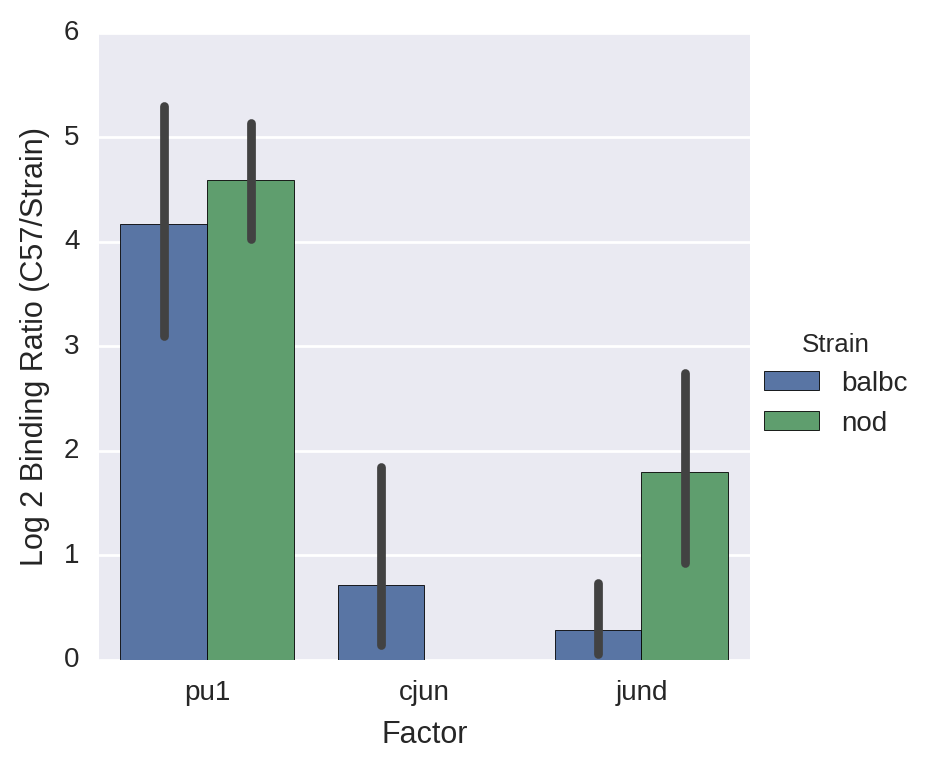

In [530]:
snp_plotting_frame = pd.DataFrame({'Factor':factor_list,
                                  'Strain':strain_list,
                                   'Log 2 Binding Ratio':binding_ratio_list}
                                  )
sns.factorplot(data = snp_plotting_frame,
               x='Factor', 
               hue='Strain',
               y='Log 2 Binding Ratio',
              kind='bar',
             )
plt.ylabel('Log 2 Binding Ratio (C57/Strain)')
plt.show()


#### KLA

In [380]:
### for all peaks in kla 
factor_coeff_dict = {}
factor_auc_dict_all = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('kla'))].index.values
factors = ['atf3', 'cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
# factors = ['ap-1', 'cebpa', 'pu1', 'p65']

for factor in factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indicesc67bl6_indices)]['Factors'].str.contains(factor + '_kla')
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_kla = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla = coefficients_frame_kla[factors]
coefficients_frame_kla.index = normed_motif_frame.columns.values


total: 25337 filtered: 25337 true gc: 0.47515 false gc: 0.48373 difference: 0.00858
atf3 0.84728133612
total: 25337 filtered: 25337 true gc: 0.48001 false gc: 0.48845 difference: 0.00845
cjun 0.857082003424
total: 25337 filtered: 24457 true gc: 0.47846 false gc: 0.48846 difference: 0.01
fos 0.883682176744
total: 25337 filtered: 25337 true gc: 0.48133 false gc: 0.48683 difference: 0.0055
junb 0.793799958313
total: 25337 filtered: 25337 true gc: 0.48168 false gc: 0.48525 difference: 0.00357
jund 0.843618723935
total: 25337 filtered: 19950 true gc: 0.46209 false gc: 0.47208 difference: 0.00999
cebpa 0.883248921649
total: 25337 filtered: 24196 true gc: 0.47719 false gc: 0.48718 difference: 0.00999
pu1 0.85130943594
total: 25337 filtered: 25337 true gc: 0.48818 false gc: 0.48219 difference: 0.00599
p65 0.839630620991
atf3 -0.980015403742 1.14137848406
cjun -0.721959412706 1.07388608806
fos -0.807033297405 1.11392353029
junb -0.789211369863 0.936333173446
jund -0.624182575531 0.933250198163


In [519]:
threshold = 2.5
factor_motifs_positive_dict = {}
factor_motifs_negative_dict = {}
factor_motifs_dict = {}
significant_motifs_kla = set()
for factor in coefficients_frame_kla.columns.values:
    weights = coefficients_frame_kla[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_kla.add(m)
    factor_motifs_dict[factor] = motif_hits
    factor_motifs_negative_dict[ factor] = negative_hits
    factor_motifs_positive_dict[factor] = positive_hits


atf3 -0.980015403742 1.14137848406
cjun -0.721959412706 1.07388608806
fos -0.807033297405 1.11392353029
junb -0.789211369863 0.936333173446
jund -0.624182575531 0.933250198163
cebpa -1.4678652801 1.6109730416
pu1 -0.915615394874 1.17713979715
p65 -0.776021265498 0.986415793657


In [524]:
strains_factors = ['pu1',
                   'fos',
                   'cjun',
                   'junb',
                   'jund',
                   'pu1']
strains = ['balbc', 'nod']
treatments = ['kla']

strain_list = []
factor_list = []
binding_list = []
binding_ratio_list = []

for strain in strains:
    for factor in strains_factors:
        for treatment in treatments:
            print(strain, factor, treatment)
            strain_factor_treatment_1 = 'c57bl6'+'_'+factor+'_'+treatment
            strain_factor_treatment_2 = strain+'_'+factor+'_'+treatment
            indices = summary_frame[(summary_frame['Factors'].str.contains(strain_factor_treatment_1)) |
                                   (summary_frame['Factors'].str.contains(strain_factor_treatment_2))].index.values
            
            positive_motifs = factor_motifs_positive_dict[factor]
            negative_motifs = factor_motifs_negative_dict[factor]
#             print(positive_motifs)
            threshold = max(0,len(positive_motifs))
            threshold = len(positive_motifs) -1 
            if strain == 'balbcj':
                snp_indices = motif_balbcj_snp_frame[(motif_balbcj_snp_frame[positive_motifs].sum(axis=1) >= threshold) &
                                                     (motif_balbcj_snp_frame.sum(axis=1) <=20)
                                                    ].index.values
            elif strain == 'nod':
                snp_indices = motif_nod_snp_frame[(motif_nod_snp_frame[positive_motifs].sum(axis=1) >= threshold) &
                                                     (motif_nod_snp_frame.sum(axis=1) <= 20)].index.values

            indices = [x for x in indices if x in snp_indices]
            
            peakScores_1 = summary_frame.ix[indices,strain_factor_treatment_1]
            peakScores_2 = summary_frame.ix[indices,strain_factor_treatment_2]
            
            binding_ratios = (peakScores_1 +1)/(peakScores_2 + 1)
            log_binding_ratios = list(np.log2(binding_ratios+1))

            if len(peakScores_1) > 1:

                binding_ratio_list = binding_ratio_list + log_binding_ratios
                binding_list = binding_list +list(peakScores_1)
                binding_list = binding_list + list(peakScores_2)
                factor_list = factor_list + [factor] * 1 * len(log_binding_ratios)
#                 strain_list = strain_list + ['c57bl6']  *len(log_binding_ratios)
                strain_list = strain_list + [strain]  *len(log_binding_ratios)

balbc pu1 kla
balbc fos kla
balbc cjun kla
balbc junb kla
balbc jund kla
balbc pu1 kla
nod pu1 kla
nod fos kla
nod cjun kla
nod junb kla
nod jund kla
nod pu1 kla


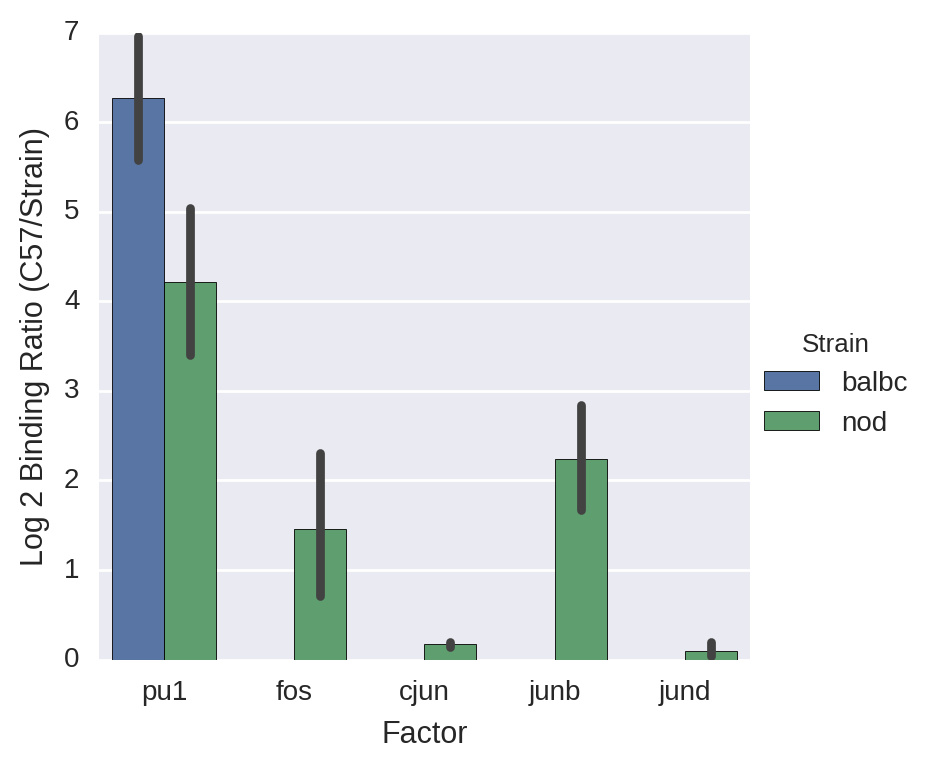

In [525]:
snp_plotting_frame = pd.DataFrame({'Factor':factor_list,
                                  'Strain':strain_list,
                                   'Log 2 Binding Ratio':binding_ratio_list}
                                  )
sns.factorplot(data = snp_plotting_frame,
               x='Factor', 
               hue='Strain',
               y='Log 2 Binding Ratio',
              kind='bar',
             )
plt.ylabel('Log 2 Binding Ratio (C57/Strain)')
plt.show()


## Figure 4 - Motifs that coordinate pairs of transcription factors

### 4a - Workflow of motif analysis and prediction scheme


### 4c- Heatmap highlighting weights that are important for each pair of factors (collapse AP-1 for comparisons to PU-1 and CEBPa and p65)


#### comparisons to collapsed PU.1, CEBPa, and p65

#### vehicle

In [154]:
summary_frame = pd.read_pickle('summary_frame.pickle')

summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]



In [155]:
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

In [145]:
factors = ['ap-1', 'cebpa', 'p65', 'pu1']
factorPairs = []
for i in range(len(factors)-1):
    for j in range(i+1, len(factors)):
        factorPairs.append(('c57bl6_'+factors[i],'c57bl6_'+ factors[j]))

In [146]:
### for all peaks in vehicle for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indicesc67bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('veh'))].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0]+'_veh') & summary_frame['Factors'].str.contains(factorPair[1]+'_veh')
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    # Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_veh_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_pairs.index = normed_motif_frame.columns.values

threshold = 2.5
factorPair_motifs_positive_dict = {}
factorPair_motifs_negative_dict = {}
factorPair_motifs_dict = {}
significant_motifs_veh_pairs = set()
for factor in coefficients_frame_veh_pairs.columns.values:
    weights = coefficients_frame_veh_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_veh_pairs.add(m)
    factorPair_motifs_dict[factor] = motif_hits
    factorPair_motifs_negative_dict[ factor] = negative_hits
    factorPair_motifs_positive_dict[factor] = positive_hits
#     sns.distplot(weights)
#     for pos in [mean, mean-std, mean+std, mean+2*std, mean-2*std]:
#         plt.axvline(pos)
#     plt.title(factor)
    
#     plt.show()
#     print(factor)



total: 18554 filtered: 18554 true gc: 0.47852 false gc: 0.48393 difference: 0.00541
('c57bl6_ap-1', 'c57bl6_cebpa') 0.859274085639
total: 18554 filtered: 9757 true gc: 0.52645 false gc: 0.51645 difference: 0.01
('c57bl6_ap-1', 'c57bl6_p65') 0.790419255929
total: 18554 filtered: 18374 true gc: 0.49188 false gc: 0.48188 difference: 0.01
('c57bl6_ap-1', 'c57bl6_pu1') 0.782586117949
total: 18554 filtered: 18388 true gc: 0.49396 false gc: 0.48396 difference: 0.01
('c57bl6_cebpa', 'c57bl6_p65') 0.837462462462
total: 18554 filtered: 15761 true gc: 0.46566 false gc: 0.47566 difference: 0.01
('c57bl6_cebpa', 'c57bl6_pu1') 0.850114869943
total: 18554 filtered: 12230 true gc: 0.51464 false gc: 0.50465 difference: 0.01
('c57bl6_p65', 'c57bl6_pu1') 0.771340470268
c57bl6_ap-1_c57bl6_cebpa -1.24910350691 1.42676330568
c57bl6_ap-1_c57bl6_p65 -0.916844698393 1.06246146758
c57bl6_ap-1_c57bl6_pu1 -0.700117841297 0.906269163652
c57bl6_cebpa_c57bl6_p65 -0.938627940336 1.06606424058
c57bl6_cebpa_c57bl6_pu1 

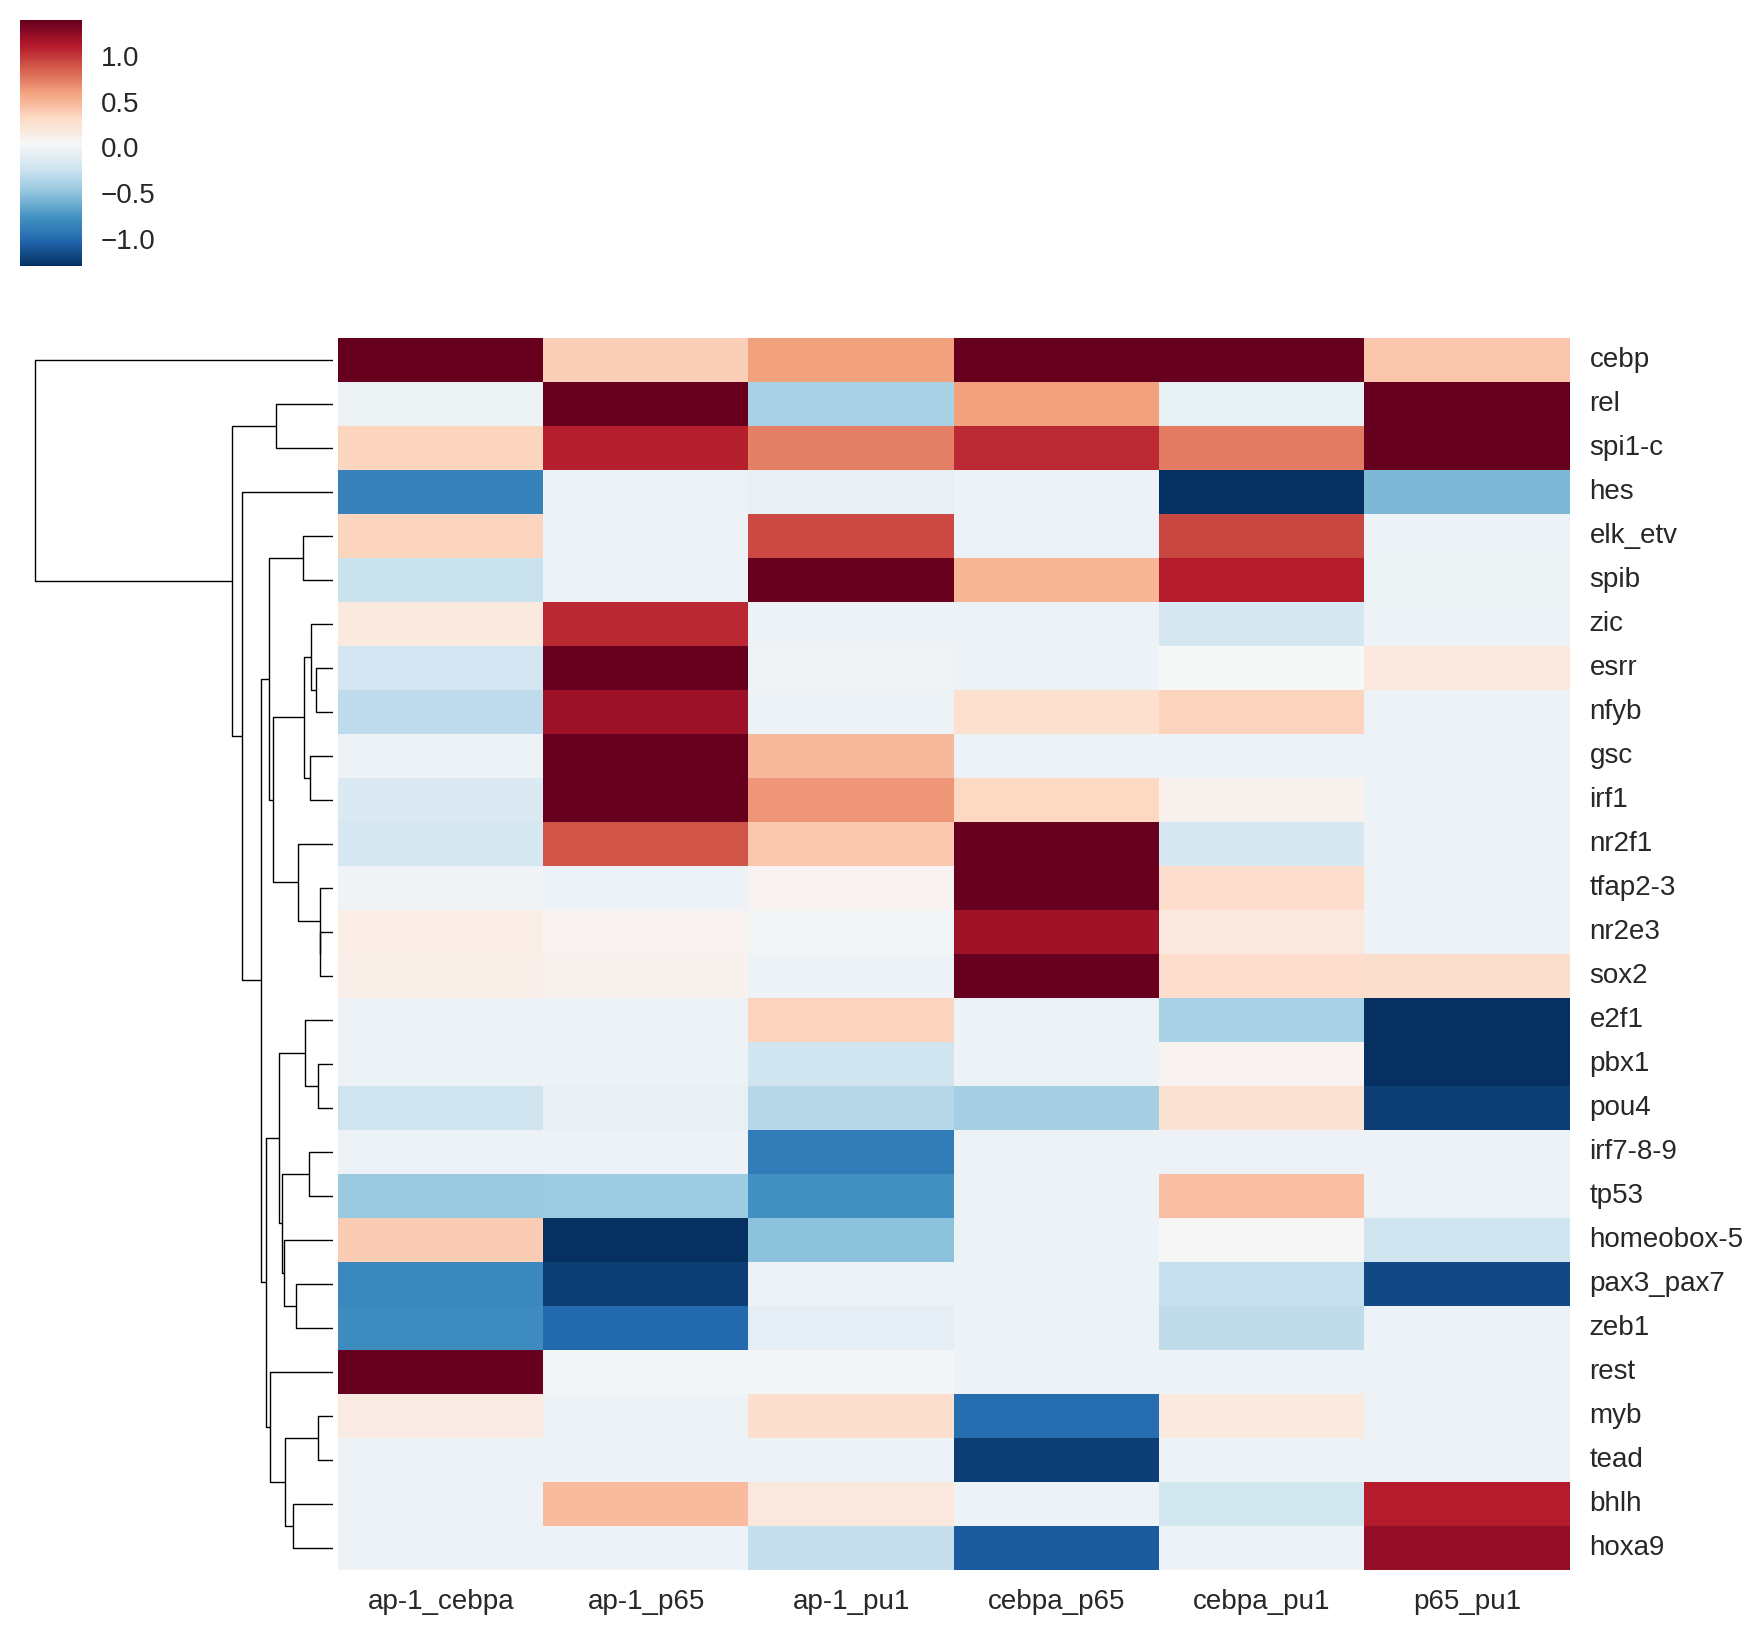

In [147]:
threshold = 3
coeff_std = np.std(coefficients_frame_veh_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_veh_pairs.values.flatten())
data = coefficients_frame_veh_pairs[coefficients_frame_veh_pairs.index.isin(significant_motifs_veh_pairs)]
data.columns = [x.replace('c57bl6_','') for x in data.columns.values]
# fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style('whitegrid'):
    cg = sns.clustermap(data,
                       vmax=(coeff_mean + threshold* coeff_std),
                       vmin=(coeff_mean - threshold* coeff_std),
                       center = coeff_mean,
                       annot=False,annot_kws={"size": 6},
                       col_cluster=False)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

#### KLA

In [148]:
### for all peaks in KLA for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('kla'))].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indicesc67bl6_indices)]['Factors'].str.contains(
        factorPair[0]+'_kla') & summary_frame['Factors'].str.contains(factorPair[1]+'_kla')
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    # Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_kla_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla_pairs.index = normed_motif_frame.columns.values

threshold = 2.5
factorPair_motifs_positive_dict = {}
factorPair_motifs_negative_dict = {}
factorPair_motifs_dict = {}
significant_motifs_kla_pairs = set()
for factor in coefficients_frame_kla_pairs.columns.values:
    weights = coefficients_frame_kla_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_kla_pairs.add(m)
    factorPair_motifs_dict[factor] = motif_hits
    factorPair_motifs_negative_dict[ factor] = negative_hits
    factorPair_motifs_positive_dict[factor] = positive_hits
#     sns.distplot(weights)
#     for pos in [mean, mean-std, mean+std, mean+2*std, mean-2*std]:
#         plt.axvline(pos)
#     plt.title(factor)
    
#     plt.show()
#     print(factor)



total: 25337 filtered: 23334 true gc: 0.4701 false gc: 0.48009 difference: 0.01
('c57bl6_ap-1', 'c57bl6_cebpa') 0.873534733286
total: 25337 filtered: 25337 true gc: 0.48993 false gc: 0.48196 difference: 0.00797
('c57bl6_ap-1', 'c57bl6_p65') 0.842734217222
total: 25337 filtered: 25337 true gc: 0.48449 false gc: 0.48276 difference: 0.00173
('c57bl6_ap-1', 'c57bl6_pu1') 0.830907310479
total: 25337 filtered: 23956 true gc: 0.47089 false gc: 0.48089 difference: 0.01
('c57bl6_cebpa', 'c57bl6_p65') 0.862348700633
total: 25337 filtered: 21085 true gc: 0.46454 false gc: 0.47453 difference: 0.01
('c57bl6_cebpa', 'c57bl6_pu1') 0.865537811242
total: 25337 filtered: 25337 true gc: 0.48534 false gc: 0.48295 difference: 0.00239
('c57bl6_p65', 'c57bl6_pu1') 0.836497030897
c57bl6_ap-1_c57bl6_cebpa -1.31265313766 1.47235856568
c57bl6_ap-1_c57bl6_p65 -0.835199351556 1.03492360763
c57bl6_ap-1_c57bl6_pu1 -0.669180546838 0.917503281574
c57bl6_cebpa_c57bl6_p65 -1.28267526846 1.44907186655
c57bl6_cebpa_c57bl6

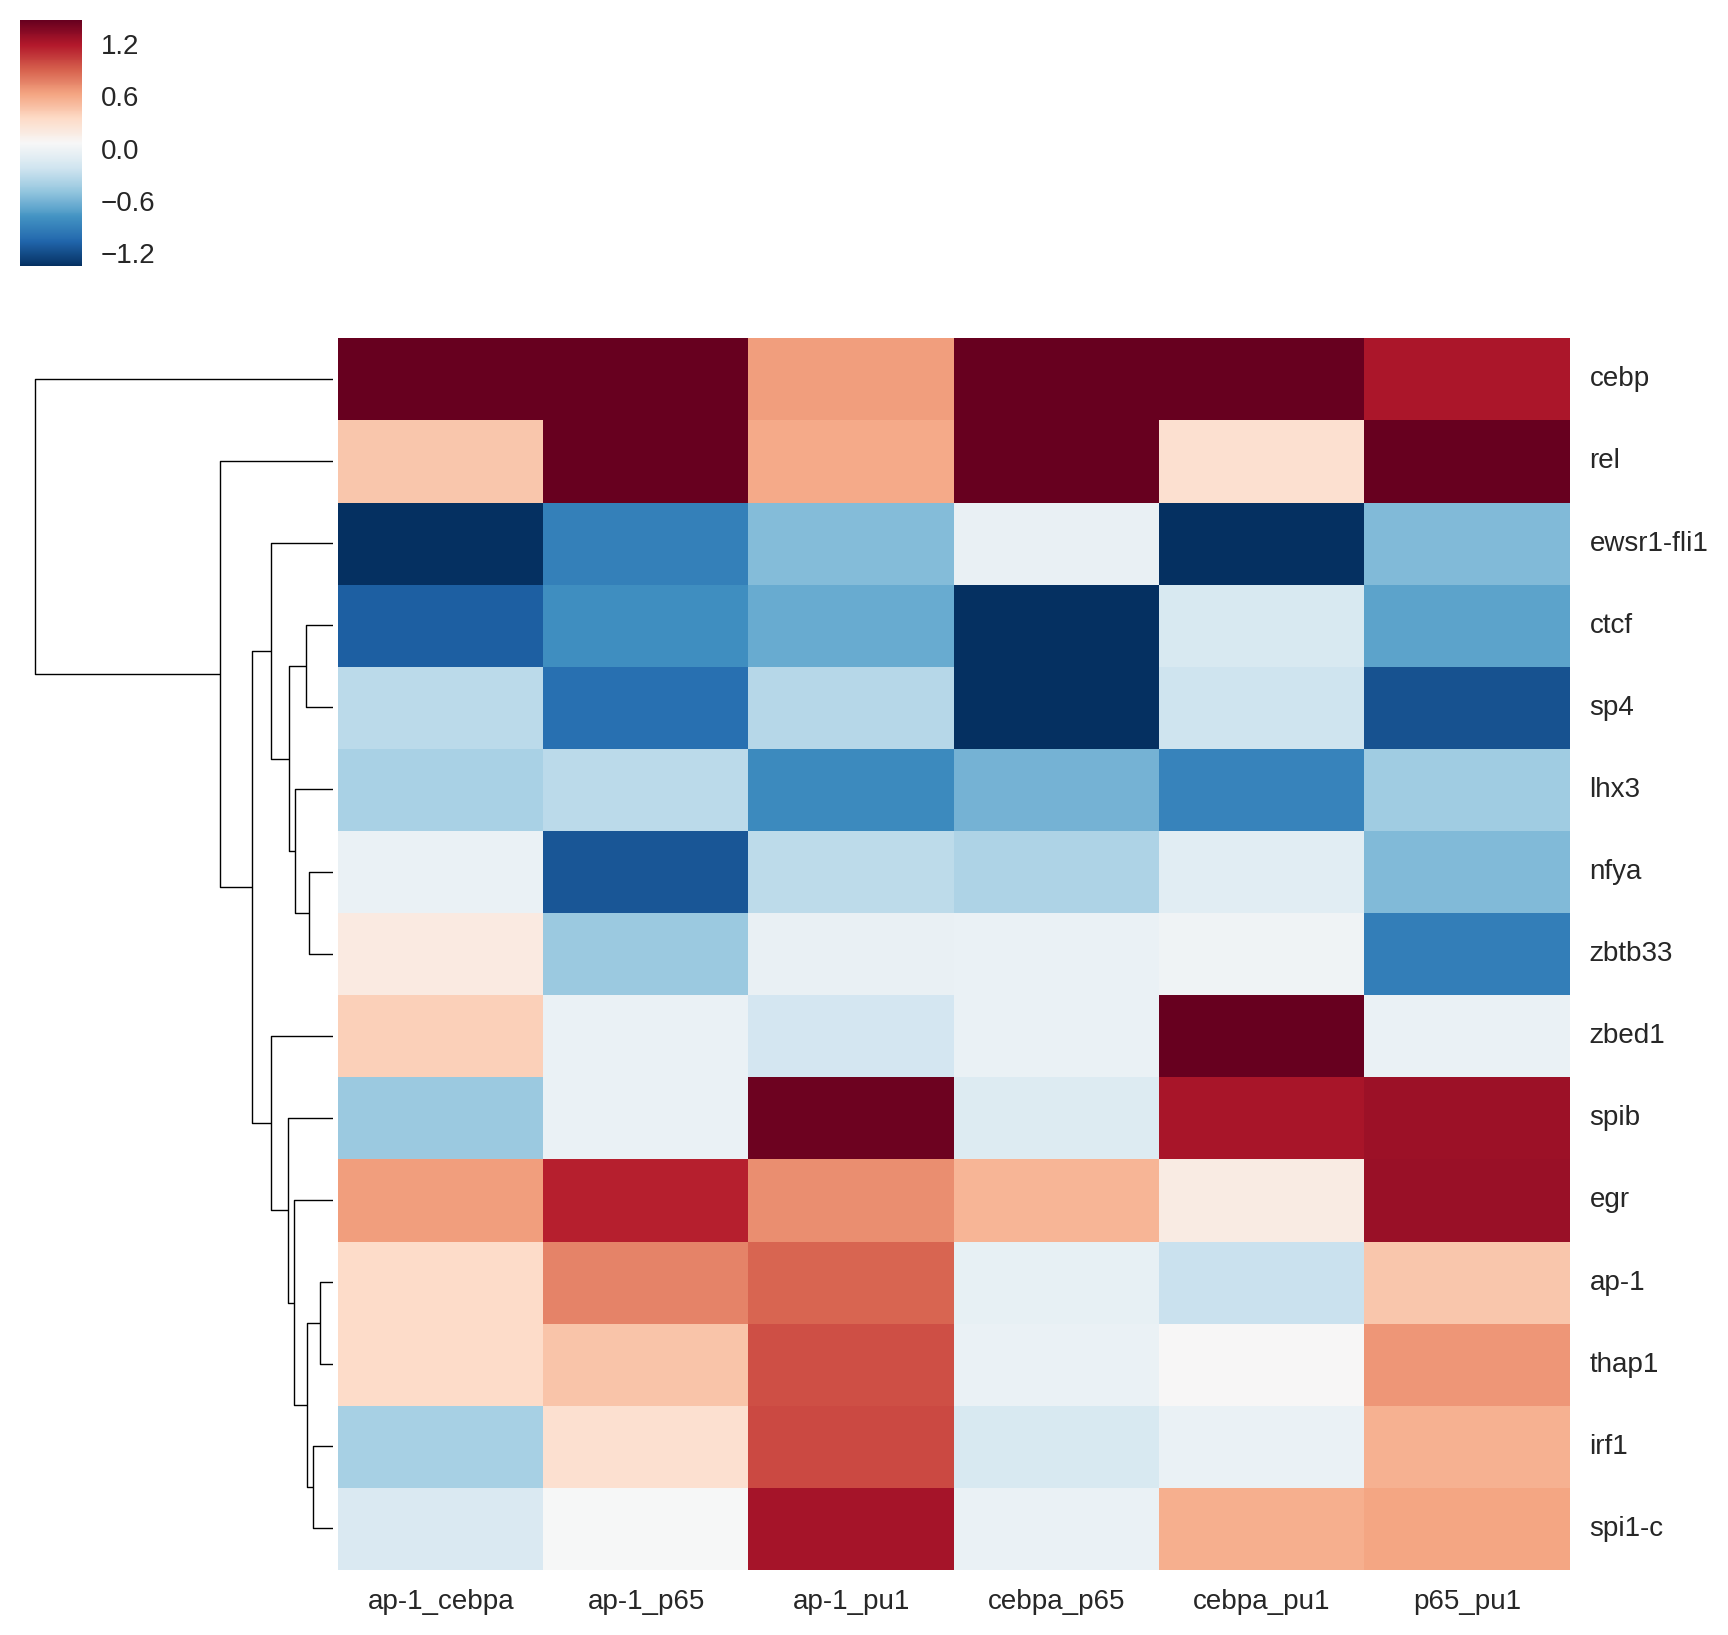

In [149]:
threshold = 3
coeff_std = np.std(coefficients_frame_kla_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_kla_pairs.values.flatten())
data = coefficients_frame_kla_pairs[coefficients_frame_kla_pairs.index.isin(significant_motifs_kla_pairs)]
data.columns = [x.replace('c57bl6_','') for x in data.columns.values]
cg = sns.clustermap(data,
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=False,annot_kws={"size": 6},
                   col_cluster=False)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

### comparisons within AP-1 dimers

In [717]:
factors = ['atf3', 'cjun', 'jund']
factorPairs = []
for i in range(len(factors)-1):
    for j in range(i+1, len(factors)):
        factorPairs.append(('c57bl6_'+factors[i],'c57bl6_'+ factors[j]))

In [718]:
### for all peaks in vehicle for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indicesc57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('veh'))].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0]+'_veh') & summary_frame['Factors'].str.contains(factorPair[1]+'_veh')
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    # Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_ap1_veh_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_ap1_veh_pairs.index = normed_motif_frame.columns.values

threshold = 3
factorPair_motifs_positive_dict = {}
factorPair_motifs_negative_dict = {}
factorPair_motifs_dict = {}
significant_motifs_ap1_veh_pairs = set()
for factor in coefficients_frame_ap1_veh_pairs.columns.values:
    weights = coefficients_frame_ap1_veh_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_ap1_veh_pairs.add(m)
    factorPair_motifs_dict[factor] = motif_hits
    factorPair_motifs_negative_dict[ factor] = negative_hits
    factorPair_motifs_positive_dict[factor] = positive_hits



total: 18554 filtered: 17991 true gc: 0.47215 false gc: 0.48215 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.808889628393
total: 18554 filtered: 18209 true gc: 0.49422 false gc: 0.48422 difference: 0.01
('c57bl6_atf3', 'c57bl6_jund') 0.820605043726
total: 18554 filtered: 13636 true gc: 0.50837 false gc: 0.49837 difference: 0.01
('c57bl6_cjun', 'c57bl6_jund') 0.826286792982
c57bl6_atf3_c57bl6_cjun -1.07395238831 1.21349691777
c57bl6_atf3_c57bl6_jund -1.03496936115 1.19275761681
c57bl6_cjun_c57bl6_jund -0.944282264134 1.16617433161


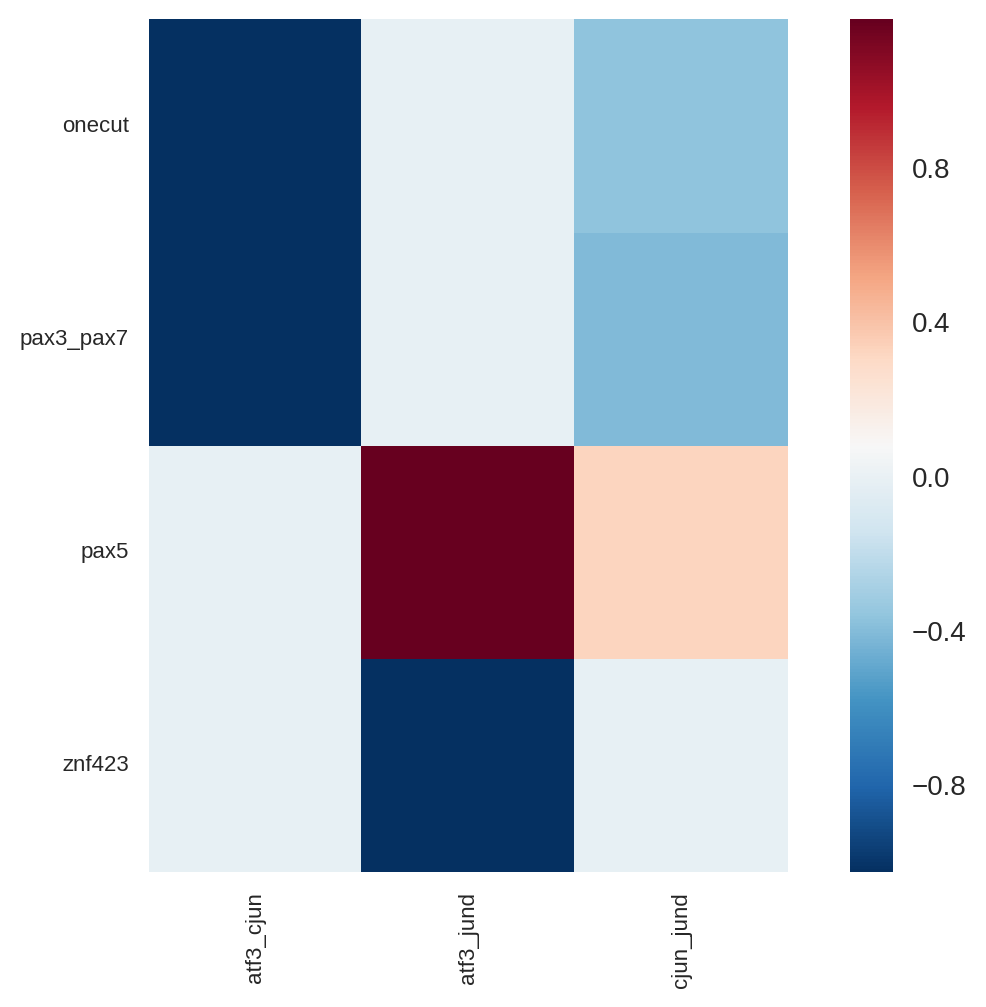

In [734]:
threshold = 3
coeff_std = np.std(coefficients_frame_ap1_veh_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_ap1_veh_pairs.values.flatten())
data = coefficients_frame_ap1_veh_pairs[coefficients_frame_ap1_veh_pairs.index.isin(significant_motifs_ap1_veh_pairs)]
data.columns = [x.replace('c57bl6_','') for x in data.columns.values]
# fig, ax = plt.subplots(figsize=(10,10))
data=data[(data.min(axis=1) <=0) & (data.max(axis=1) >= 0) ]
# data=data[(data.min(axis=1) <=0)]
with sns.axes_style('whitegrid'):
    cg = sns.heatmap(data,
                       vmax=(coeff_mean + threshold* coeff_std),
                       vmin=(coeff_mean - threshold* coeff_std),
                       center = coeff_mean,
                       annot=False,annot_kws={"size": 6},square=True)
    plt.setp(cg.axes.yaxis.get_majorticklabels(), fontsize=8, rotation=0);
    plt.setp(cg.axes.xaxis.get_majorticklabels(), fontsize=8, rotation=90);

In [699]:
factors = ['atf3', 'cjun', 'fos', 'junb', 'jund']
factorPairs = []
for i in range(len(factors)-1):
    for j in range(i+1, len(factors)):
        factorPairs.append(('c57bl6_'+factors[i],'c57bl6_'+ factors[j]))

In [713]:
### for all peaks in vehicle for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[(summary_frame['Factors'].str.contains('c57bl6')) &
                              (summary_frame['Factors'].str.contains('kla'))].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0]+'_kla') & summary_frame['Factors'].str.contains(factorPair[1]+'_kla')
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    # Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_ap1_kla_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_ap1_kla_pairs.index = normed_motif_frame.columns.values

threshold = 3
factorPair_motifs_positive_dict = {}
factorPair_motifs_negative_dict = {}
factorPair_motifs_dict = {}
significant_motifs_ap1_kla_pairs = set()
for factor in coefficients_frame_ap1_kla_pairs.columns.values:
    weights = coefficients_frame_ap1_kla_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    
    print(factor, mean-threshold*std, mean+threshold*std)
    for m in motif_hits:
        significant_motifs_ap1_kla_pairs.add(m)
    factorPair_motifs_dict[factor] = motif_hits
    factorPair_motifs_negative_dict[ factor] = negative_hits
    factorPair_motifs_positive_dict[factor] = positive_hits




total: 25337 filtered: 24862 true gc: 0.49382 false gc: 0.48383 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.84598343923
total: 25337 filtered: 25337 true gc: 0.47585 false gc: 0.48367 difference: 0.00782
('c57bl6_atf3', 'c57bl6_fos') 0.845545893639
total: 25337 filtered: 25337 true gc: 0.47857 false gc: 0.48352 difference: 0.00495
('c57bl6_atf3', 'c57bl6_junb') 0.841952152932
total: 25337 filtered: 25337 true gc: 0.4894 false gc: 0.48304 difference: 0.00636
('c57bl6_atf3', 'c57bl6_jund') 0.842640082108
total: 25337 filtered: 19669 true gc: 0.50475 false gc: 0.49475 difference: 0.01
('c57bl6_cjun', 'c57bl6_fos') 0.848368934136
total: 25337 filtered: 18907 true gc: 0.50664 false gc: 0.49664 difference: 0.01
('c57bl6_cjun', 'c57bl6_junb') 0.83916450331
total: 25337 filtered: 17496 true gc: 0.51138 false gc: 0.50138 difference: 0.01
('c57bl6_cjun', 'c57bl6_jund') 0.825824066516
total: 25337 filtered: 25337 true gc: 0.4889 false gc: 0.48078 difference: 0.00812
('c57bl6_fos', 'c57bl6_j

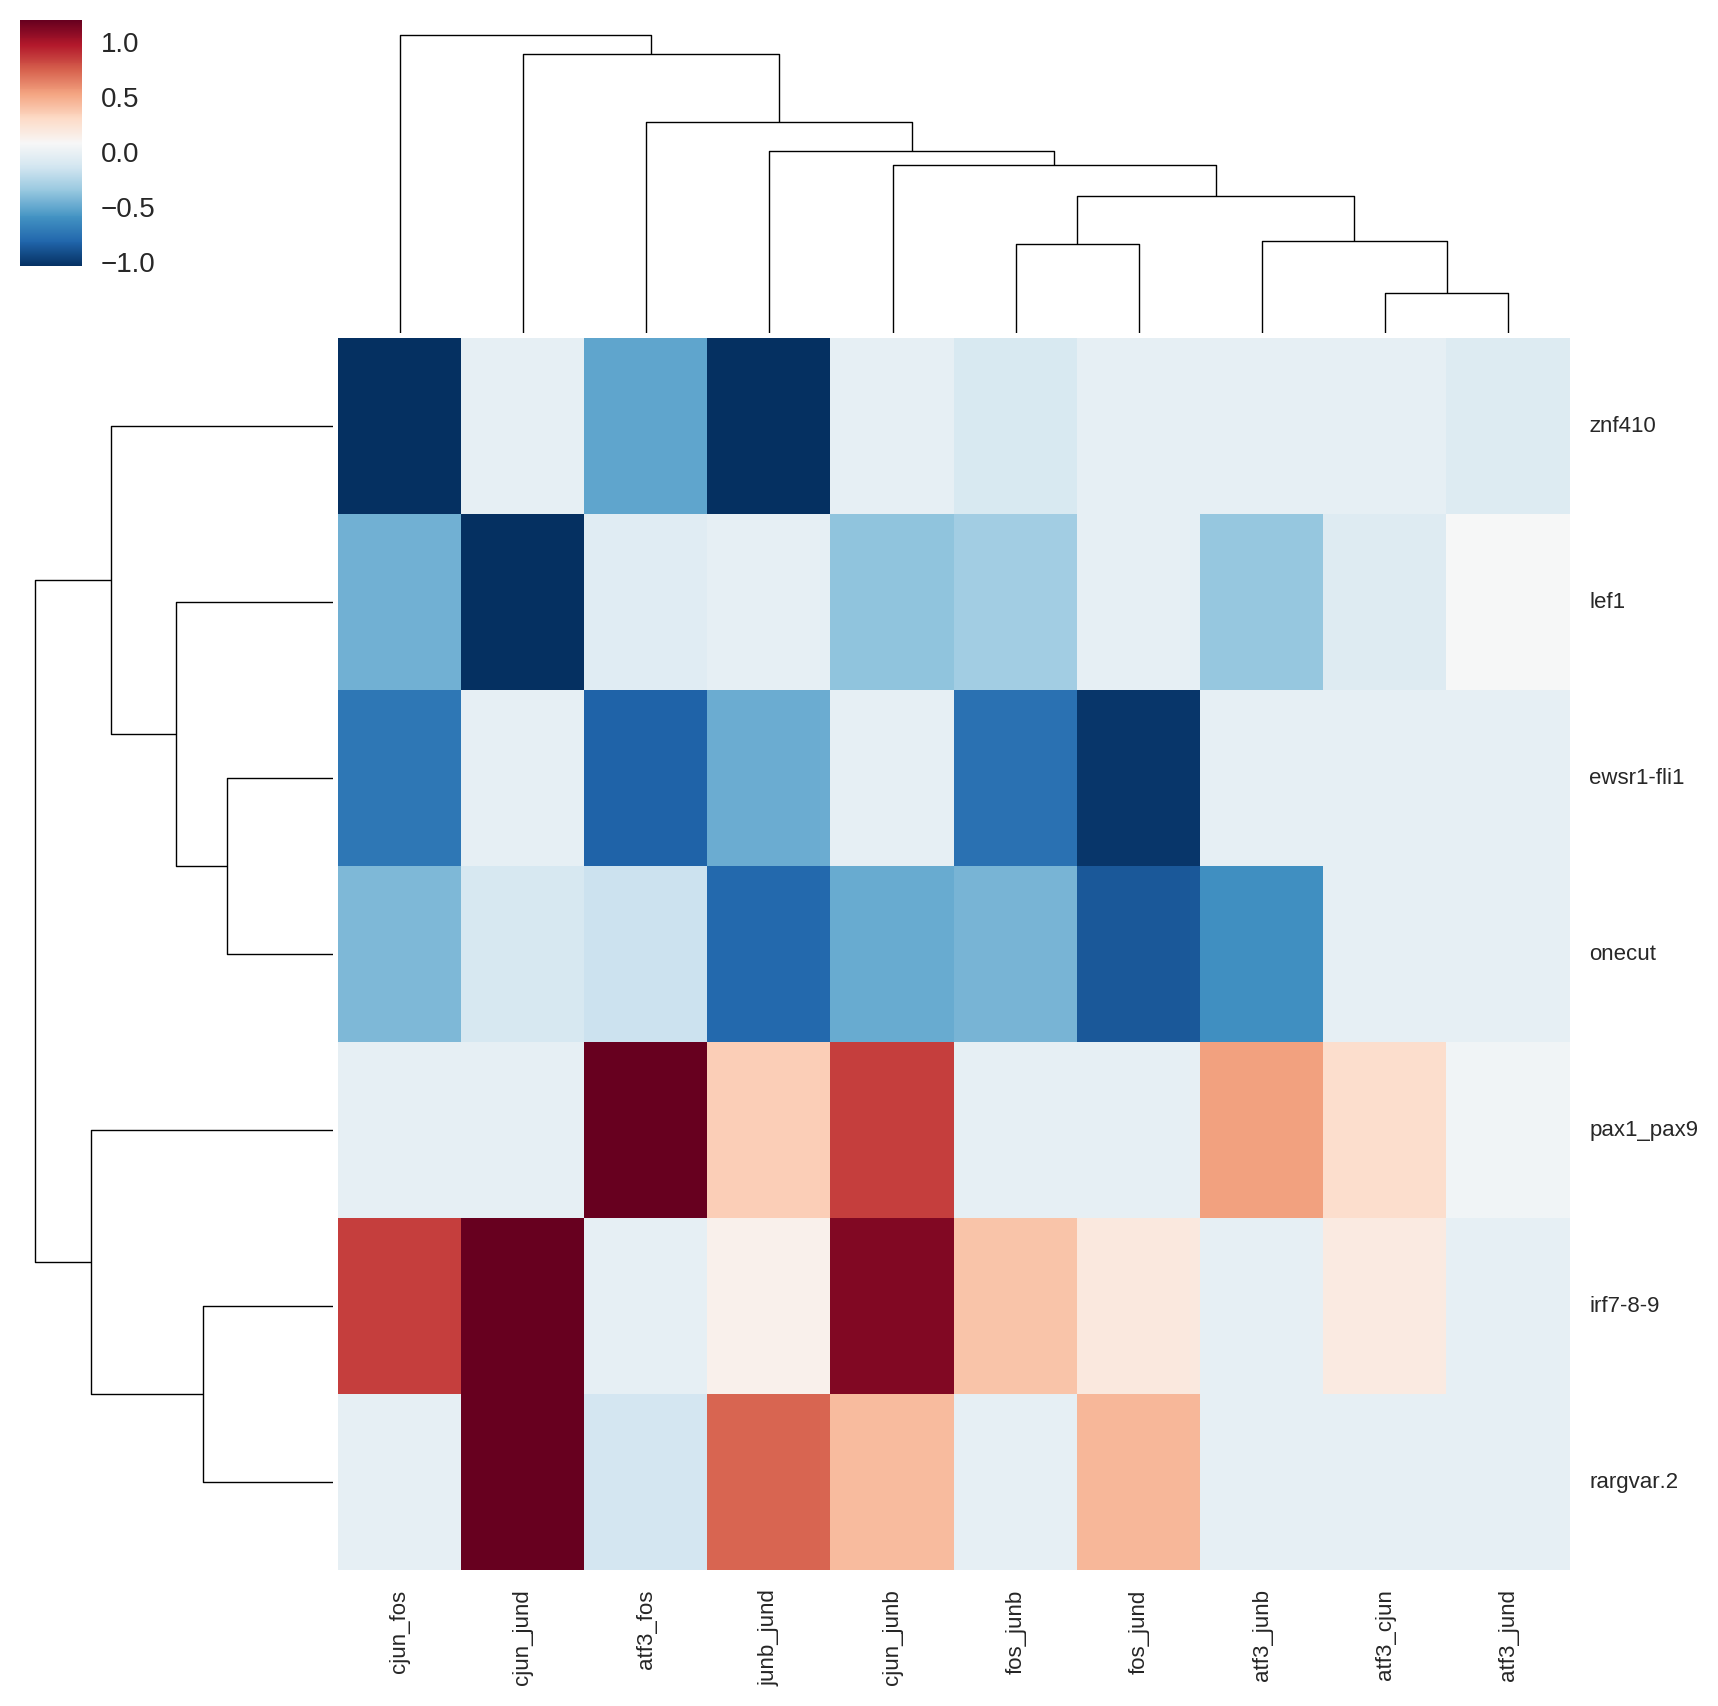

In [733]:
threshold = 3
coeff_std = np.std(coefficients_frame_ap1_kla_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_ap1_kla_pairs.values.flatten())
data = coefficients_frame_ap1_kla_pairs[coefficients_frame_ap1_kla_pairs.index.isin(significant_motifs_ap1_kla_pairs)]
data.columns = [x.replace('c57bl6_','') for x in data.columns.values]
data=data[(data.min(axis=1) <=0) & (data.max(axis=1) >= 0) ]


# fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style('whitegrid'):
    cg = sns.clustermap(data,
                       vmax=(coeff_mean + threshold* coeff_std),
                       vmin=(coeff_mean - threshold* coeff_std),
                       center = coeff_mean,
                       annot=False,annot_kws={"size": 6})
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8, rotation=0);
    plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8, rotation=90);

### 4d- Strains confirmations. X-axis - binding ratio between two (Balb/nod vs C57) Y-axis motif score


### 4e - crispr conformation? Knockout a loci and see that binding is disrupted (can’t be at AP-1 motif)

## Figure 5 - Motifs that drive the KLA transition

### For Individual Factors 

In [161]:
difference_indices = (coefficients_frame_kla*coefficients_frame_veh < 0) | \
                     (coefficients_frame_kla*coefficients_frame_veh == 0)
current_coefficients_frame_kla = coefficients_frame_kla[difference_indices.sum(axis=1)>0]
current_coefficients_frame_veh = coefficients_frame_veh[difference_indices.sum(axis=1)>0]

coefficients_difference_frame = current_coefficients_frame_kla - current_coefficients_frame_veh
coefficients_difference_frame[current_coefficients_frame_veh * current_coefficients_frame_kla > 0] =0
# del coefficients_difference_frame['p65']


0.298325070774


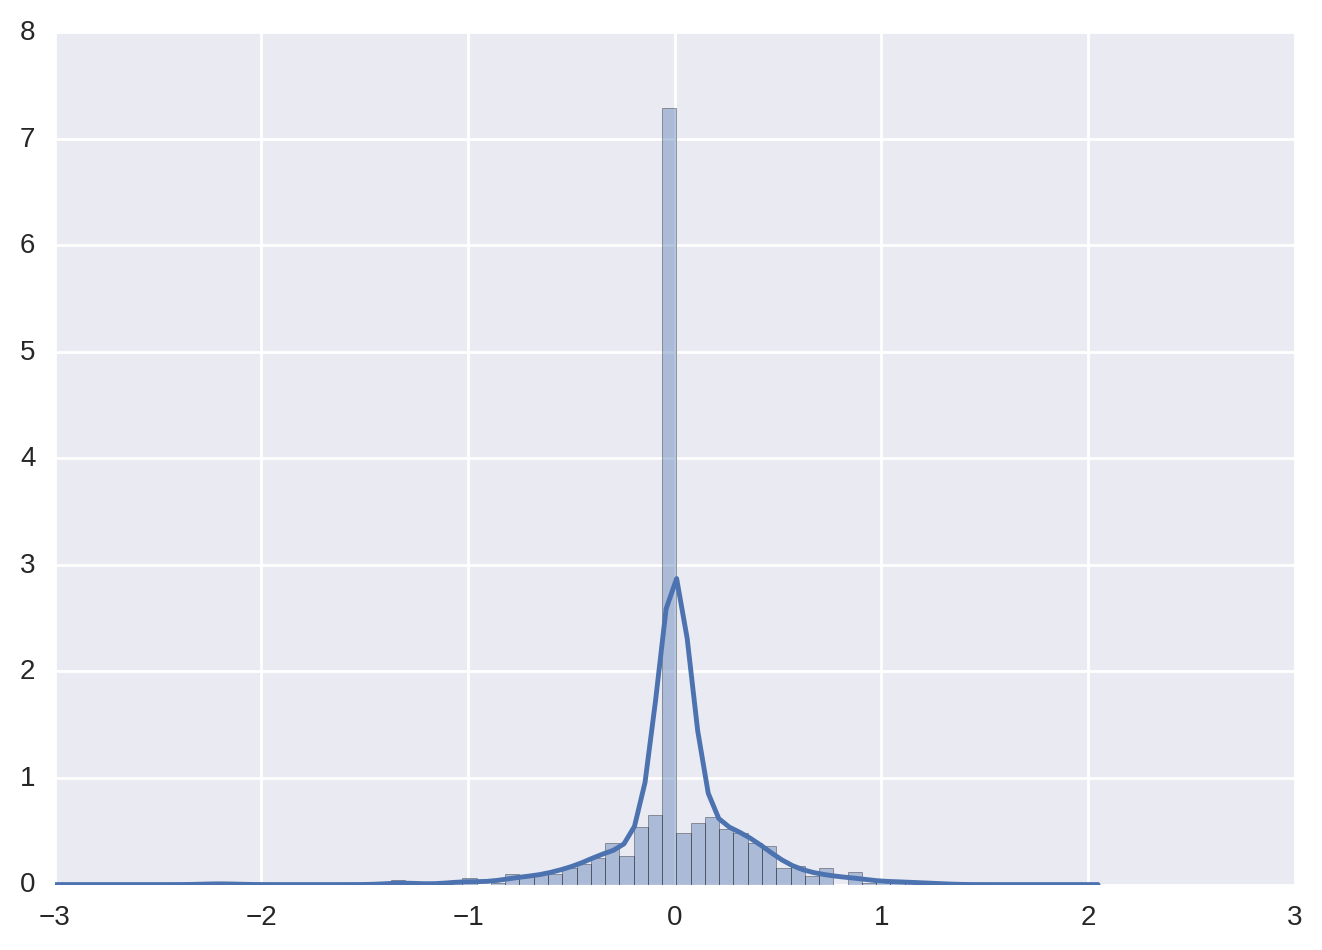

In [162]:
sns.distplot(coefficients_difference_frame.values.flatten())
print(np.std(coefficients_difference_frame.values.flatten()))

In [174]:
threshold = 2.5
significant_motifs_differences = set()
for factor in coefficients_difference_frame.columns.values:
    weights = coefficients_difference_frame[factor]
    mean=np.mean(weights)
    std = np.std(weights)
    positive_hits = list(weights[weights >= mean + threshold * std].index.values)
    negative_hits = list(weights[weights <= mean - threshold * std].index.values)
    motif_hits = negative_hits + positive_hits
    print(factor, mean, std)
    for m in motif_hits:
        significant_motifs_differences.add(m)

ap-1 -0.00768914250645 0.24534791515
cebpa 0.0270578559777 0.238641967067
pu1 0.0490691164019 0.315906576788
p65 0.0250186052188 0.370685048632


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

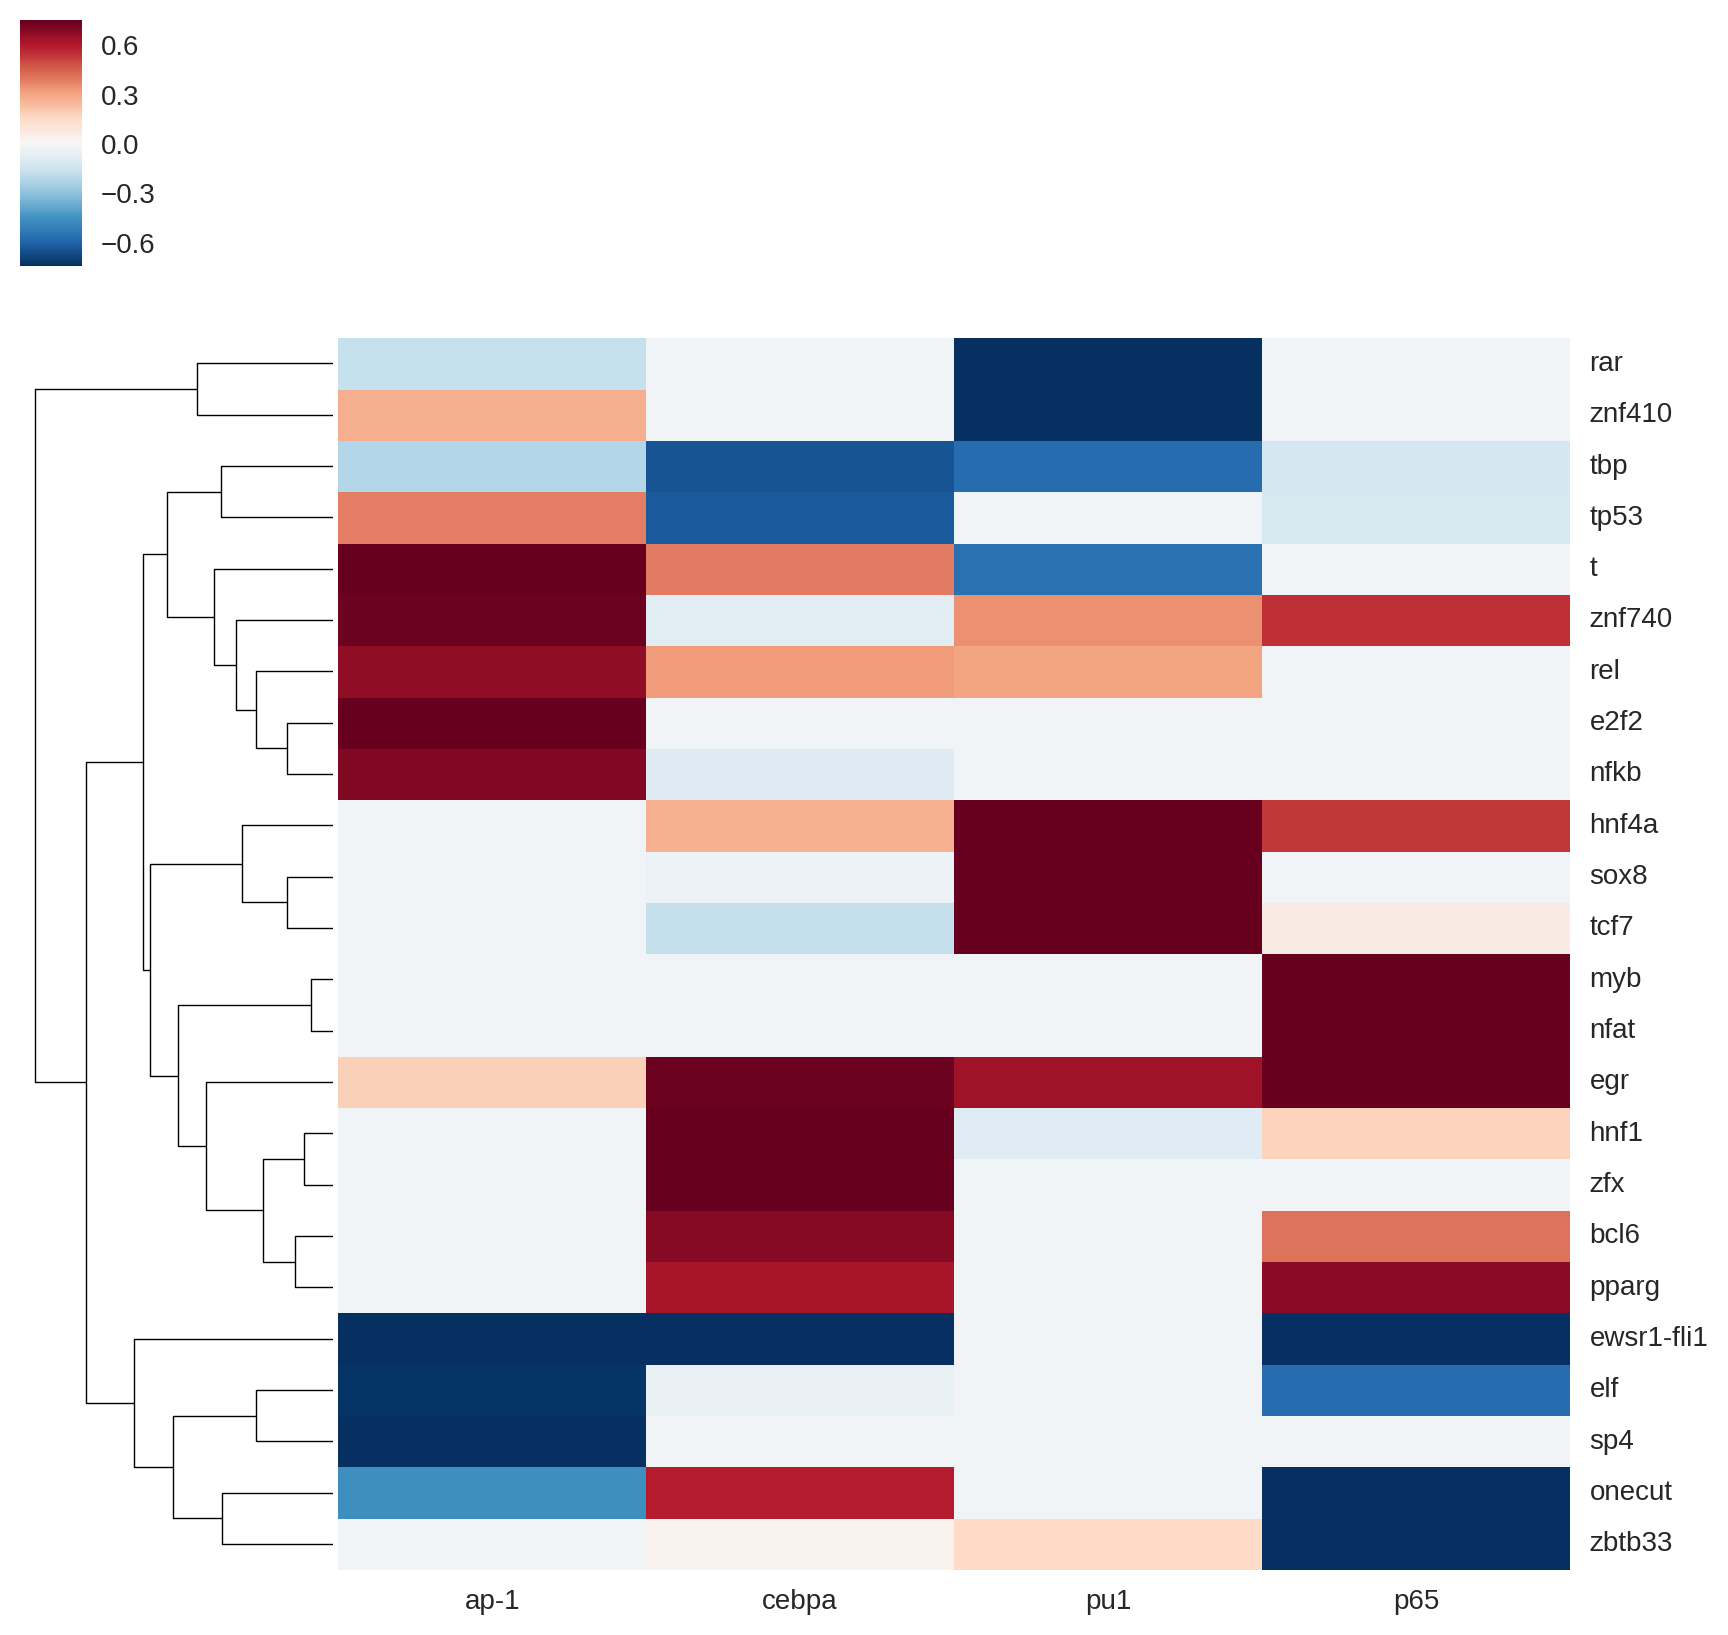

In [176]:
threshold = 2.5
coeff_std = np.std(coefficients_difference_frame.values.flatten());
coeff_mean = np.mean(coefficients_difference_frame.values.flatten());
data = coefficients_difference_frame[coefficients_difference_frame.index.isin(significant_motifs_differences)];
data.columns = [x.replace('c57bl6_','') for x in data.columns.values];
# fig, ax = plt.subplots(figsize=(10,10))
cg = sns.clustermap(data,
                   vmax=mean+threshold*coeff_std,
                   vmin=mean-threshold*coeff_std,
                   center = coeff_mean,
                   annot=False,annot_kws={"size": 6},
                    col_cluster=False
                   );
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8, rotation=0);

### For collaborative binding

In [200]:
# difference_indices = (coefficients_frame_kla_pairs*coefficients_frame_veh_pairs < 0) | \
#                      (coefficients_frame_kla_pairs*coefficients_frame_veh_pairs == 0)
# current_coefficients_frame_kla = coefficients_frame_kla_pairs[difference_indices.sum(axis=1)>0]
# current_coefficients_frame_veh = coefficients_frame_veh_pairs[difference_indices.sum(axis=1)>0]

# coefficients_difference_pair_frame = current_coefficients_frame_kla - current_coefficients_frame_veh
# coefficients_difference_pair_frame[current_coefficients_frame_veh * current_coefficients_frame_kla > 0] =0
# # # del coefficients_difference_frame['p65']



In [199]:
# sns.distplot(coefficients_difference_pair_frame.values.flatten())
# print(np.std(coefficients_difference_pair_frame.values.flatten()))

In [198]:
# threshold = 3
# significant_motifs_differences_pair = set()
# for factor in coefficients_difference_pair_frame.columns.values:
#     weights = coefficients_difference_pair_frame[factor]
#     mean=np.mean(weights)
#     std = np.std(weights)
#     positive_hits = list(weights[weights >= mean + threshold * std].index.values)
#     negative_hits = list(weights[weights <= mean - threshold * std].index.values)
#     motif_hits = negative_hits + positive_hits
#     print(factor, mean, std)
#     for m in motif_hits:
#         significant_motifs_differences_pair.add(m)

In [197]:
# threshold = 3
# coeff_std = np.std(coefficients_difference_pair_frame.values.flatten());
# coeff_mean = np.mean(coefficients_difference_pair_frame.values.flatten());
# data = coefficients_difference_pair_frame[coefficients_difference_pair_frame.index.isin(significant_motifs_differences_pair)];
# data.columns = [x.replace('c57bl6_','') for x in data.columns.values];
# # fig, ax = plt.subplots(figsize=(10,10))
# cg = sns.clustermap(data,
#                    vmax=mean+threshold*coeff_std,
#                    vmin=mean-threshold*coeff_std,
#                    center = coeff_mean,
#                    annot=False,annot_kws={"size": 6},
#                     col_cluster=False
#                    );
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
# # plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8, rotation=0);

In [624]:
steps = 10
# motifs = normed_motif_frame.columns.values
motifs = ['ap-1', 'spi1-c', 'cebp', 'rel','irf1', 'pbx1', 'znf740']
matrix = np.zeros((len(motifs), steps))
open_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in _factors +['atac']]].sum(axis=1)>0].index.values


# current_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
current_frame = normed_motif_frame
current_frame = current_frame[current_frame.index.isin(open_indices)]
totalPeaks = current_frame.shape[0]
for i in range(len(motifs)):
    motif = motifs[i]
    
    for j in range(steps):
        threshold = j/steps
        fraction = np.sum(current_frame[motif] > threshold) / totalPeaks
        matrix[i][j] = fraction




In [625]:
fraction_frame = pd.DataFrame(matrix)
fraction_frame.index=motifs
fraction_frame.columns = np.arange(0,1,1/steps)

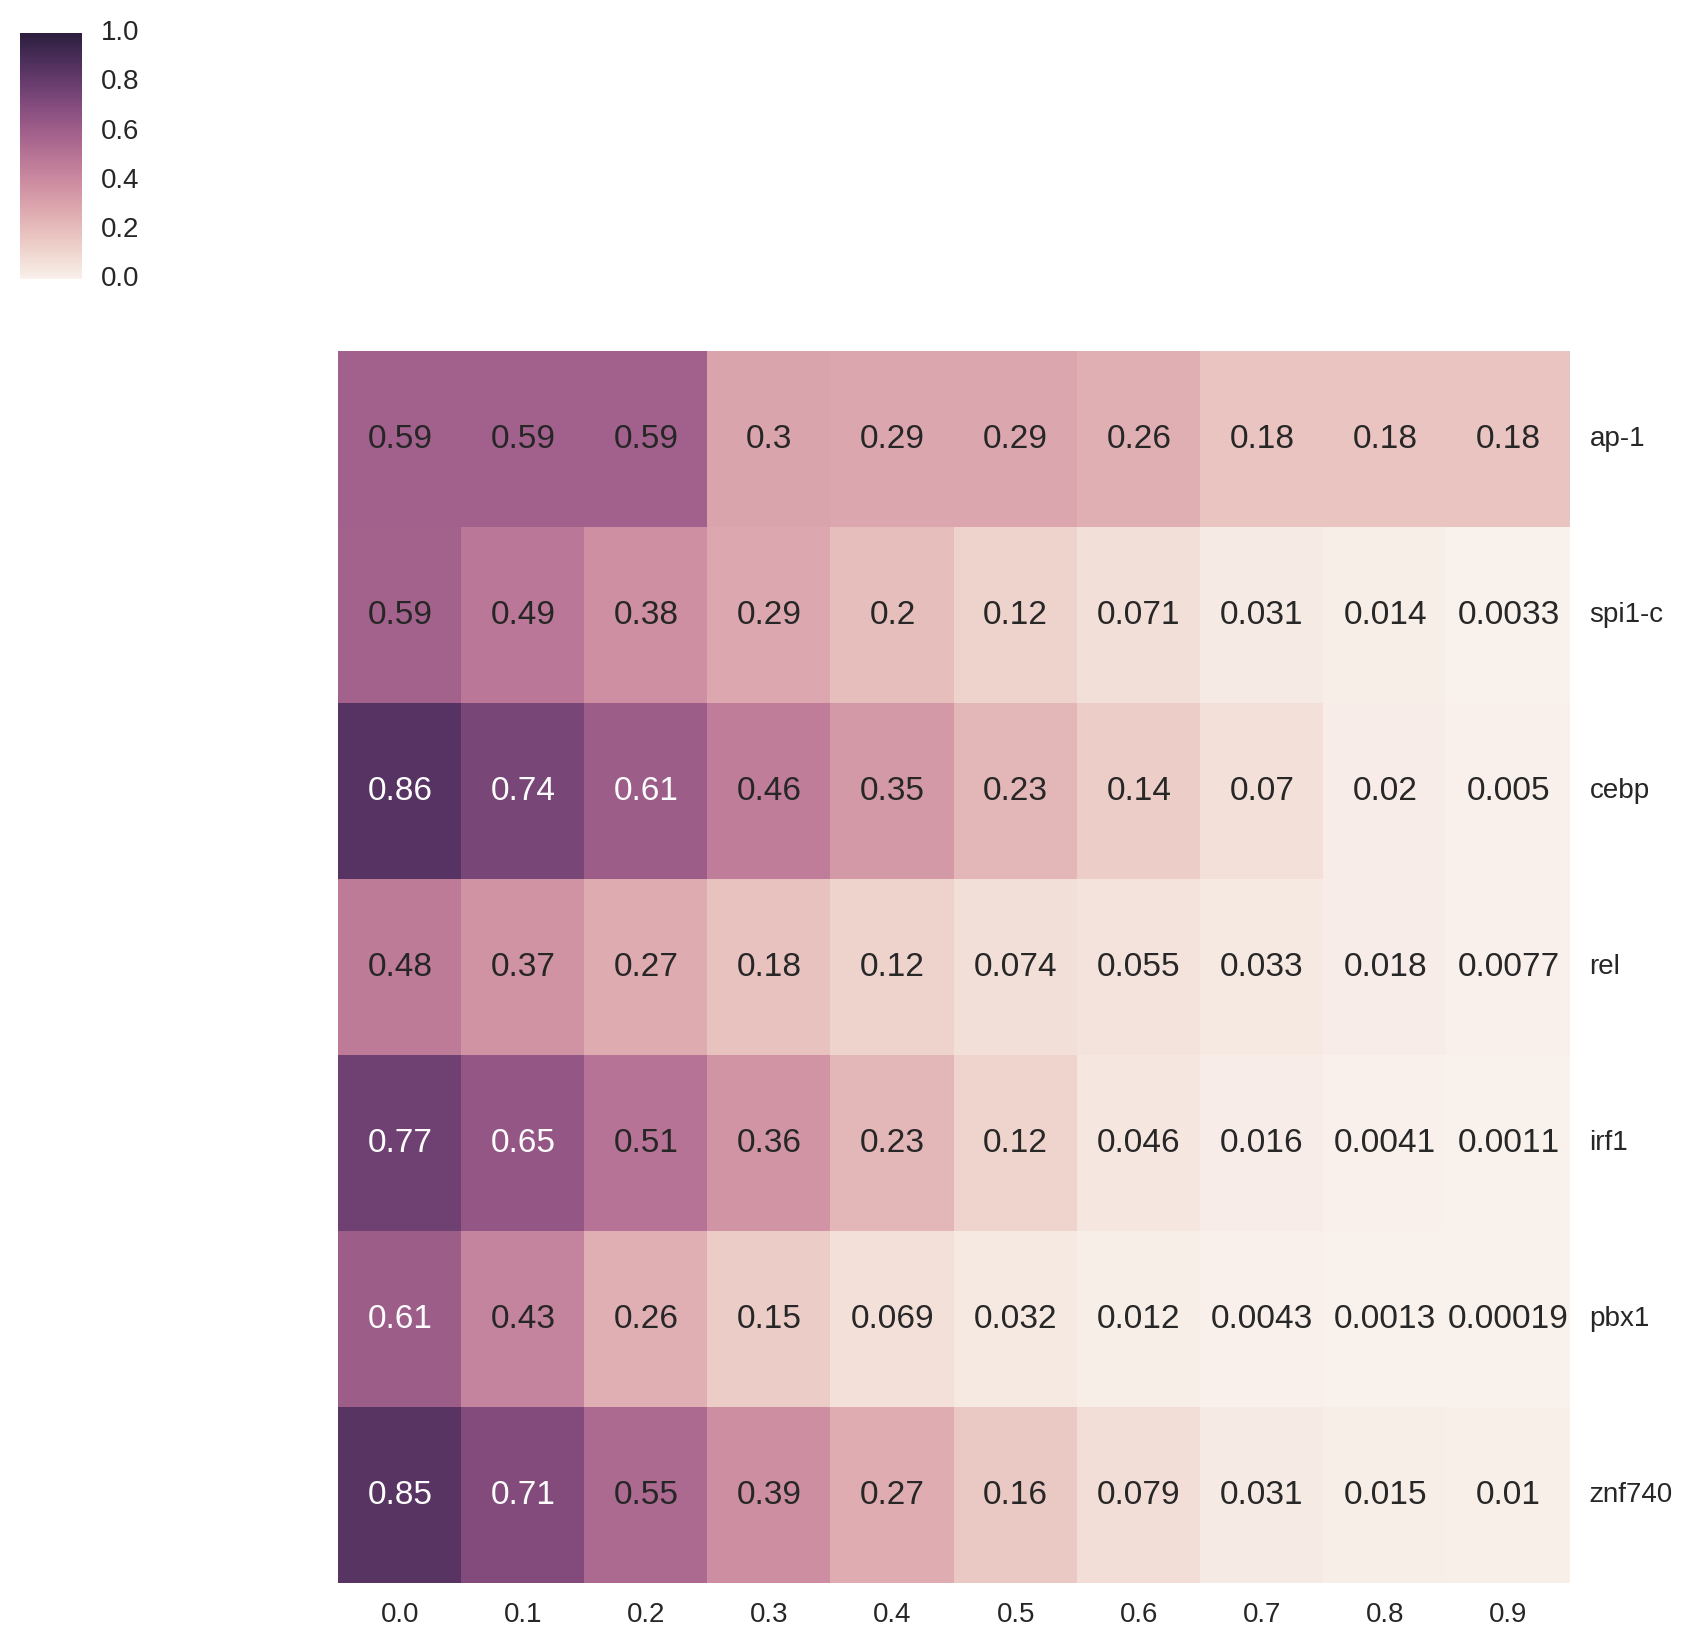

In [626]:
cg = sns.clustermap(fraction_frame,
              col_cluster=False,
                    row_cluster=False,
              vmin=0,
              vmax=1,
                   annot=True)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0,
        );

In [605]:
open_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in _factors +['atac']]].sum(axis=1)>0].index.values



In [606]:
['c57bl6_' + x + '_veh' for x in _factors +['atac']]

['c57bl6_atf3_veh',
 'c57bl6_cebpa_veh',
 'c57bl6_cjun_veh',
 'c57bl6_fos_veh',
 'c57bl6_junb_veh',
 'c57bl6_jund_veh',
 'c57bl6_p65_veh',
 'c57bl6_pu1_veh',
 'c57bl6_atac_veh']